# Setup

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Data Prep

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load your dataset
approach_3_df = pd.read_csv(r'approach_3_C+P.csv')

# Specify your features here
list_3 = [....]  # Replace this with your actual column names

def prepare_data(approach_3_df, list_3, device, batch_size=64):
    # Normalize the features if needed (StandardScaler as an example)
    scaler = StandardScaler()
    approach_3_df[list_3] = scaler.fit_transform(approach_3_df[list_3])

    # Extract relevant columns for features and labels
    features_3 = approach_3_df[....]

    # Split data (70% train, 15% validation, 15% test)
    train_df, temp_df = train_test_split(features_3, test_size=0.4, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    train_df = train_df.loc[:, ~train_df.columns.duplicated()]
    val_df = val_df.loc[:, ~val_df.columns.duplicated()]
    test_df = test_df.loc[:, ~test_df.columns.duplicated()]

    # Extract features and labels for train, validation, and test datasets
    train_features = train_df.drop(columns=[....])
    train_labels = torch.tensor(train_df[....].values, dtype=torch.float32, device=device).unsqueeze(1)  # Ensure correct shape

    val_features = val_df.drop(columns=[....])
    val_labels = torch.tensor(val_df[....].values, dtype=torch.float32, device=device).unsqueeze(1)

    test_features = test_df.drop(columns=[....])
    test_labels = torch.tensor(test_df[....].values, dtype=torch.float32, device=device).unsqueeze(1)

    # Convert data into GPU tensors
    xtrain = torch.tensor(train_features.values, dtype=torch.float32, device=device)
    xval = torch.tensor(val_features.values, dtype=torch.float32, device=device)
    xtest = torch.tensor(test_features.values, dtype=torch.float32, device=device)

    # Create TensorDatasets
    train_dataset = TensorDataset(xtrain, train_labels)
    val_dataset = TensorDataset(xval, val_labels)
    test_dataset = TensorDataset(xtest, test_labels)

    # Create DataLoader instances for training, validation, and testing
    gpu_loader_config = {
        "pin_memory": False,        # Not necessary as data is already on GPU
        "num_workers": 0,           # No parallel CPU data loading
        "persistent_workers": False,
    }

    # Limit datasets to the first 1000 samples
    train_subset = Subset(train_dataset, range(1000))
    val_subset = Subset(val_dataset, range(1000))
    test_subset = Subset(test_dataset, range(1000))


    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, **gpu_loader_config)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, **gpu_loader_config)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, **gpu_loader_config)

    return train_loader, val_loader, test_loader


Using device: cuda


# Model definition

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pennylane as qml
import math
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
import numpy as np
import os
import json
import csv




In [ ]:
def run():
    # =====================
    # 2. GPU Configuration
    # =====================
    if USE_GPU and not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. This script requires a GPU.")

    device = torch.device("cuda" if USE_GPU else "cpu")
    print(f"Using device: {device}")
    print(f"PyTorch CUDA version: {torch.version.cuda}")

    # Quantum device setup with fixed settings
    try:
        dev = qml.device("lightning.gpu", wires=NUM_QUBITS, batch_obs=True, shots=None)
        print(f"PennyLane device configured: {dev.name} on GPU")
    except Exception as e:
        print(f"Error initializing PennyLane lightning.gpu device: {e}")
        exit()

    # =====================
    # 3. Quantum Circuit
    # =====================

    @qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)
    def quantum_circuit(inputs, weights):
        for i in range(NUM_QUBITS):
            qml.....(inputs[:, i], wires=i)

        for layer in range(NUM_LAYERS):
            for i in range(NUM_QUBITS):
                qml.....(weights[layer, i], wires=i)
            for i in range(NUM_QUBITS):
                qml.....(wires=[i, (i + 1) % NUM_QUBITS])

        return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]

    # =====================
    # 4. Classical Components
    # =====================
    class PreAutoencoder(nn.Module):
        def __init__(self, input_dim=INPUT_DIM, output_dim=NUM_QUBITS):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, HIDDEN_DIM),
                nn.ReLU(),
                nn.Linear(HIDDEN_DIM, output_dim),
                nn.Tanh()
            )

        def forward(self, x):
            return self.encoder(x)

    class PostAutoencoder(nn.Module):
        def __init__(self, input_dim=NUM_QUBITS, output_dim=FINAL_OUTPUT_DIM):
            super().__init__()
            self.decoder = nn.Sequential(
                nn.Linear(input_dim, POST_HIDDEN_DIM),
                nn.ReLU(),
                nn.Linear(POST_HIDDEN_DIM, output_dim)
            )

        def forward(self, x):
            return self.decoder(x)

    # Quantum layer
    weight_shapes = {"weights": (NUM_LAYERS, NUM_QUBITS)}
    qnn_model = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    # =====================
    # 5. Hybrid Model
    # =====================
    class HybridQNN(nn.Module):
        def __init__(self, pre_encoder, qnn, post_decoder):
            super().__init__()
            self.pre_encoder = pre_encoder
            self.quantum_layer = qnn
            self.post_decoder = post_decoder
            self.to(device)

        def forward(self, x):
            x = x.to(device)

            with torch.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
                encoded = self.pre_encoder(x)
                scaled_inputs = encoded * math.pi
                quantum_out = self.quantum_layer(scaled_inputs).float()
                quantum_out = quantum_out.to(device)
                return self.post_decoder(quantum_out)

    # ========== Initialize Model ==========
    pre_ae = PreAutoencoder()
    post_ae = PostAutoencoder()
    model = HybridQNN(pre_ae, qnn_model, post_ae)

    # =====================
    # 6. Training Setup (continued)
    # =====================
    # Continue with the training setup as needed here

    # ===========================
    # 5. Training Loop Setup
    # ===========================
    train_loader, val_loader, test_loader = prepare_data(approach_3_df, list_3, device)

    # =====================
    # 6. Optimizer Setup
    # =====================
    optimizer = optim.AdamW([
        {'params': model.pre_encoder.parameters(), 'lr': LR_PRE_ENCODER, 'weight_decay': WEIGHT_DECAY},
        {'params': model.quantum_layer.parameters(), 'lr': LR_QUANTUM},
        {'params': model.post_decoder.parameters(), 'lr': LR_POST_DECODER, 'weight_decay': WEIGHT_DECAY}
    ])

    # =====================
    # 7. Learning Rate Scheduler
    # =====================
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=LR_SCHEDULER_FACTOR,
        patience=LR_SCHEDULER_PATIENCE,
        verbose=True
    )

    # =====================
    # 8. Mixed Precision Support
    # =====================
    scaler = torch.GradScaler(device=device)

    # =====================
    # 9. Loss Function
    # =====================
    criterion = nn.MSELoss()

    # =====================
    # 10. Training Loop (Enhanced)
    # =====================
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    gradient_norms_total = []
    gradient_norms_per_layer = []
    learning_rates = []
    best_epoch = 0

    start_time = time.time()

    training_logs = []

    # Start Training Loop
    for epoch in range(NUM_EPOCHS):
        with tqdm(total=len(train_loader) + len(val_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit='batch') as pbar:

            # === Training ===
            model.train()
            train_loss = 0.0
            epoch_grad_per_layer = {'pre_encoder': ...., 'quantum_layer': ...., 'post_decoder': ....}

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)  # Unscale before computing gradient norm

                # === Compute Gradient Norms ===
                total_norm = 0.0
                for name, module in model.named_children():
                    layer_norm = 0.0
                    for param in module.parameters():
                        if param.grad is not None:
                            param_norm = param.grad.data.norm(2)
                            total_norm += param_norm.item() ** 2
                            layer_norm += param_norm.item() ** 2
                    epoch_grad_per_layer[name] += layer_norm ** 0.5

                total_norm = total_norm ** 0.5
                gradient_norms_total.append(total_norm)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                train_loss += loss.item() * inputs.size(0)
                pbar.set_postfix({'Phase': 'Train', 'Loss': loss.item()})
                pbar.update(1)

            # === Average Gradient Norm Per Layer (per epoch) ===
            gradient_norms_per_layer.append({
                layer: norm for layer, norm in epoch_grad_per_layer.items()
            })

            # === Validation ===
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    pbar.set_postfix({'Phase': 'Validate', 'Loss': loss.item()})
                    pbar.update(1)

            # === Update Epoch Metrics ===
            train_loss /= len(train_loader.dataset)
            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)

            learning_rates.append(optimizer.param_groups[0]['lr'])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                torch.save(model.state_dict(), SAVE_MODEL_PATH)
                pbar.write(f"New best model saved with val loss: {val_loss:.4f}")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                pbar.write("Early stopping triggered!")
                break

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            pbar.set_postfix({
                'Train Loss': f"{train_loss:.4f}",
                'Val Loss': f"{val_loss:.4f}",
                'Grad Norm': f"{total_norm:.4f}",
                'LR': f"{optimizer.param_groups[1]['lr']:.5f}"
            })

            # Save logs for this epoch
            training_logs.append({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "gradient_norm_total": total_norm,
                "gradient_norm_layerwise": epoch_grad_per_layer,
                "learning_rate": optimizer.param_groups[0]["lr"]
            })

    training_time = (time.time() - start_time) / 60  # in minutes

    # ===========================
    # Final Metrics Logging
    # ===========================
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    generalization_gap = final_val_loss - final_train_loss
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n=== Final Metrics ===")
    print(f"Final Train Loss: {final_train_loss:.4f}")
    print(f"Final Val Loss: {final_val_loss:.4f}")
    print(f"Generalization Gap: {generalization_gap:.4f}")
    print(f"Best Val Epoch: {best_epoch}")
    print(f"Training Time: {training_time:.2f} minutes")
    print(f"Trainable Parameters: {num_params}")

    # ===========================
    # Save Final Predictions
    # ===========================
    model.eval()
    final_predictions = []
    final_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            final_predictions.append(outputs.cpu().numpy())
            final_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays for easy saving
    final_predictions = np.concatenate(final_predictions, axis=0)
    final_labels = np.concatenate(final_labels, axis=0)

    # Save the predictions and labels to CSV
    os.makedirs('....', exist_ok=True)
    np.savetxt(f...., final_predictions, delimiter=',')
    np.savetxt(f...., final_labels, delimiter=',')

    # ===========================
    # Plot Loss Curves
    # ===========================
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss over Epochs for model {model_name}')
    plt.legend()

    # Save the plot to a file
    plot_path = f....
    plt.savefig(plot_path)

    plt.show()

    # ===========================
    # Plot Gradient Norms
    # ===========================
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(gradient_norms_total) + 1), gradient_norms_total, label="Gradient Norm (Total)", color='orange')
    plt.xlabel('Batch')
    plt.ylabel('L2 Norm')
    plt.title(f'Gradient Norm per Batch for model {model_name}')
    plt.legend()

    # Save the plot to a file
    plot_path = f....
    plt.savefig(plot_path)

    plt.show()

    # ===========================
    # Plot Learning Rate Schedule
    # ===========================
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label="Learning Rate", color='green')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.title(f'Learning Rate over Epochs for model {model_name}')
    plt.legend()

    # Save the plot to a file
    plot_path = f....
    plt.savefig(plot_path)

    plt.show()

    # ===========================
    # Save Training Logs to JSON and CSV
    # ===========================
    os.makedirs("logs", exist_ok=True)

    # Save training logs to JSON
    with open(f...., "w") as f:
        json.dump(training_logs, f, indent=4)

    # Save summary to CSV
    run_summary = {
        "model_id": model_name,
        "architecture": " ",
        "qubits": NUM_QUBITS,
        "depth": NUM_LAYERS,
        "train_loss_final": final_train_loss,
        "val_loss_final": final_val_loss,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "final_grad_norm": training_logs[-1]["gradient_norm_total"],
        "generalization_gap": generalization_gap,
        "training_time_minutes": training_time,
        "num_params": num_params
    }

    csv_path = f"...."
    write_headers = not os.path.exists(csv_path)
    with open(csv_path, "a", newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=run_summary.keys())
        if write_headers:
            writer.writeheader()
        writer.writerow(run_summary)



/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_3_42 3 2 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=1.0721, Val Loss=0.8829, Grad Norm=1.2265, LR=0.00010]


New best model saved with val loss: 0.8829


Epoch 2/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=0.8876, Val Loss=0.7452, Grad Norm=0.9358, LR=0.00010]


New best model saved with val loss: 0.7452


Epoch 3/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=0.7223, Val Loss=0.5823, Grad Norm=1.6239, LR=0.00010]


New best model saved with val loss: 0.5823


Epoch 4/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=0.5880, Val Loss=0.4718, Grad Norm=0.8129, LR=0.00010]


New best model saved with val loss: 0.4718


Epoch 5/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=0.4862, Val Loss=0.3818, Grad Norm=0.6055, LR=0.00010]


New best model saved with val loss: 0.3818


Epoch 6/20: 100%|██████████| 32/32 [00:13<00:00,  2.33batch/s, Train Loss=0.3813, Val Loss=0.2799, Grad Norm=1.0700, LR=0.00010]


New best model saved with val loss: 0.2799


Epoch 7/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=0.2675, Val Loss=0.1859, Grad Norm=1.1531, LR=0.00010]


New best model saved with val loss: 0.1859


Epoch 8/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, Train Loss=0.1729, Val Loss=0.1297, Grad Norm=0.9755, LR=0.00010]


New best model saved with val loss: 0.1297


Epoch 9/20: 100%|██████████| 32/32 [00:13<00:00,  2.29batch/s, Train Loss=0.1154, Val Loss=0.1071, Grad Norm=0.7001, LR=0.00010]


New best model saved with val loss: 0.1071


Epoch 10/20: 100%|██████████| 32/32 [00:13<00:00,  2.29batch/s, Train Loss=0.0889, Val Loss=0.0970, Grad Norm=0.2740, LR=0.00010]


New best model saved with val loss: 0.0970


Epoch 11/20: 100%|██████████| 32/32 [00:14<00:00,  2.25batch/s, Train Loss=0.0768, Val Loss=0.0864, Grad Norm=1.6654, LR=0.00010]


New best model saved with val loss: 0.0864


Epoch 12/20: 100%|██████████| 32/32 [00:13<00:00,  2.29batch/s, Train Loss=0.0680, Val Loss=0.0754, Grad Norm=0.9825, LR=0.00010]


New best model saved with val loss: 0.0754


Epoch 13/20: 100%|██████████| 32/32 [00:14<00:00,  2.16batch/s, Train Loss=0.0601, Val Loss=0.0670, Grad Norm=0.5349, LR=0.00010]


New best model saved with val loss: 0.0670


Epoch 14/20: 100%|██████████| 32/32 [00:14<00:00,  2.16batch/s, Train Loss=0.0522, Val Loss=0.0611, Grad Norm=0.5960, LR=0.00010]


New best model saved with val loss: 0.0611


Epoch 15/20: 100%|██████████| 32/32 [00:13<00:00,  2.31batch/s, Train Loss=0.0477, Val Loss=0.0515, Grad Norm=0.4949, LR=0.00010]


New best model saved with val loss: 0.0515


Epoch 16/20: 100%|██████████| 32/32 [00:13<00:00,  2.32batch/s, Train Loss=0.0424, Val Loss=0.0480, Grad Norm=0.2951, LR=0.00010]


New best model saved with val loss: 0.0480


Epoch 17/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, Train Loss=0.0400, Val Loss=0.0458, Grad Norm=1.2888, LR=0.00010]


New best model saved with val loss: 0.0458


Epoch 18/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.0376, Val Loss=0.0444, Grad Norm=0.4232, LR=0.00010]


New best model saved with val loss: 0.0444


Epoch 19/20: 100%|██████████| 32/32 [00:13<00:00,  2.29batch/s, Train Loss=0.0360, Val Loss=0.0443, Grad Norm=0.3146, LR=0.00010]


New best model saved with val loss: 0.0443


Epoch 20/20: 100%|██████████| 32/32 [00:13<00:00,  2.30batch/s, Train Loss=0.0344, Val Loss=0.0426, Grad Norm=0.2453, LR=0.00010]


New best model saved with val loss: 0.0426

=== Final Metrics ===
Final Train Loss: 0.0344
Final Val Loss: 0.0426
Generalization Gap: 0.0082
Best Val Epoch: 20
Training Time: 4.68 minutes
Trainable Parameters: 394


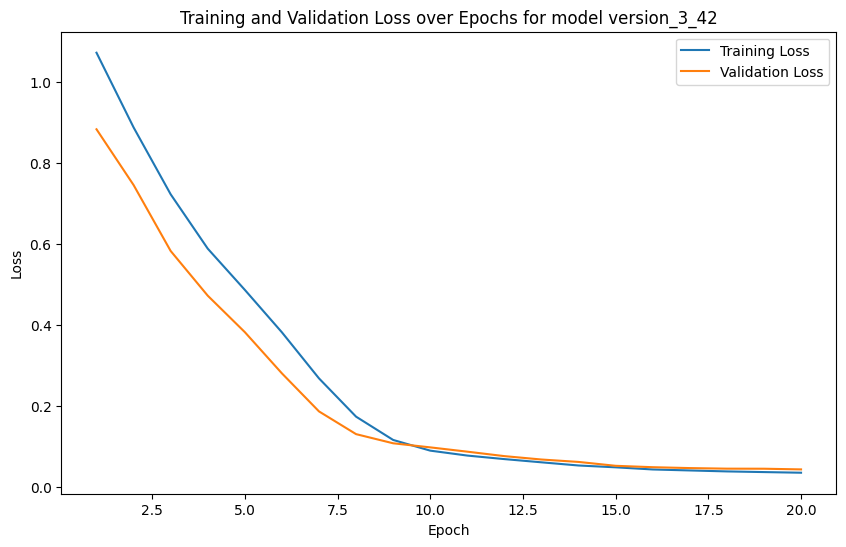

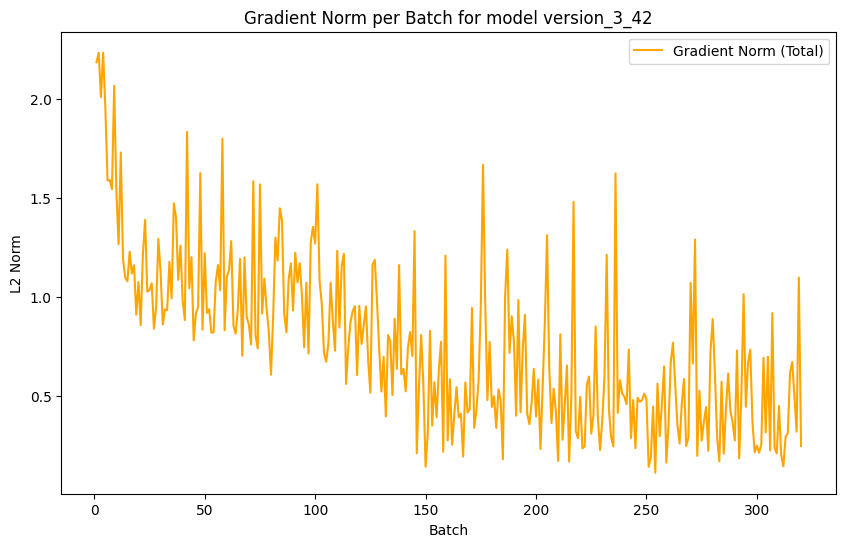

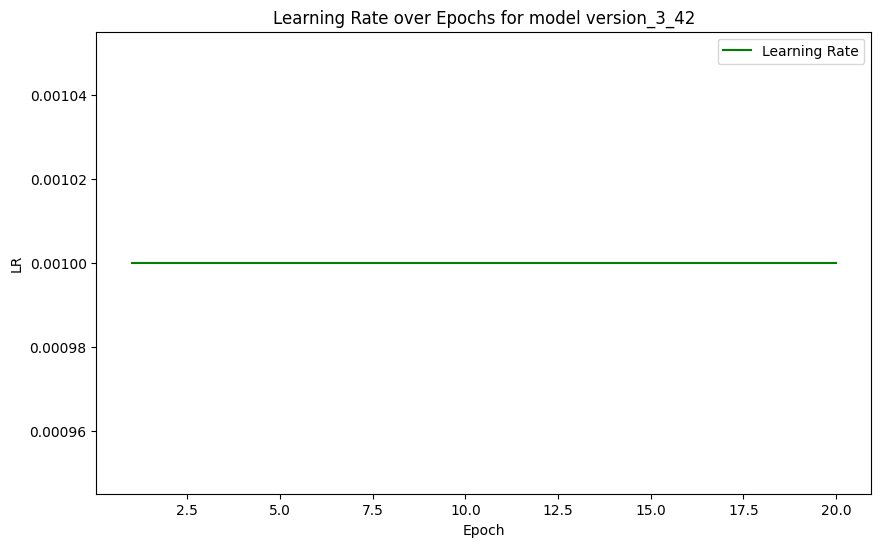

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_3_52 3 2 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.9510, Val Loss=0.8266, Grad Norm=1.4486, LR=0.00010]


New best model saved with val loss: 0.8266


Epoch 2/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.8124, Val Loss=0.6608, Grad Norm=0.9426, LR=0.00010]


New best model saved with val loss: 0.6608


Epoch 3/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, Train Loss=0.6547, Val Loss=0.5195, Grad Norm=0.9559, LR=0.00010]


New best model saved with val loss: 0.5195


Epoch 4/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.5094, Val Loss=0.3944, Grad Norm=1.0284, LR=0.00010]


New best model saved with val loss: 0.3944


Epoch 5/20: 100%|██████████| 32/32 [00:14<00:00,  2.24batch/s, Train Loss=0.3725, Val Loss=0.2754, Grad Norm=2.0028, LR=0.00010]


New best model saved with val loss: 0.2754


Epoch 6/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, Train Loss=0.2530, Val Loss=0.1848, Grad Norm=0.5548, LR=0.00010]


New best model saved with val loss: 0.1848


Epoch 7/20: 100%|██████████| 32/32 [00:14<00:00,  2.22batch/s, Train Loss=0.1707, Val Loss=0.1253, Grad Norm=0.6718, LR=0.00010]


New best model saved with val loss: 0.1253


Epoch 8/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.1145, Val Loss=0.0942, Grad Norm=1.0487, LR=0.00010]


New best model saved with val loss: 0.0942


Epoch 9/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0828, Val Loss=0.0799, Grad Norm=1.2527, LR=0.00010]


New best model saved with val loss: 0.0799


Epoch 10/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, Train Loss=0.0692, Val Loss=0.0632, Grad Norm=2.0268, LR=0.00010]


New best model saved with val loss: 0.0632


Epoch 11/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0531, Val Loss=0.0543, Grad Norm=0.7357, LR=0.00010]


New best model saved with val loss: 0.0543


Epoch 12/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0454, Val Loss=0.0511, Grad Norm=0.1334, LR=0.00010]


New best model saved with val loss: 0.0511


Epoch 13/20: 100%|██████████| 32/32 [00:13<00:00,  2.29batch/s, Train Loss=0.0427, Val Loss=0.0503, Grad Norm=0.6972, LR=0.00010]


New best model saved with val loss: 0.0503


Epoch 14/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.0401, Val Loss=0.0473, Grad Norm=0.2940, LR=0.00010]


New best model saved with val loss: 0.0473


Epoch 16/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0357, Val Loss=0.0465, Grad Norm=0.4634, LR=0.00010]


New best model saved with val loss: 0.0465


Epoch 18/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0343, Val Loss=0.0448, Grad Norm=0.2829, LR=0.00010]


New best model saved with val loss: 0.0448


Epoch 19/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0335, Val Loss=0.0439, Grad Norm=2.2238, LR=0.00010]


New best model saved with val loss: 0.0439


Epoch 20/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.0347, Val Loss=0.0437, Grad Norm=1.3310, LR=0.00010]


New best model saved with val loss: 0.0437

=== Final Metrics ===
Final Train Loss: 0.0347
Final Val Loss: 0.0437
Generalization Gap: 0.0090
Best Val Epoch: 20
Training Time: 4.70 minutes
Trainable Parameters: 394


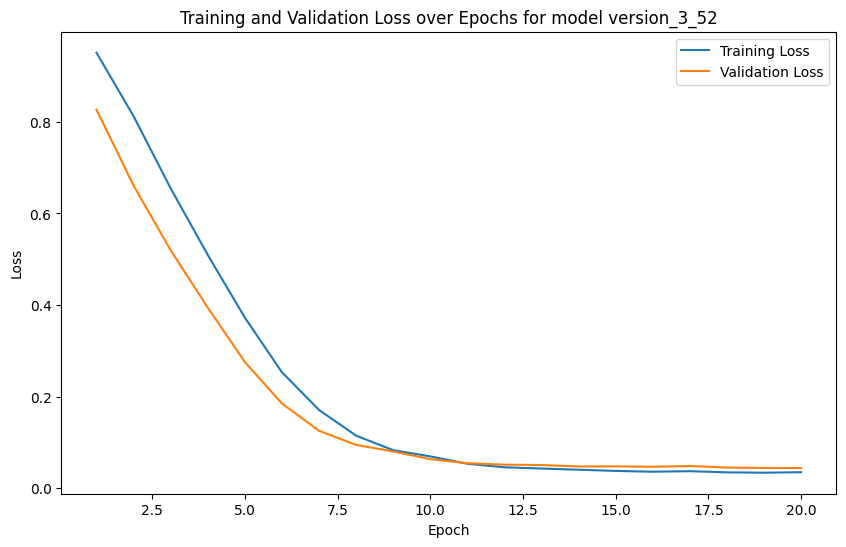

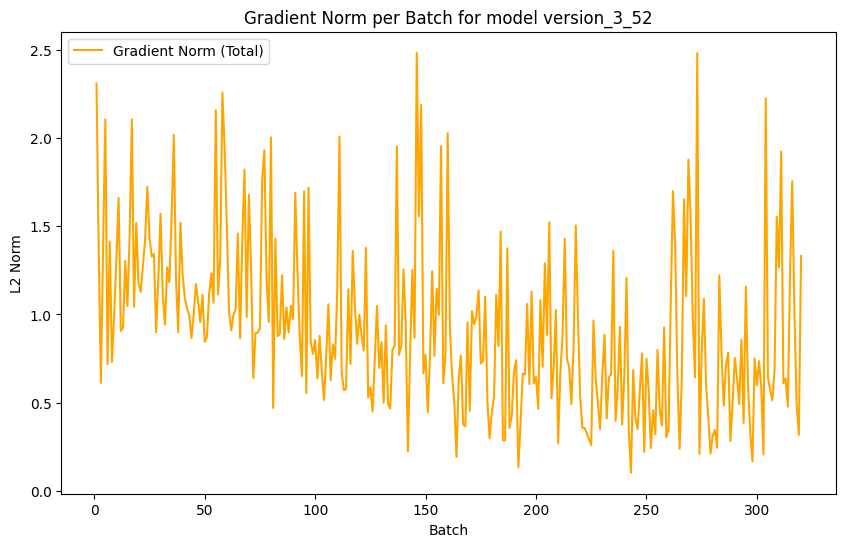

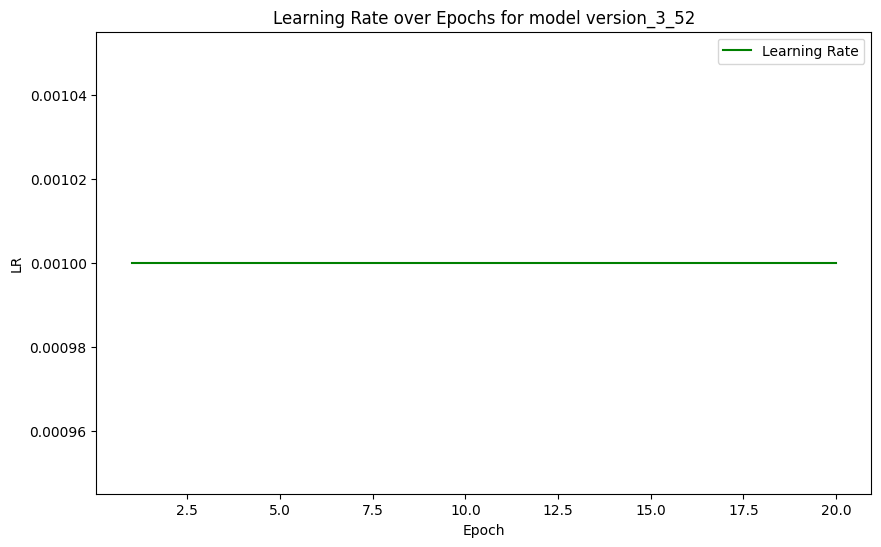

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_3_62 3 2 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.9856, Val Loss=0.8397, Grad Norm=1.1920, LR=0.00010]


New best model saved with val loss: 0.8397


Epoch 2/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.8377, Val Loss=0.6893, Grad Norm=1.5297, LR=0.00010]


New best model saved with val loss: 0.6893


Epoch 3/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.6679, Val Loss=0.5182, Grad Norm=1.4372, LR=0.00010]


New best model saved with val loss: 0.5182


Epoch 4/20: 100%|██████████| 32/32 [00:13<00:00,  2.32batch/s, Train Loss=0.4995, Val Loss=0.3712, Grad Norm=2.7723, LR=0.00010]


New best model saved with val loss: 0.3712


Epoch 5/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.3511, Val Loss=0.2538, Grad Norm=1.1737, LR=0.00010]


New best model saved with val loss: 0.2538


Epoch 6/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.2398, Val Loss=0.1655, Grad Norm=1.5089, LR=0.00010]


New best model saved with val loss: 0.1655


Epoch 7/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.1552, Val Loss=0.1147, Grad Norm=1.8440, LR=0.00010]


New best model saved with val loss: 0.1147


Epoch 8/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.1075, Val Loss=0.0845, Grad Norm=1.4441, LR=0.00010]


New best model saved with val loss: 0.0845


Epoch 9/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0777, Val Loss=0.0696, Grad Norm=0.6198, LR=0.00010]


New best model saved with val loss: 0.0696


Epoch 10/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0628, Val Loss=0.0593, Grad Norm=0.5385, LR=0.00010]


New best model saved with val loss: 0.0593


Epoch 11/20: 100%|██████████| 32/32 [00:14<00:00,  2.26batch/s, Train Loss=0.0518, Val Loss=0.0536, Grad Norm=0.9865, LR=0.00010]


New best model saved with val loss: 0.0536


Epoch 12/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0472, Val Loss=0.0510, Grad Norm=0.2691, LR=0.00010]


New best model saved with val loss: 0.0510


Epoch 13/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0429, Val Loss=0.0482, Grad Norm=0.7905, LR=0.00010]


New best model saved with val loss: 0.0482


Epoch 15/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0391, Val Loss=0.0454, Grad Norm=0.7663, LR=0.00010]


New best model saved with val loss: 0.0454


Epoch 16/20: 100%|██████████| 32/32 [00:13<00:00,  2.29batch/s, Train Loss=0.0371, Val Loss=0.0448, Grad Norm=0.6466, LR=0.00010]


New best model saved with val loss: 0.0448


Epoch 17/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, Train Loss=0.0359, Val Loss=0.0444, Grad Norm=2.0725, LR=0.00010]


New best model saved with val loss: 0.0444


Epoch 20/20: 100%|██████████| 32/32 [00:14<00:00,  2.27batch/s, Train Loss=0.0340, Val Loss=0.0437, Grad Norm=0.6654, LR=0.00010]


New best model saved with val loss: 0.0437

=== Final Metrics ===
Final Train Loss: 0.0340
Final Val Loss: 0.0437
Generalization Gap: 0.0097
Best Val Epoch: 20
Training Time: 4.69 minutes
Trainable Parameters: 394


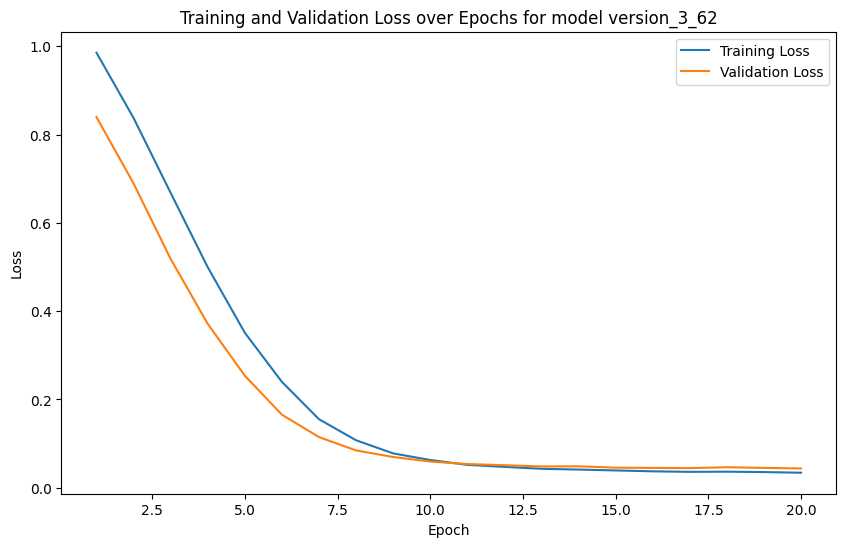

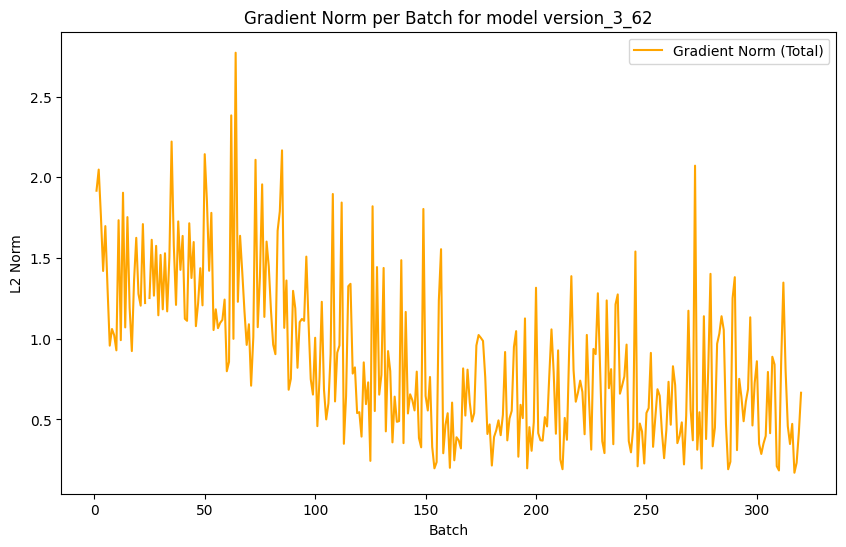

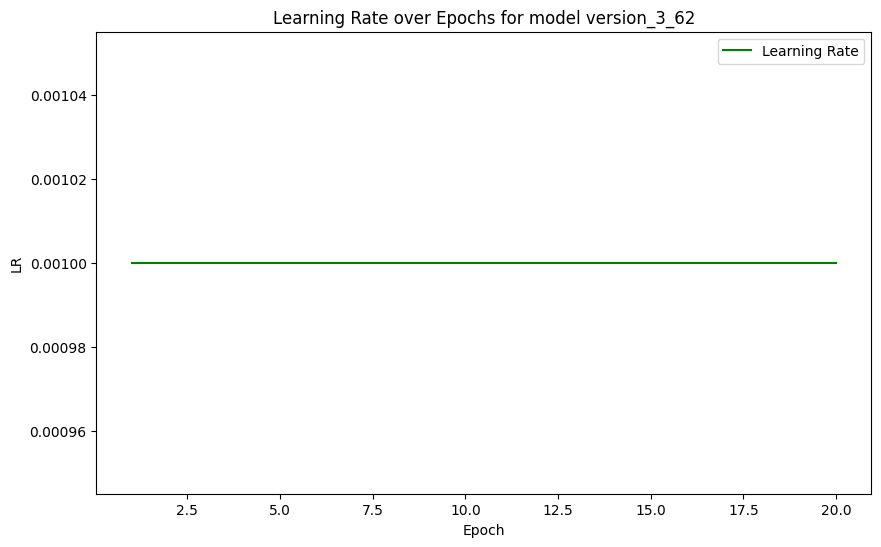

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_4_42 3 3 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=1.0896, Val Loss=0.9294, Grad Norm=2.0915, LR=0.00010]


New best model saved with val loss: 0.9294


Epoch 2/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.9063, Val Loss=0.8050, Grad Norm=1.1453, LR=0.00010]


New best model saved with val loss: 0.8050


Epoch 3/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.8011, Val Loss=0.6850, Grad Norm=1.5883, LR=0.00010]


New best model saved with val loss: 0.6850


Epoch 4/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.6613, Val Loss=0.5244, Grad Norm=1.0995, LR=0.00010]


New best model saved with val loss: 0.5244


Epoch 5/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.4847, Val Loss=0.3471, Grad Norm=2.8223, LR=0.00010]


New best model saved with val loss: 0.3471


Epoch 6/20: 100%|██████████| 32/32 [00:16<00:00,  1.93batch/s, Train Loss=0.3018, Val Loss=0.1953, Grad Norm=1.0048, LR=0.00010]


New best model saved with val loss: 0.1953


Epoch 7/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.1672, Val Loss=0.1236, Grad Norm=0.5928, LR=0.00010]


New best model saved with val loss: 0.1236


Epoch 8/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.1070, Val Loss=0.0983, Grad Norm=0.6203, LR=0.00010]


New best model saved with val loss: 0.0983


Epoch 9/20: 100%|██████████| 32/32 [00:17<00:00,  1.88batch/s, Train Loss=0.0863, Val Loss=0.0870, Grad Norm=1.0922, LR=0.00010]


New best model saved with val loss: 0.0870


Epoch 10/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0766, Val Loss=0.0765, Grad Norm=0.5531, LR=0.00010]


New best model saved with val loss: 0.0765


Epoch 11/20: 100%|██████████| 32/32 [00:16<00:00,  1.93batch/s, Train Loss=0.0669, Val Loss=0.0706, Grad Norm=0.9511, LR=0.00010]


New best model saved with val loss: 0.0706


Epoch 12/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0607, Val Loss=0.0656, Grad Norm=0.3794, LR=0.00010]


New best model saved with val loss: 0.0656


Epoch 13/20: 100%|██████████| 32/32 [00:17<00:00,  1.88batch/s, Train Loss=0.0569, Val Loss=0.0602, Grad Norm=1.3686, LR=0.00010]


New best model saved with val loss: 0.0602


Epoch 14/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.0530, Val Loss=0.0555, Grad Norm=0.9251, LR=0.00010]


New best model saved with val loss: 0.0555


Epoch 15/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0501, Val Loss=0.0526, Grad Norm=0.8024, LR=0.00010]


New best model saved with val loss: 0.0526


Epoch 16/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0457, Val Loss=0.0488, Grad Norm=0.5287, LR=0.00010]


New best model saved with val loss: 0.0488


Epoch 17/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.0430, Val Loss=0.0467, Grad Norm=0.5352, LR=0.00010]


New best model saved with val loss: 0.0467


Epoch 19/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0399, Val Loss=0.0437, Grad Norm=0.6088, LR=0.00010]


New best model saved with val loss: 0.0437


Epoch 20/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0389, Val Loss=0.0425, Grad Norm=0.3784, LR=0.00010]


New best model saved with val loss: 0.0425

=== Final Metrics ===
Final Train Loss: 0.0389
Final Val Loss: 0.0425
Generalization Gap: 0.0036
Best Val Epoch: 20
Training Time: 5.60 minutes
Trainable Parameters: 397


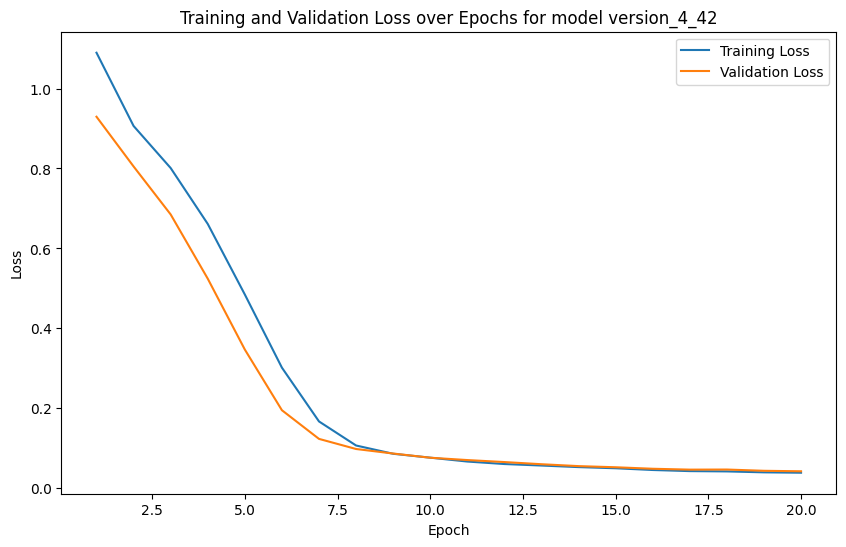

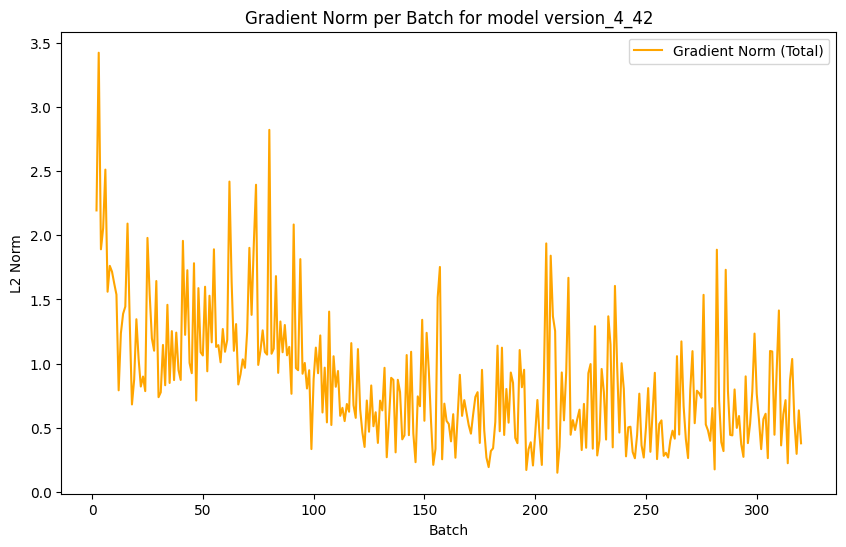

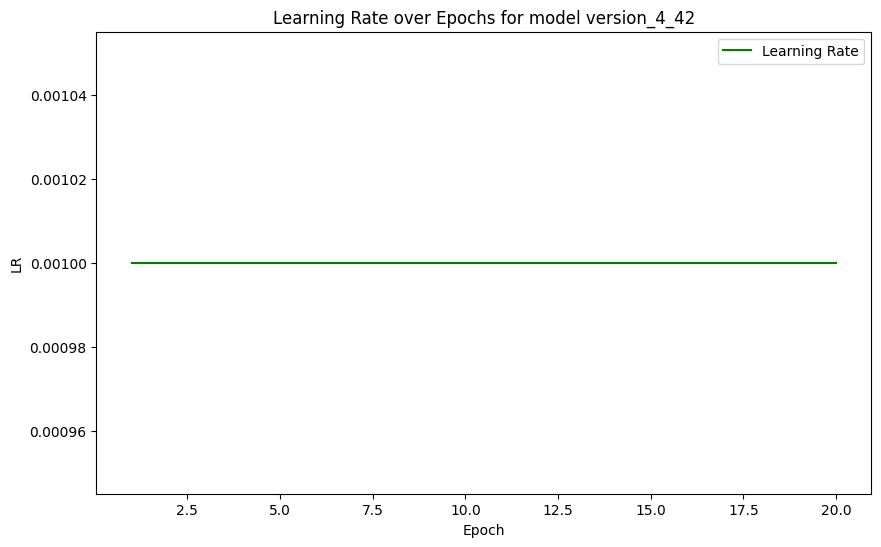

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_4_52 3 3 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=1.0061, Val Loss=0.8812, Grad Norm=1.4622, LR=0.00010]


New best model saved with val loss: 0.8812


Epoch 2/20: 100%|██████████| 32/32 [00:17<00:00,  1.88batch/s, Train Loss=0.8485, Val Loss=0.6844, Grad Norm=1.2635, LR=0.00010]


New best model saved with val loss: 0.6844


Epoch 3/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.6565, Val Loss=0.5073, Grad Norm=1.2881, LR=0.00010]


New best model saved with val loss: 0.5073


Epoch 4/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.4830, Val Loss=0.3456, Grad Norm=0.7961, LR=0.00010]


New best model saved with val loss: 0.3456


Epoch 5/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.3339, Val Loss=0.2435, Grad Norm=1.4435, LR=0.00010]


New best model saved with val loss: 0.2435


Epoch 6/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.2445, Val Loss=0.1764, Grad Norm=0.8043, LR=0.00010]


New best model saved with val loss: 0.1764


Epoch 7/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.1811, Val Loss=0.1326, Grad Norm=0.4339, LR=0.00010]


New best model saved with val loss: 0.1326


Epoch 8/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.1353, Val Loss=0.1040, Grad Norm=1.4983, LR=0.00010]


New best model saved with val loss: 0.1040


Epoch 9/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.1052, Val Loss=0.0876, Grad Norm=0.3978, LR=0.00010]


New best model saved with val loss: 0.0876


Epoch 10/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0847, Val Loss=0.0758, Grad Norm=1.1016, LR=0.00010]


New best model saved with val loss: 0.0758


Epoch 11/20: 100%|██████████| 32/32 [00:16<00:00,  1.93batch/s, Train Loss=0.0688, Val Loss=0.0659, Grad Norm=0.2898, LR=0.00010]


New best model saved with val loss: 0.0659


Epoch 12/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.0592, Val Loss=0.0606, Grad Norm=0.4333, LR=0.00010]


New best model saved with val loss: 0.0606


Epoch 13/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0532, Val Loss=0.0597, Grad Norm=0.8973, LR=0.00010]


New best model saved with val loss: 0.0597


Epoch 14/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0490, Val Loss=0.0573, Grad Norm=0.7147, LR=0.00010]


New best model saved with val loss: 0.0573


Epoch 15/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0470, Val Loss=0.0554, Grad Norm=1.0481, LR=0.00010]


New best model saved with val loss: 0.0554


Epoch 16/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0436, Val Loss=0.0532, Grad Norm=1.0202, LR=0.00010]


New best model saved with val loss: 0.0532


Epoch 17/20: 100%|██████████| 32/32 [00:17<00:00,  1.87batch/s, Train Loss=0.0420, Val Loss=0.0523, Grad Norm=0.1831, LR=0.00010]


New best model saved with val loss: 0.0523


Epoch 18/20: 100%|██████████| 32/32 [00:17<00:00,  1.88batch/s, Train Loss=0.0417, Val Loss=0.0523, Grad Norm=0.8167, LR=0.00010]


New best model saved with val loss: 0.0523


Epoch 19/20: 100%|██████████| 32/32 [00:17<00:00,  1.80batch/s, Train Loss=0.0404, Val Loss=0.0486, Grad Norm=0.3625, LR=0.00010]


New best model saved with val loss: 0.0486


Epoch 20/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.0380, Val Loss=0.0466, Grad Norm=1.2059, LR=0.00010]


New best model saved with val loss: 0.0466

=== Final Metrics ===
Final Train Loss: 0.0380
Final Val Loss: 0.0466
Generalization Gap: 0.0086
Best Val Epoch: 20
Training Time: 5.62 minutes
Trainable Parameters: 397


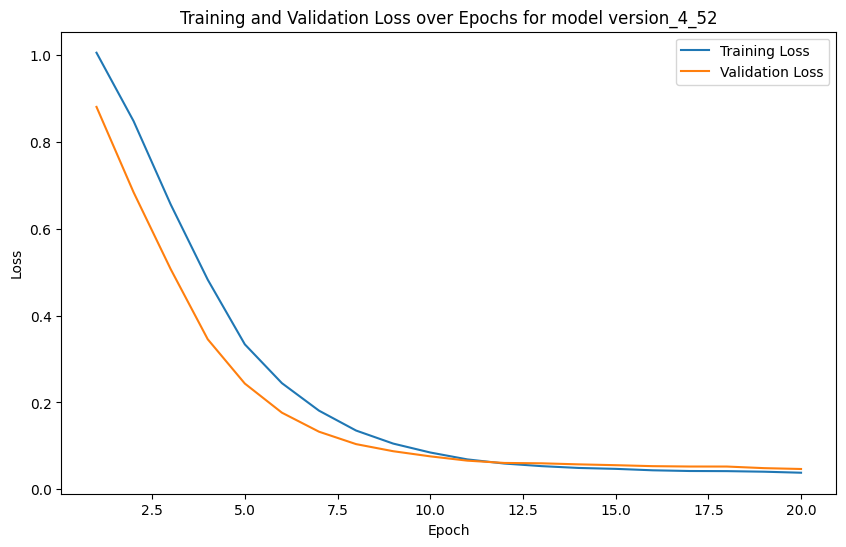

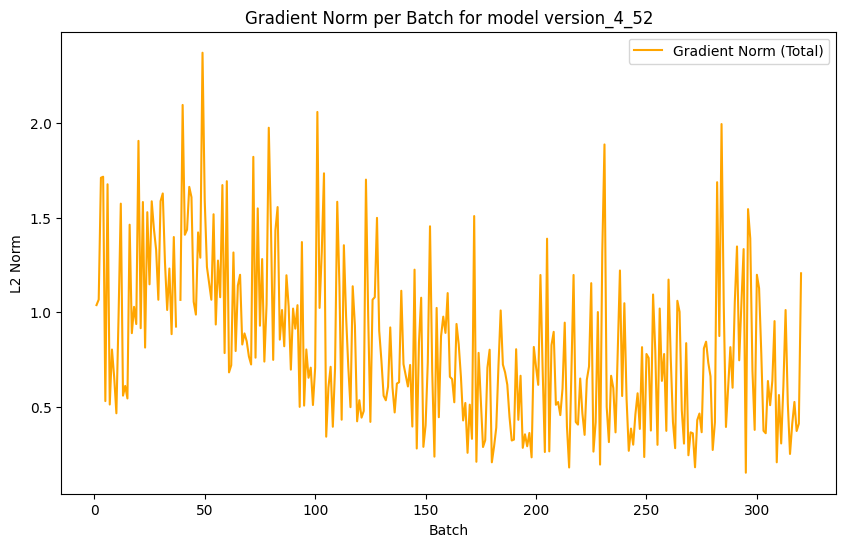

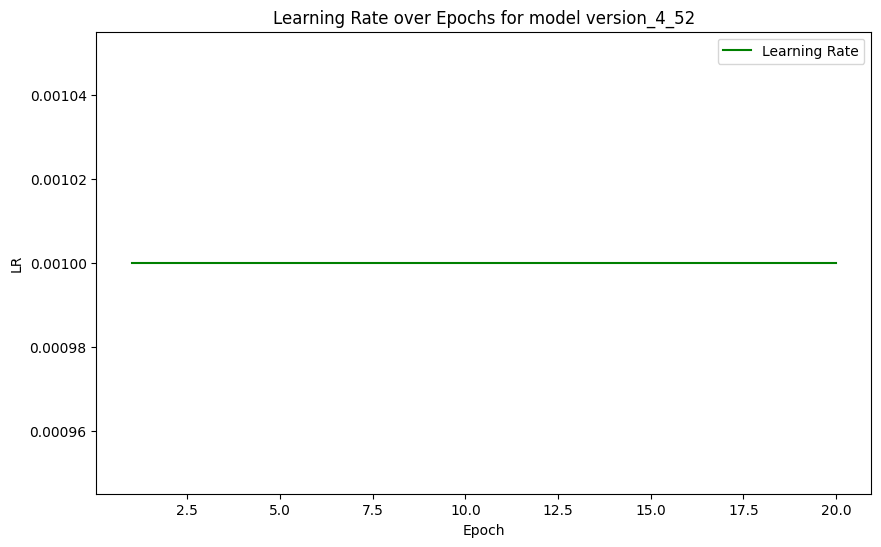

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_4_62 3 3 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:17<00:00,  1.84batch/s, Train Loss=0.9955, Val Loss=0.8700, Grad Norm=1.8738, LR=0.00010]


New best model saved with val loss: 0.8700


Epoch 2/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.8525, Val Loss=0.6846, Grad Norm=1.2604, LR=0.00010]


New best model saved with val loss: 0.6846


Epoch 3/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.6392, Val Loss=0.4731, Grad Norm=1.0945, LR=0.00010]


New best model saved with val loss: 0.4731


Epoch 4/20: 100%|██████████| 32/32 [00:17<00:00,  1.84batch/s, Train Loss=0.4646, Val Loss=0.3528, Grad Norm=1.2498, LR=0.00010]


New best model saved with val loss: 0.3528


Epoch 5/20: 100%|██████████| 32/32 [00:17<00:00,  1.88batch/s, Train Loss=0.3551, Val Loss=0.2688, Grad Norm=1.0813, LR=0.00010]


New best model saved with val loss: 0.2688


Epoch 6/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.2718, Val Loss=0.2199, Grad Norm=0.7359, LR=0.00010]


New best model saved with val loss: 0.2199


Epoch 7/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.2141, Val Loss=0.1820, Grad Norm=0.7477, LR=0.00010]


New best model saved with val loss: 0.1820


Epoch 8/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.1647, Val Loss=0.1488, Grad Norm=0.8457, LR=0.00010]


New best model saved with val loss: 0.1488


Epoch 9/20: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, Train Loss=0.1281, Val Loss=0.1276, Grad Norm=0.3844, LR=0.00010]


New best model saved with val loss: 0.1276


Epoch 10/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.1080, Val Loss=0.1084, Grad Norm=0.4683, LR=0.00010]


New best model saved with val loss: 0.1084


Epoch 11/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.0940, Val Loss=0.1027, Grad Norm=1.5404, LR=0.00010]


New best model saved with val loss: 0.1027


Epoch 12/20: 100%|██████████| 32/32 [00:17<00:00,  1.86batch/s, Train Loss=0.0832, Val Loss=0.0822, Grad Norm=0.1807, LR=0.00010]


New best model saved with val loss: 0.0822


Epoch 13/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0697, Val Loss=0.0733, Grad Norm=0.3240, LR=0.00010]


New best model saved with val loss: 0.0733


Epoch 14/20: 100%|██████████| 32/32 [00:17<00:00,  1.87batch/s, Train Loss=0.0610, Val Loss=0.0630, Grad Norm=0.7289, LR=0.00010]


New best model saved with val loss: 0.0630


Epoch 15/20: 100%|██████████| 32/32 [00:16<00:00,  1.92batch/s, Train Loss=0.0533, Val Loss=0.0557, Grad Norm=0.9230, LR=0.00010]


New best model saved with val loss: 0.0557


Epoch 16/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.0486, Val Loss=0.0525, Grad Norm=0.2926, LR=0.00010]


New best model saved with val loss: 0.0525


Epoch 17/20: 100%|██████████| 32/32 [00:16<00:00,  1.89batch/s, Train Loss=0.0449, Val Loss=0.0480, Grad Norm=0.3982, LR=0.00010]


New best model saved with val loss: 0.0480


Epoch 18/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0411, Val Loss=0.0463, Grad Norm=0.7522, LR=0.00010]


New best model saved with val loss: 0.0463


Epoch 19/20: 100%|██████████| 32/32 [00:16<00:00,  1.93batch/s, Train Loss=0.0387, Val Loss=0.0437, Grad Norm=0.2786, LR=0.00010]


New best model saved with val loss: 0.0437


Epoch 20/20: 100%|██████████| 32/32 [00:16<00:00,  1.91batch/s, Train Loss=0.0371, Val Loss=0.0427, Grad Norm=0.3659, LR=0.00010]


New best model saved with val loss: 0.0427

=== Final Metrics ===
Final Train Loss: 0.0371
Final Val Loss: 0.0427
Generalization Gap: 0.0056
Best Val Epoch: 20
Training Time: 5.64 minutes
Trainable Parameters: 397


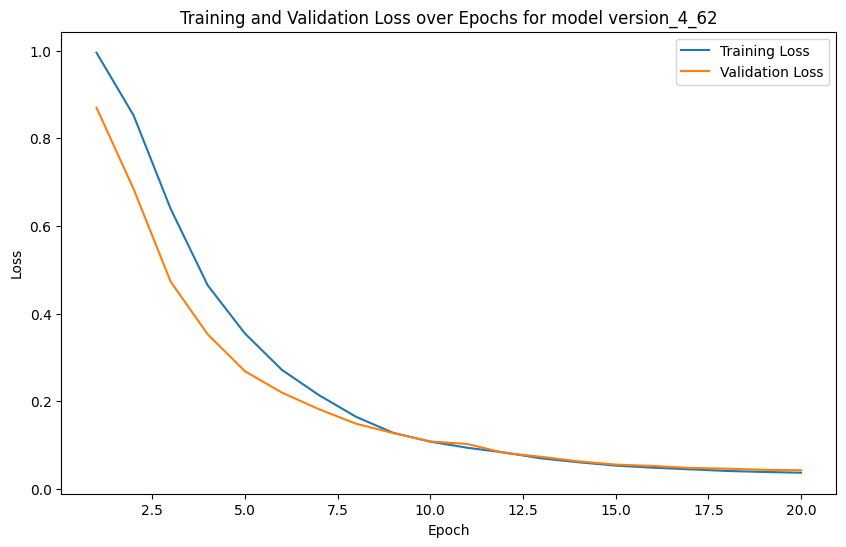

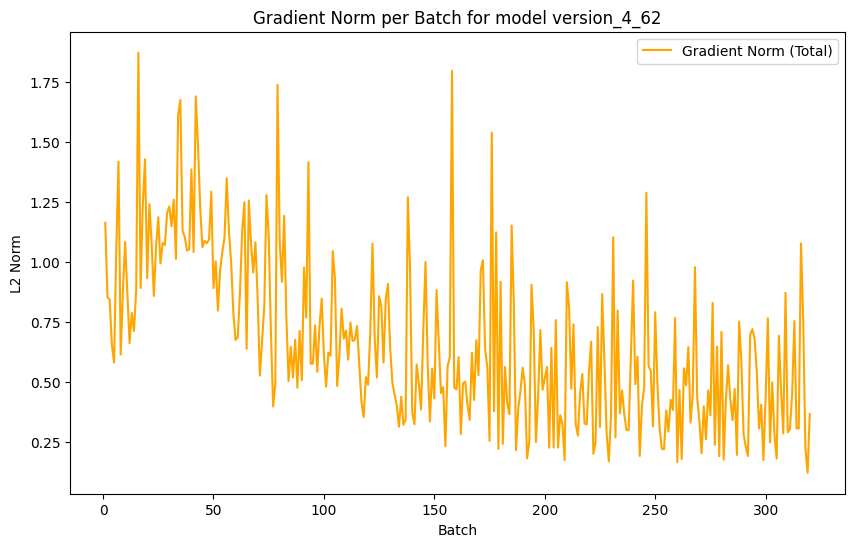

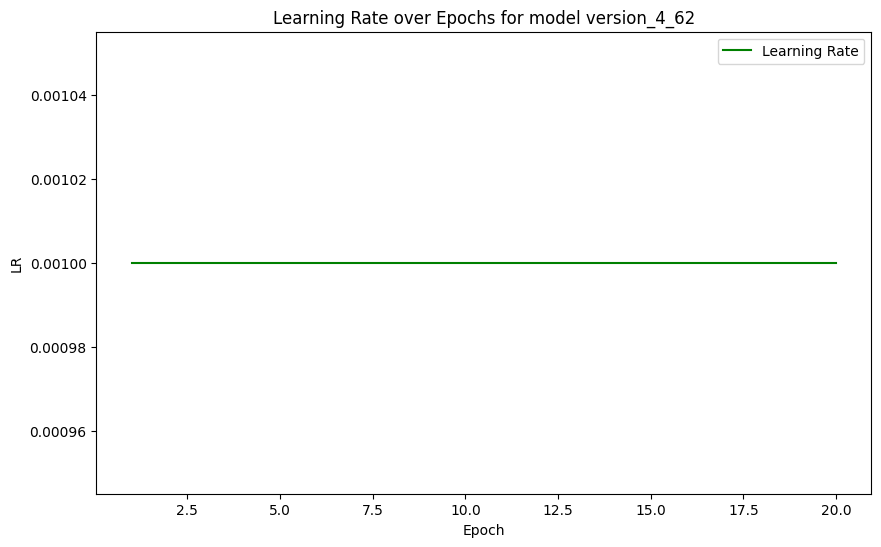

In [ ]:
l = [....]
c = ....

for num_qubit in range(....):
    for layers in range(....):
        c += 1

        for rs in l:
            # =====================
            # 0. MODEL CONFIGURATION
            # =====================
            # model_name = version_1 for model 1 and 1_1 for model 1 with random seed 1 
            model_name = f"version_{c}_{rs}" 

            # General settings
            USE_GPU = True
            BATCH_SIZE = ....
            INPUT_DIM = ....
            HIDDEN_DIM = ....
            QUANTUM_OUTPUT_DIM = ....
            POST_HIDDEN_DIM = ....
            FINAL_OUTPUT_DIM = ....
            NUM_SAMPLES = ....

            # Quantum settings
            NUM_QUBITS = num_qubit
            NUM_LAYERS = layers
            RANDOM_SEED = rs  # Set your desired fixed seed


            DIFF_METHOD = ....


            # =====================
            # 1. Random Seed Configuration
            # =====================

            # Set fixed seed for reproducibility
            torch.manual_seed(RANDOM_SEED)
            torch.cuda.manual_seed_all(RANDOM_SEED)  # if using multiple GPUs

            print(f"Random Seed set to: {RANDOM_SEED}")


            # =====================
            # 0. TRAINING CONFIGURATION
            # =====================

            NUM_EPOCHS = ....
            EARLY_STOP_PATIENCE = ....
            BATCH_SIZE = BATCH_SIZE
            LR_PRE_ENCODER = ....
            LR_QUANTUM = ....
            LR_POST_DECODER = ....
            WEIGHT_DECAY = ....
            LR_SCHEDULER_FACTOR = ....
            LR_SCHEDULER_PATIENCE = ....
            SAVE_MODEL_PATH = f"{model_name}.pth"

            # ===========================
            # Random State for Reproducibility
            # ===========================
            RANDOM_STATE = RANDOM_SEED  # Or any other integer of your choice

            # Setting seeds for reproducibility
            torch.manual_seed(RANDOM_STATE)
            np.random.seed(RANDOM_STATE)
            random.seed(RANDOM_STATE)

            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(RANDOM_STATE)  # For CUDA

            print(model_name,NUM_QUBITS,NUM_LAYERS, RANDOM_SEED)
            run()



/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_5_42 2 4 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:12<00:00,  2.60batch/s, Train Loss=0.9511, Val Loss=0.8454, Grad Norm=1.2555, LR=0.00010]


New best model saved with val loss: 0.8454


Epoch 2/20: 100%|██████████| 32/32 [00:11<00:00,  2.69batch/s, Train Loss=0.8628, Val Loss=0.7649, Grad Norm=1.0700, LR=0.00010]


New best model saved with val loss: 0.7649


Epoch 3/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.7702, Val Loss=0.6687, Grad Norm=0.8464, LR=0.00010]


New best model saved with val loss: 0.6687


Epoch 4/20: 100%|██████████| 32/32 [00:12<00:00,  2.66batch/s, Train Loss=0.6730, Val Loss=0.5703, Grad Norm=0.9589, LR=0.00010]


New best model saved with val loss: 0.5703


Epoch 5/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.5711, Val Loss=0.4554, Grad Norm=0.8829, LR=0.00010]


New best model saved with val loss: 0.4554


Epoch 6/20: 100%|██████████| 32/32 [00:12<00:00,  2.60batch/s, Train Loss=0.4384, Val Loss=0.3369, Grad Norm=0.8834, LR=0.00010]


New best model saved with val loss: 0.3369


Epoch 7/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.3198, Val Loss=0.2309, Grad Norm=1.2514, LR=0.00010]


New best model saved with val loss: 0.2309


Epoch 8/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.2185, Val Loss=0.1604, Grad Norm=1.2040, LR=0.00010]


New best model saved with val loss: 0.1604


Epoch 9/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.1538, Val Loss=0.1225, Grad Norm=0.4480, LR=0.00010]


New best model saved with val loss: 0.1225


Epoch 10/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.1181, Val Loss=0.1018, Grad Norm=0.9921, LR=0.00010]


New best model saved with val loss: 0.1018


Epoch 11/20: 100%|██████████| 32/32 [00:12<00:00,  2.56batch/s, Train Loss=0.0964, Val Loss=0.0850, Grad Norm=0.3821, LR=0.00010]


New best model saved with val loss: 0.0850


Epoch 12/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.0801, Val Loss=0.0732, Grad Norm=0.9779, LR=0.00010]


New best model saved with val loss: 0.0732


Epoch 13/20: 100%|██████████| 32/32 [00:12<00:00,  2.51batch/s, Train Loss=0.0693, Val Loss=0.0652, Grad Norm=0.5063, LR=0.00010]


New best model saved with val loss: 0.0652


Epoch 14/20: 100%|██████████| 32/32 [00:12<00:00,  2.59batch/s, Train Loss=0.0600, Val Loss=0.0595, Grad Norm=0.5142, LR=0.00010]


New best model saved with val loss: 0.0595


Epoch 15/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0537, Val Loss=0.0554, Grad Norm=0.4730, LR=0.00010]


New best model saved with val loss: 0.0554


Epoch 16/20: 100%|██████████| 32/32 [00:12<00:00,  2.60batch/s, Train Loss=0.0484, Val Loss=0.0520, Grad Norm=0.4429, LR=0.00010]


New best model saved with val loss: 0.0520


Epoch 17/20: 100%|██████████| 32/32 [00:12<00:00,  2.57batch/s, Train Loss=0.0445, Val Loss=0.0515, Grad Norm=1.0305, LR=0.00010]


New best model saved with val loss: 0.0515


Epoch 18/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0413, Val Loss=0.0465, Grad Norm=0.8129, LR=0.00010]


New best model saved with val loss: 0.0465


Epoch 19/20: 100%|██████████| 32/32 [00:12<00:00,  2.56batch/s, Train Loss=0.0385, Val Loss=0.0445, Grad Norm=1.2315, LR=0.00010]


New best model saved with val loss: 0.0445


Epoch 20/20: 100%|██████████| 32/32 [00:12<00:00,  2.50batch/s, Train Loss=0.0374, Val Loss=0.0438, Grad Norm=0.3805, LR=0.00010]


New best model saved with val loss: 0.0438

=== Final Metrics ===
Final Train Loss: 0.0374
Final Val Loss: 0.0438
Generalization Gap: 0.0064
Best Val Epoch: 20
Training Time: 4.10 minutes
Trainable Parameters: 347


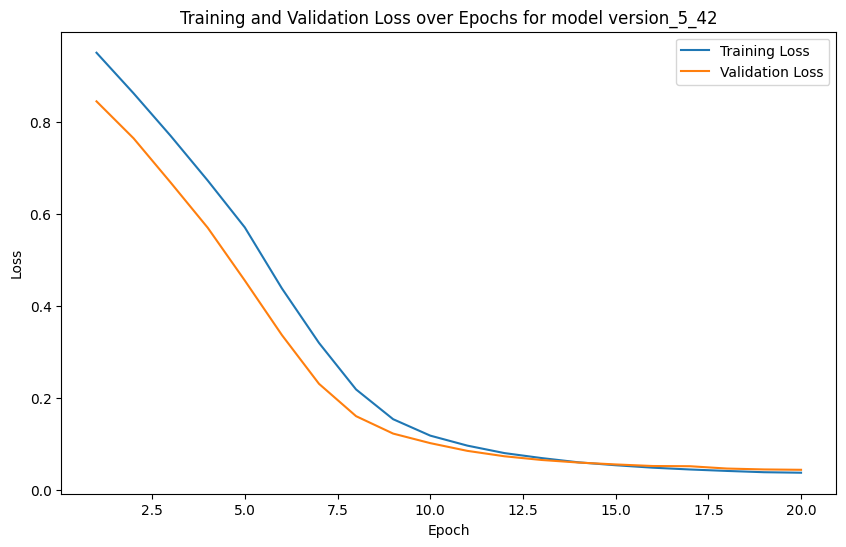

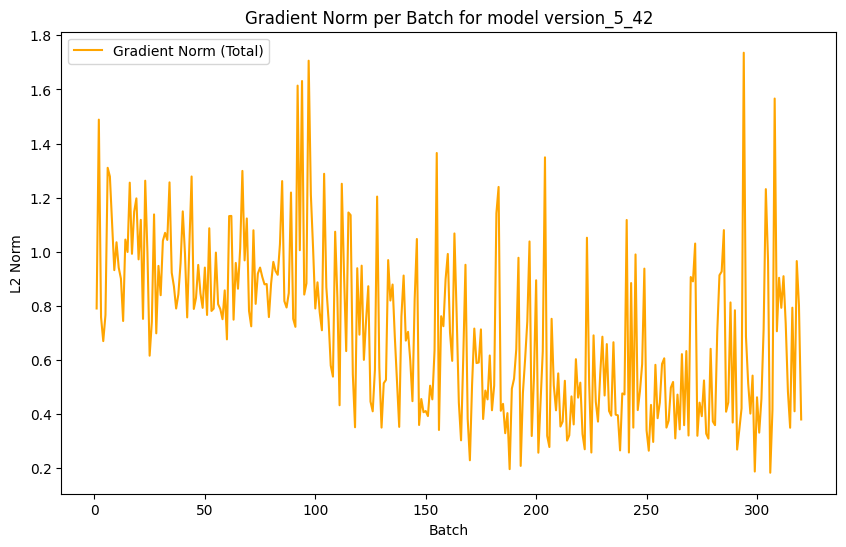

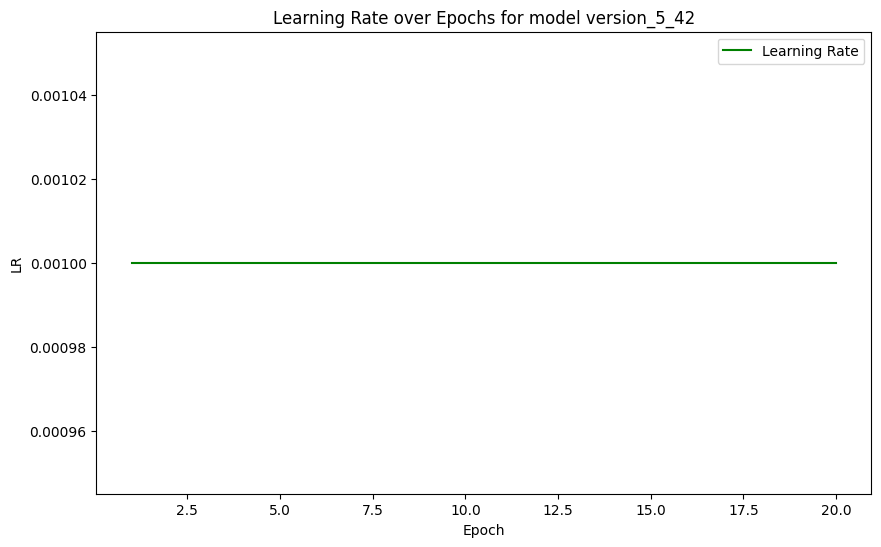

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_5_52 2 4 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:12<00:00,  2.59batch/s, Train Loss=0.9062, Val Loss=0.7389, Grad Norm=1.9304, LR=0.00010]


New best model saved with val loss: 0.7389


Epoch 2/20: 100%|██████████| 32/32 [00:12<00:00,  2.58batch/s, Train Loss=0.7129, Val Loss=0.5566, Grad Norm=1.5756, LR=0.00010]


New best model saved with val loss: 0.5566


Epoch 3/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.5442, Val Loss=0.4197, Grad Norm=0.9935, LR=0.00010]


New best model saved with val loss: 0.4197


Epoch 4/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.4217, Val Loss=0.3253, Grad Norm=1.1213, LR=0.00010]


New best model saved with val loss: 0.3253


Epoch 5/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.3335, Val Loss=0.2580, Grad Norm=1.0511, LR=0.00010]


New best model saved with val loss: 0.2580


Epoch 6/20: 100%|██████████| 32/32 [00:12<00:00,  2.57batch/s, Train Loss=0.2615, Val Loss=0.1957, Grad Norm=1.0340, LR=0.00010]


New best model saved with val loss: 0.1957


Epoch 7/20: 100%|██████████| 32/32 [00:12<00:00,  2.59batch/s, Train Loss=0.1938, Val Loss=0.1458, Grad Norm=1.0569, LR=0.00010]


New best model saved with val loss: 0.1458


Epoch 8/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.1442, Val Loss=0.1114, Grad Norm=1.2923, LR=0.00010]


New best model saved with val loss: 0.1114


Epoch 9/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.1079, Val Loss=0.0864, Grad Norm=0.6041, LR=0.00010]


New best model saved with val loss: 0.0864


Epoch 10/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.0824, Val Loss=0.0725, Grad Norm=0.9499, LR=0.00010]


New best model saved with val loss: 0.0725


Epoch 11/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.0680, Val Loss=0.0629, Grad Norm=0.2927, LR=0.00010]


New best model saved with val loss: 0.0629


Epoch 12/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.0583, Val Loss=0.0571, Grad Norm=0.4314, LR=0.00010]


New best model saved with val loss: 0.0571


Epoch 13/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.0515, Val Loss=0.0533, Grad Norm=0.4845, LR=0.00010]


New best model saved with val loss: 0.0533


Epoch 14/20: 100%|██████████| 32/32 [00:11<00:00,  2.67batch/s, Train Loss=0.0470, Val Loss=0.0502, Grad Norm=0.2054, LR=0.00010]


New best model saved with val loss: 0.0502


Epoch 15/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.0438, Val Loss=0.0487, Grad Norm=1.1214, LR=0.00010]


New best model saved with val loss: 0.0487


Epoch 16/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.0427, Val Loss=0.0474, Grad Norm=0.9034, LR=0.00010]


New best model saved with val loss: 0.0474


Epoch 17/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.0399, Val Loss=0.0464, Grad Norm=0.7233, LR=0.00010]


New best model saved with val loss: 0.0464


Epoch 19/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.0375, Val Loss=0.0458, Grad Norm=0.5807, LR=0.00010]


New best model saved with val loss: 0.0458


Epoch 20/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.0366, Val Loss=0.0436, Grad Norm=0.5813, LR=0.00010]


New best model saved with val loss: 0.0436

=== Final Metrics ===
Final Train Loss: 0.0366
Final Val Loss: 0.0436
Generalization Gap: 0.0070
Best Val Epoch: 20
Training Time: 4.07 minutes
Trainable Parameters: 347


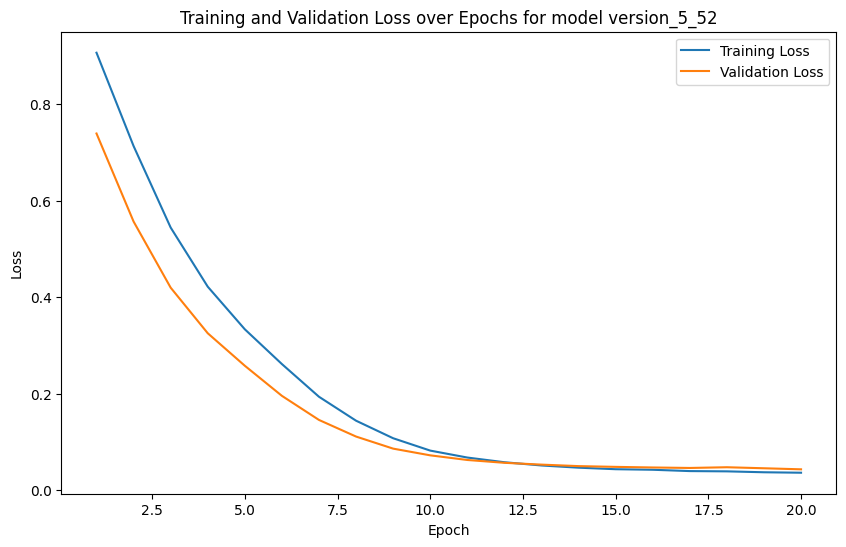

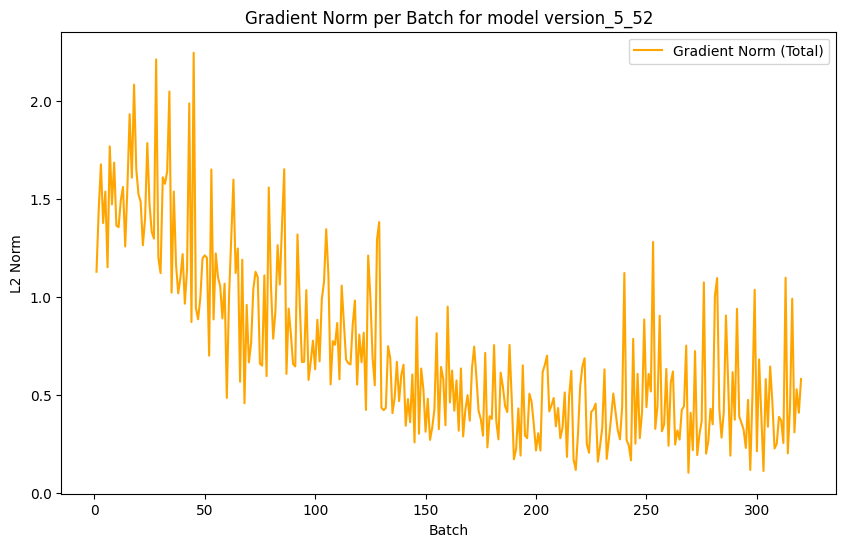

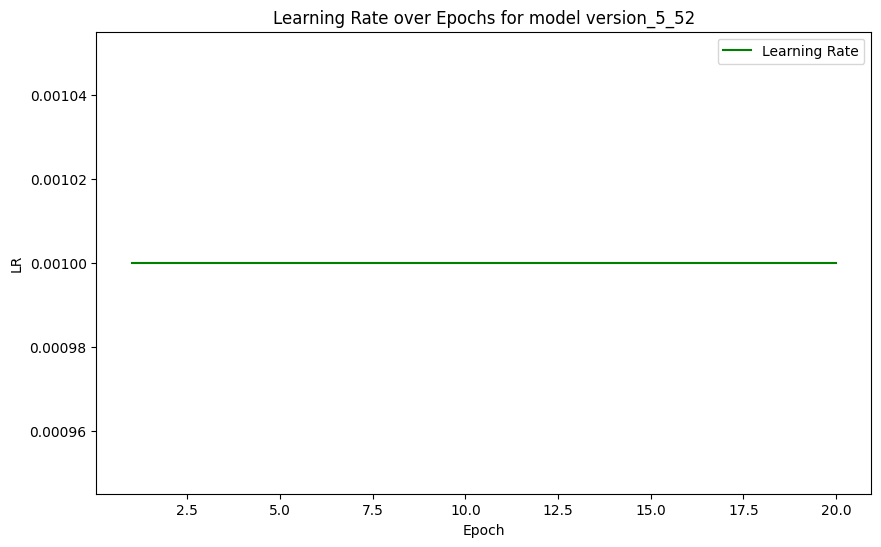

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_5_62 2 4 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.9688, Val Loss=0.7545, Grad Norm=1.5428, LR=0.00010]


New best model saved with val loss: 0.7545


Epoch 2/20: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, Train Loss=0.7585, Val Loss=0.5989, Grad Norm=1.5997, LR=0.00010]


New best model saved with val loss: 0.5989


Epoch 3/20: 100%|██████████| 32/32 [00:12<00:00,  2.65batch/s, Train Loss=0.5978, Val Loss=0.4562, Grad Norm=1.2595, LR=0.00010]


New best model saved with val loss: 0.4562


Epoch 4/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.4506, Val Loss=0.3279, Grad Norm=1.5081, LR=0.00010]


New best model saved with val loss: 0.3279


Epoch 5/20: 100%|██████████| 32/32 [00:11<00:00,  2.68batch/s, Train Loss=0.3262, Val Loss=0.2321, Grad Norm=1.3255, LR=0.00010]


New best model saved with val loss: 0.2321


Epoch 6/20: 100%|██████████| 32/32 [00:12<00:00,  2.60batch/s, Train Loss=0.2341, Val Loss=0.1714, Grad Norm=0.9832, LR=0.00010]


New best model saved with val loss: 0.1714


Epoch 7/20: 100%|██████████| 32/32 [00:12<00:00,  2.55batch/s, Train Loss=0.1684, Val Loss=0.1366, Grad Norm=1.2429, LR=0.00010]


New best model saved with val loss: 0.1366


Epoch 8/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.1259, Val Loss=0.1202, Grad Norm=1.4465, LR=0.00010]


New best model saved with val loss: 0.1202


Epoch 9/20: 100%|██████████| 32/32 [00:12<00:00,  2.55batch/s, Train Loss=0.1013, Val Loss=0.1095, Grad Norm=1.4494, LR=0.00010]


New best model saved with val loss: 0.1095


Epoch 10/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0888, Val Loss=0.1070, Grad Norm=2.4175, LR=0.00010]


New best model saved with val loss: 0.1070


Epoch 11/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0795, Val Loss=0.0913, Grad Norm=0.9932, LR=0.00010]


New best model saved with val loss: 0.0913


Epoch 12/20: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, Train Loss=0.0700, Val Loss=0.0806, Grad Norm=0.7025, LR=0.00010]


New best model saved with val loss: 0.0806


Epoch 13/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0626, Val Loss=0.0716, Grad Norm=1.4050, LR=0.00010]


New best model saved with val loss: 0.0716


Epoch 14/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0551, Val Loss=0.0618, Grad Norm=0.6965, LR=0.00010]


New best model saved with val loss: 0.0618


Epoch 15/20: 100%|██████████| 32/32 [00:12<00:00,  2.65batch/s, Train Loss=0.0477, Val Loss=0.0547, Grad Norm=1.2619, LR=0.00010]


New best model saved with val loss: 0.0547


Epoch 16/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0430, Val Loss=0.0482, Grad Norm=0.6188, LR=0.00010]


New best model saved with val loss: 0.0482


Epoch 17/20: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, Train Loss=0.0413, Val Loss=0.0460, Grad Norm=0.3791, LR=0.00010]


New best model saved with val loss: 0.0460


Epoch 18/20: 100%|██████████| 32/32 [00:12<00:00,  2.59batch/s, Train Loss=0.0386, Val Loss=0.0442, Grad Norm=0.6937, LR=0.00010]


New best model saved with val loss: 0.0442


Epoch 20/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, Train Loss=0.0361, Val Loss=0.0444, Grad Norm=0.2513, LR=0.00010]



=== Final Metrics ===
Final Train Loss: 0.0361
Final Val Loss: 0.0444
Generalization Gap: 0.0083
Best Val Epoch: 18
Training Time: 4.08 minutes
Trainable Parameters: 347


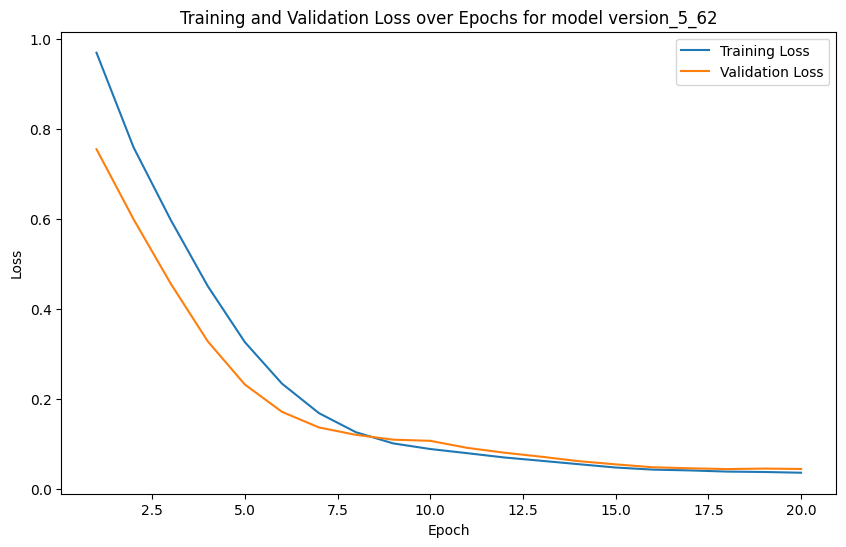

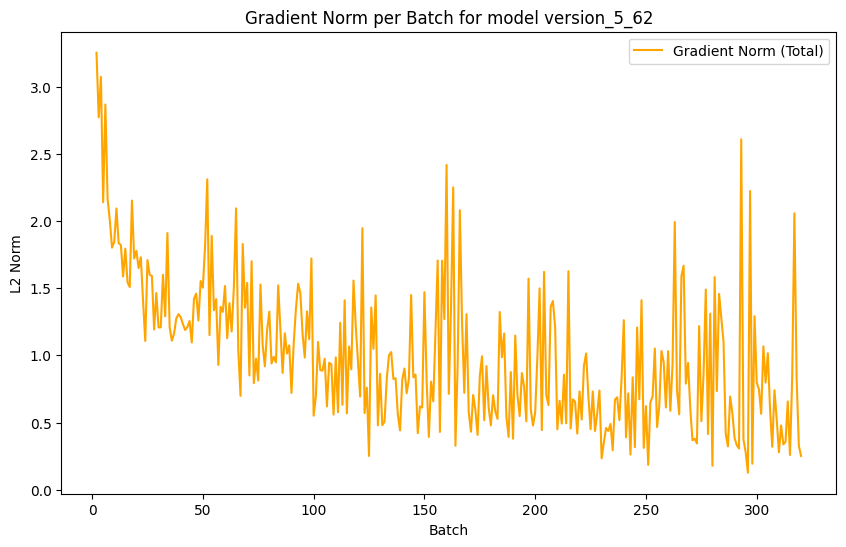

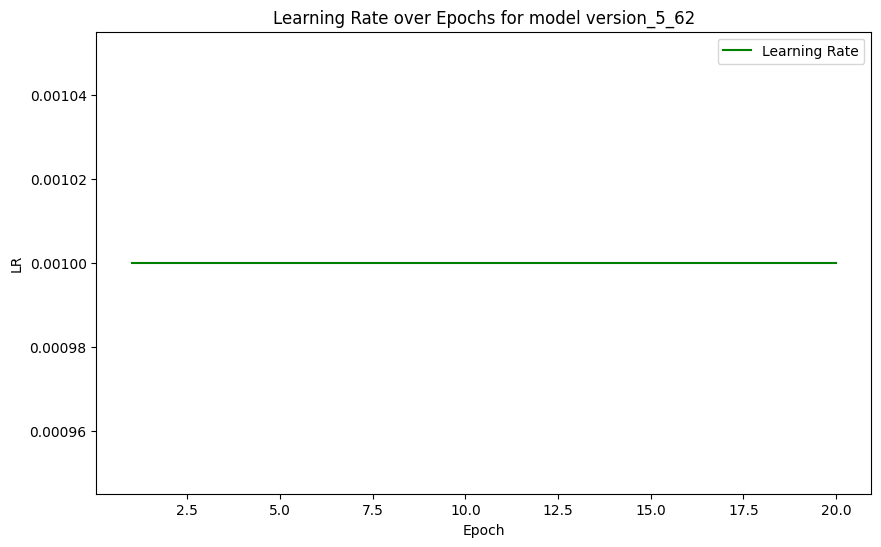

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_6_42 3 4 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.9807, Val Loss=0.8868, Grad Norm=0.6863, LR=0.00010]


New best model saved with val loss: 0.8868


Epoch 2/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.8826, Val Loss=0.7797, Grad Norm=1.3159, LR=0.00010]


New best model saved with val loss: 0.7797


Epoch 3/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.7790, Val Loss=0.6709, Grad Norm=0.8180, LR=0.00010]


New best model saved with val loss: 0.6709


Epoch 4/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.6552, Val Loss=0.5231, Grad Norm=0.5126, LR=0.00010]


New best model saved with val loss: 0.5231


Epoch 5/20: 100%|██████████| 32/32 [00:20<00:00,  1.59batch/s, Train Loss=0.5341, Val Loss=0.4308, Grad Norm=1.3348, LR=0.00010]


New best model saved with val loss: 0.4308


Epoch 6/20: 100%|██████████| 32/32 [00:19<00:00,  1.65batch/s, Train Loss=0.4398, Val Loss=0.3379, Grad Norm=1.0532, LR=0.00010]


New best model saved with val loss: 0.3379


Epoch 7/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.3380, Val Loss=0.2525, Grad Norm=1.0139, LR=0.00010]


New best model saved with val loss: 0.2525


Epoch 8/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.2473, Val Loss=0.1891, Grad Norm=1.2374, LR=0.00010]


New best model saved with val loss: 0.1891


Epoch 9/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.1781, Val Loss=0.1476, Grad Norm=0.6653, LR=0.00010]


New best model saved with val loss: 0.1476


Epoch 10/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.1338, Val Loss=0.1240, Grad Norm=1.9275, LR=0.00010]


New best model saved with val loss: 0.1240


Epoch 11/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.1075, Val Loss=0.1111, Grad Norm=1.5459, LR=0.00010]


New best model saved with val loss: 0.1111


Epoch 12/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0941, Val Loss=0.1017, Grad Norm=0.3512, LR=0.00010]


New best model saved with val loss: 0.1017


Epoch 13/20: 100%|██████████| 32/32 [00:19<00:00,  1.65batch/s, Train Loss=0.0817, Val Loss=0.0944, Grad Norm=1.7991, LR=0.00010]


New best model saved with val loss: 0.0944


Epoch 14/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0731, Val Loss=0.0769, Grad Norm=0.9300, LR=0.00010]


New best model saved with val loss: 0.0769


Epoch 15/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0639, Val Loss=0.0683, Grad Norm=0.3806, LR=0.00010]


New best model saved with val loss: 0.0683


Epoch 16/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0596, Val Loss=0.0620, Grad Norm=1.9427, LR=0.00010]


New best model saved with val loss: 0.0620


Epoch 17/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0531, Val Loss=0.0579, Grad Norm=0.5499, LR=0.00010]


New best model saved with val loss: 0.0579


Epoch 18/20: 100%|██████████| 32/32 [00:19<00:00,  1.65batch/s, Train Loss=0.0498, Val Loss=0.0563, Grad Norm=0.5432, LR=0.00010]


New best model saved with val loss: 0.0563


Epoch 19/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0472, Val Loss=0.0524, Grad Norm=0.7609, LR=0.00010]


New best model saved with val loss: 0.0524


Epoch 20/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0450, Val Loss=0.0523, Grad Norm=0.1884, LR=0.00010]


New best model saved with val loss: 0.0523

=== Final Metrics ===
Final Train Loss: 0.0450
Final Val Loss: 0.0523
Generalization Gap: 0.0072
Best Val Epoch: 20
Training Time: 6.52 minutes
Trainable Parameters: 400


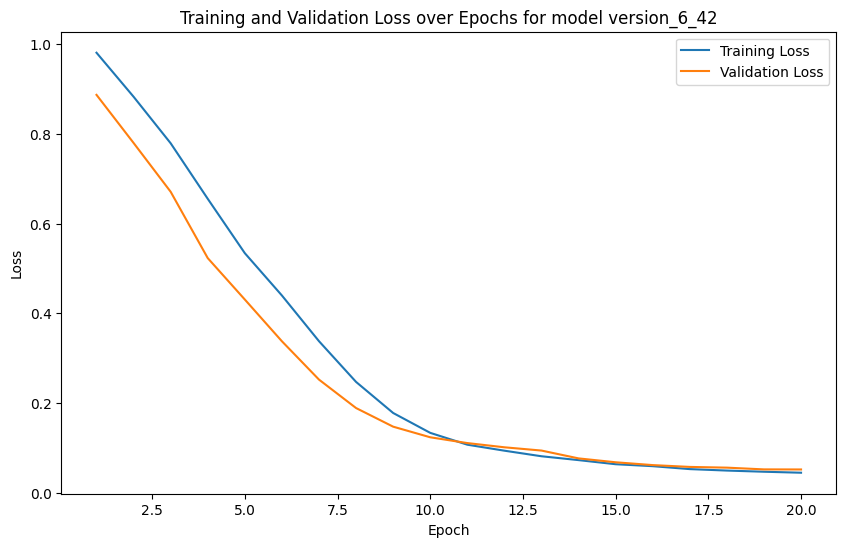

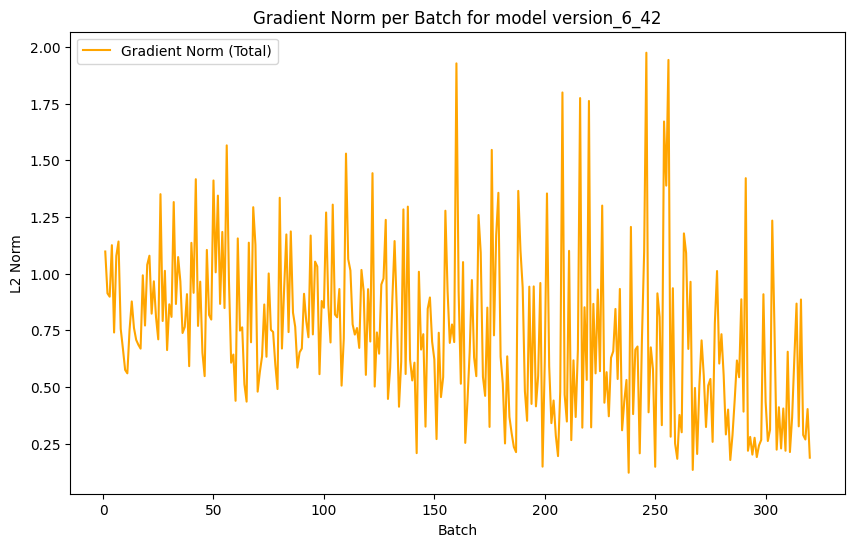

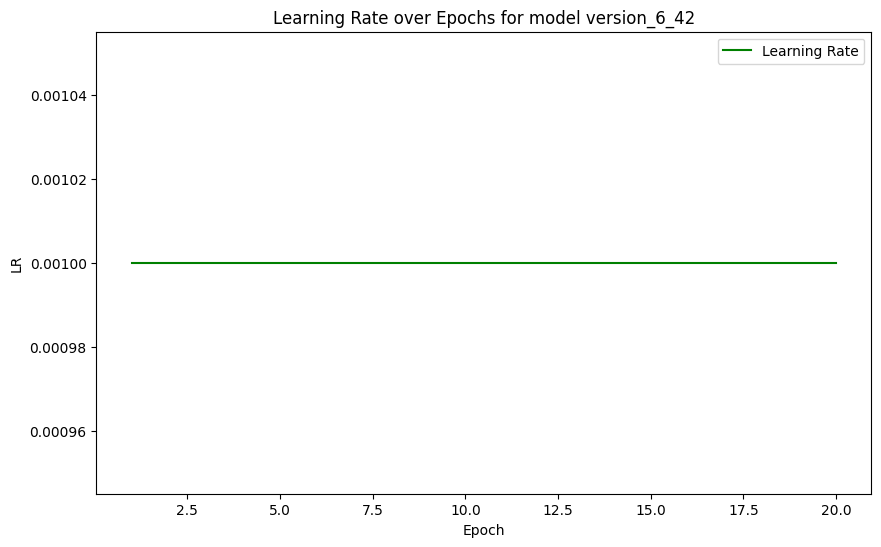

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_6_52 3 4 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=1.0420, Val Loss=0.8844, Grad Norm=0.7956, LR=0.00010]


New best model saved with val loss: 0.8844


Epoch 2/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.8582, Val Loss=0.7125, Grad Norm=1.3729, LR=0.00010]


New best model saved with val loss: 0.7125


Epoch 3/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.6790, Val Loss=0.5300, Grad Norm=1.3699, LR=0.00010]


New best model saved with val loss: 0.5300


Epoch 4/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.4943, Val Loss=0.3609, Grad Norm=2.2305, LR=0.00010]


New best model saved with val loss: 0.3609


Epoch 5/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.3364, Val Loss=0.2431, Grad Norm=0.9140, LR=0.00010]


New best model saved with val loss: 0.2431


Epoch 6/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.2325, Val Loss=0.1643, Grad Norm=0.3771, LR=0.00010]


New best model saved with val loss: 0.1643


Epoch 7/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.1583, Val Loss=0.1164, Grad Norm=1.2454, LR=0.00010]


New best model saved with val loss: 0.1164


Epoch 8/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.1087, Val Loss=0.0902, Grad Norm=0.5081, LR=0.00010]


New best model saved with val loss: 0.0902


Epoch 9/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0801, Val Loss=0.0676, Grad Norm=1.5218, LR=0.00010]


New best model saved with val loss: 0.0676


Epoch 10/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0593, Val Loss=0.0574, Grad Norm=0.5800, LR=0.00010]


New best model saved with val loss: 0.0574


Epoch 11/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0483, Val Loss=0.0529, Grad Norm=0.4542, LR=0.00010]


New best model saved with val loss: 0.0529


Epoch 13/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0419, Val Loss=0.0484, Grad Norm=0.3225, LR=0.00010]


New best model saved with val loss: 0.0484


Epoch 14/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0386, Val Loss=0.0462, Grad Norm=0.6037, LR=0.00010]


New best model saved with val loss: 0.0462


Epoch 15/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0366, Val Loss=0.0456, Grad Norm=0.5223, LR=0.00010]


New best model saved with val loss: 0.0456


Epoch 17/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.0359, Val Loss=0.0448, Grad Norm=0.4246, LR=0.00010]


New best model saved with val loss: 0.0448


Epoch 18/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0343, Val Loss=0.0440, Grad Norm=1.2627, LR=0.00010]


New best model saved with val loss: 0.0440


Epoch 19/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0354, Val Loss=0.0439, Grad Norm=0.6930, LR=0.00010]


New best model saved with val loss: 0.0439


Epoch 20/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0340, Val Loss=0.0429, Grad Norm=0.6382, LR=0.00010]


New best model saved with val loss: 0.0429

=== Final Metrics ===
Final Train Loss: 0.0340
Final Val Loss: 0.0429
Generalization Gap: 0.0089
Best Val Epoch: 20
Training Time: 6.55 minutes
Trainable Parameters: 400


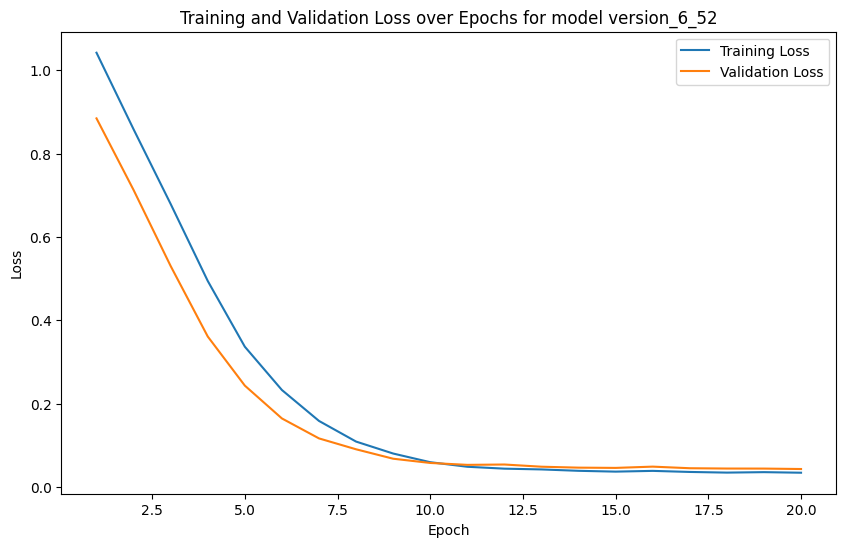

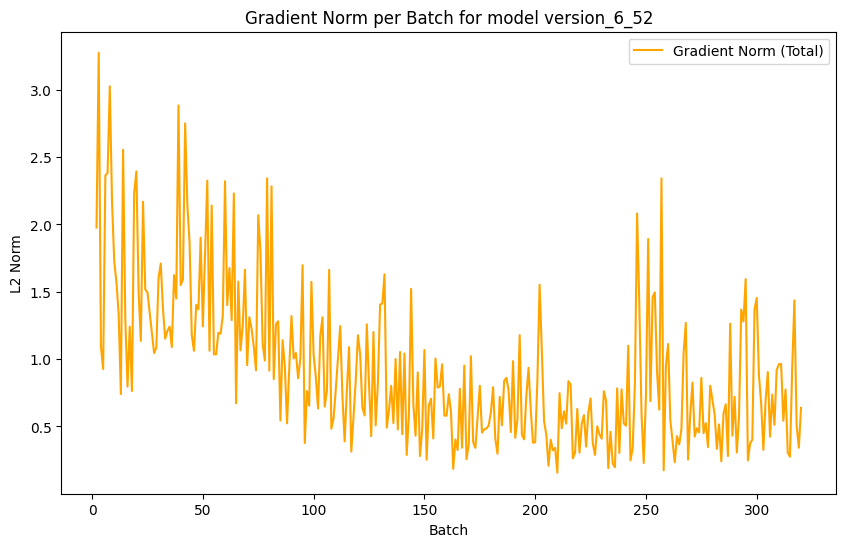

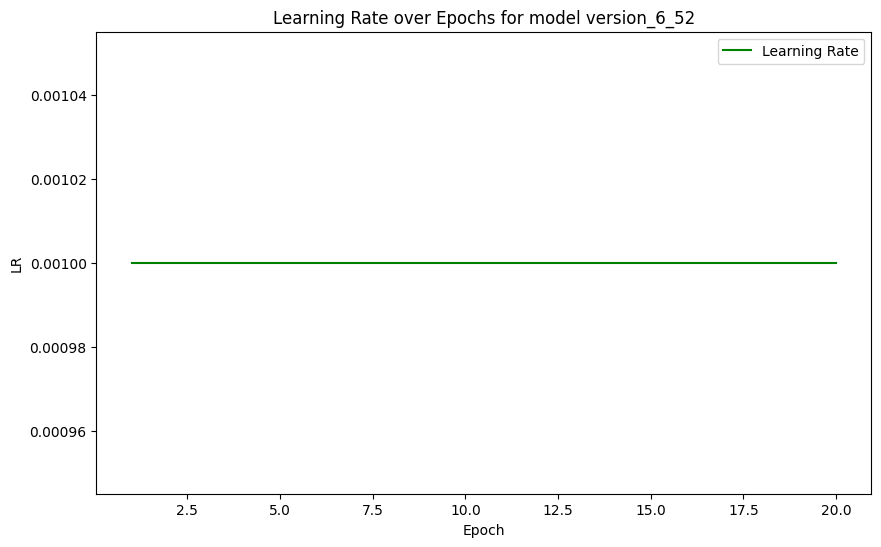

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_6_62 3 4 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:19<00:00,  1.65batch/s, Train Loss=0.9879, Val Loss=0.8606, Grad Norm=0.7828, LR=0.00010]


New best model saved with val loss: 0.8606


Epoch 2/20: 100%|██████████| 32/32 [00:19<00:00,  1.66batch/s, Train Loss=0.8581, Val Loss=0.7157, Grad Norm=1.3584, LR=0.00010]


New best model saved with val loss: 0.7157


Epoch 3/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.6956, Val Loss=0.5541, Grad Norm=2.0166, LR=0.00010]


New best model saved with val loss: 0.5541


Epoch 4/20: 100%|██████████| 32/32 [00:19<00:00,  1.66batch/s, Train Loss=0.5327, Val Loss=0.4188, Grad Norm=1.0466, LR=0.00010]


New best model saved with val loss: 0.4188


Epoch 5/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.4066, Val Loss=0.3089, Grad Norm=1.5900, LR=0.00010]


New best model saved with val loss: 0.3089


Epoch 6/20: 100%|██████████| 32/32 [00:19<00:00,  1.67batch/s, Train Loss=0.2942, Val Loss=0.2196, Grad Norm=1.8927, LR=0.00010]


New best model saved with val loss: 0.2196


Epoch 7/20: 100%|██████████| 32/32 [00:19<00:00,  1.66batch/s, Train Loss=0.2076, Val Loss=0.1536, Grad Norm=0.7825, LR=0.00010]


New best model saved with val loss: 0.1536


Epoch 8/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.1456, Val Loss=0.1157, Grad Norm=0.4383, LR=0.00010]


New best model saved with val loss: 0.1157


Epoch 9/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.1090, Val Loss=0.0913, Grad Norm=0.6701, LR=0.00010]


New best model saved with val loss: 0.0913


Epoch 10/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0831, Val Loss=0.0760, Grad Norm=0.8476, LR=0.00010]


New best model saved with val loss: 0.0760


Epoch 11/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0695, Val Loss=0.0655, Grad Norm=0.6308, LR=0.00010]


New best model saved with val loss: 0.0655


Epoch 12/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0593, Val Loss=0.0603, Grad Norm=0.5302, LR=0.00010]


New best model saved with val loss: 0.0603


Epoch 13/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0524, Val Loss=0.0537, Grad Norm=0.3076, LR=0.00010]


New best model saved with val loss: 0.0537


Epoch 14/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0467, Val Loss=0.0506, Grad Norm=0.3813, LR=0.00010]


New best model saved with val loss: 0.0506


Epoch 15/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0432, Val Loss=0.0479, Grad Norm=0.2548, LR=0.00010]


New best model saved with val loss: 0.0479


Epoch 16/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0403, Val Loss=0.0466, Grad Norm=1.2964, LR=0.00010]


New best model saved with val loss: 0.0466


Epoch 18/20: 100%|██████████| 32/32 [00:19<00:00,  1.64batch/s, Train Loss=0.0373, Val Loss=0.0451, Grad Norm=0.3349, LR=0.00010]


New best model saved with val loss: 0.0451


Epoch 19/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.0359, Val Loss=0.0443, Grad Norm=0.6402, LR=0.00010]


New best model saved with val loss: 0.0443


Epoch 20/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0352, Val Loss=0.0434, Grad Norm=0.2502, LR=0.00010]


New best model saved with val loss: 0.0434

=== Final Metrics ===
Final Train Loss: 0.0352
Final Val Loss: 0.0434
Generalization Gap: 0.0082
Best Val Epoch: 20
Training Time: 6.52 minutes
Trainable Parameters: 400


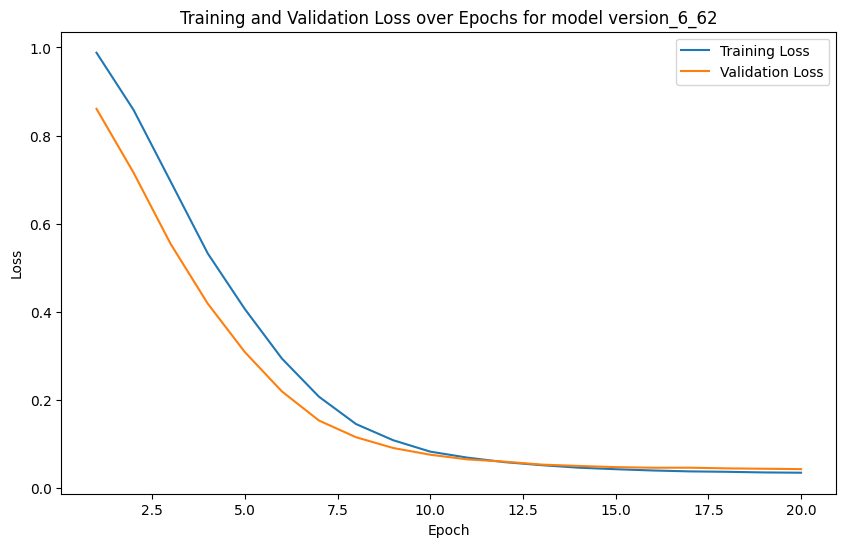

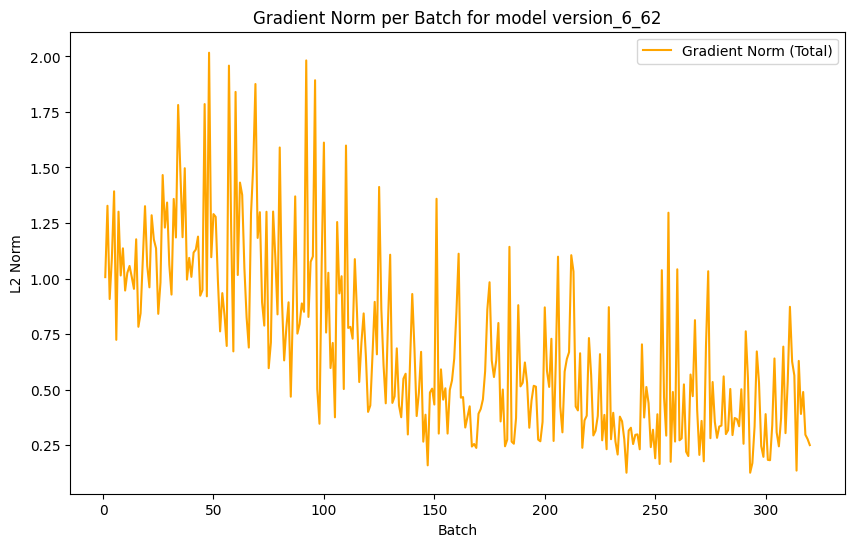

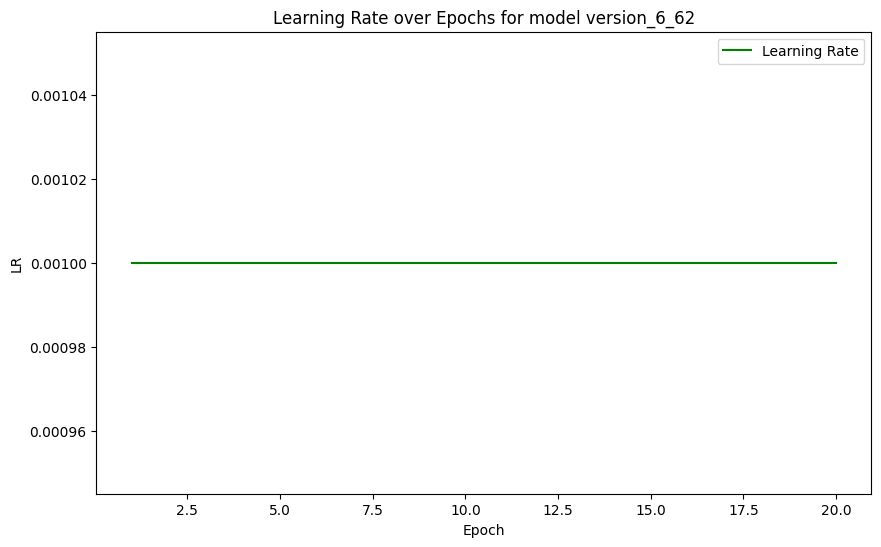

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_7_42 4 2 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.9547, Val Loss=0.8486, Grad Norm=0.8549, LR=0.00010]


New best model saved with val loss: 0.8486


Epoch 2/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.8471, Val Loss=0.7027, Grad Norm=0.9889, LR=0.00010]


New best model saved with val loss: 0.7027


Epoch 3/20: 100%|██████████| 32/32 [00:19<00:00,  1.60batch/s, Train Loss=0.6531, Val Loss=0.5039, Grad Norm=0.8844, LR=0.00010]


New best model saved with val loss: 0.5039


Epoch 4/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.4725, Val Loss=0.3485, Grad Norm=1.1167, LR=0.00010]


New best model saved with val loss: 0.3485


Epoch 5/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.3239, Val Loss=0.2348, Grad Norm=1.2649, LR=0.00010]


New best model saved with val loss: 0.2348


Epoch 6/20: 100%|██████████| 32/32 [00:20<00:00,  1.54batch/s, Train Loss=0.2193, Val Loss=0.1614, Grad Norm=0.4741, LR=0.00010]


New best model saved with val loss: 0.1614


Epoch 7/20: 100%|██████████| 32/32 [00:20<00:00,  1.56batch/s, Train Loss=0.1515, Val Loss=0.1179, Grad Norm=0.9491, LR=0.00010]


New best model saved with val loss: 0.1179


Epoch 8/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.1078, Val Loss=0.0927, Grad Norm=0.7735, LR=0.00010]


New best model saved with val loss: 0.0927


Epoch 9/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0831, Val Loss=0.0775, Grad Norm=0.8836, LR=0.00010]


New best model saved with val loss: 0.0775


Epoch 10/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.0702, Val Loss=0.0670, Grad Norm=0.5089, LR=0.00010]


New best model saved with val loss: 0.0670


Epoch 11/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0585, Val Loss=0.0608, Grad Norm=0.3703, LR=0.00010]


New best model saved with val loss: 0.0608


Epoch 12/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0524, Val Loss=0.0544, Grad Norm=0.5033, LR=0.00010]


New best model saved with val loss: 0.0544


Epoch 13/20: 100%|██████████| 32/32 [00:19<00:00,  1.60batch/s, Train Loss=0.0457, Val Loss=0.0534, Grad Norm=0.5522, LR=0.00010]


New best model saved with val loss: 0.0534


Epoch 14/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0447, Val Loss=0.0483, Grad Norm=0.6125, LR=0.00010]


New best model saved with val loss: 0.0483


Epoch 15/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0398, Val Loss=0.0463, Grad Norm=0.3893, LR=0.00010]


New best model saved with val loss: 0.0463


Epoch 16/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0380, Val Loss=0.0448, Grad Norm=0.3811, LR=0.00010]


New best model saved with val loss: 0.0448


Epoch 17/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0360, Val Loss=0.0442, Grad Norm=0.3850, LR=0.00010]


New best model saved with val loss: 0.0442


Epoch 18/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0351, Val Loss=0.0433, Grad Norm=0.4450, LR=0.00010]


New best model saved with val loss: 0.0433


Epoch 19/20: 100%|██████████| 32/32 [00:19<00:00,  1.60batch/s, Train Loss=0.0344, Val Loss=0.0425, Grad Norm=1.1686, LR=0.00010]


New best model saved with val loss: 0.0425


Epoch 20/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0346, Val Loss=0.0420, Grad Norm=1.6619, LR=0.00010]


New best model saved with val loss: 0.0420

=== Final Metrics ===
Final Train Loss: 0.0346
Final Val Loss: 0.0420
Generalization Gap: 0.0074
Best Val Epoch: 20
Training Time: 6.62 minutes
Trainable Parameters: 445


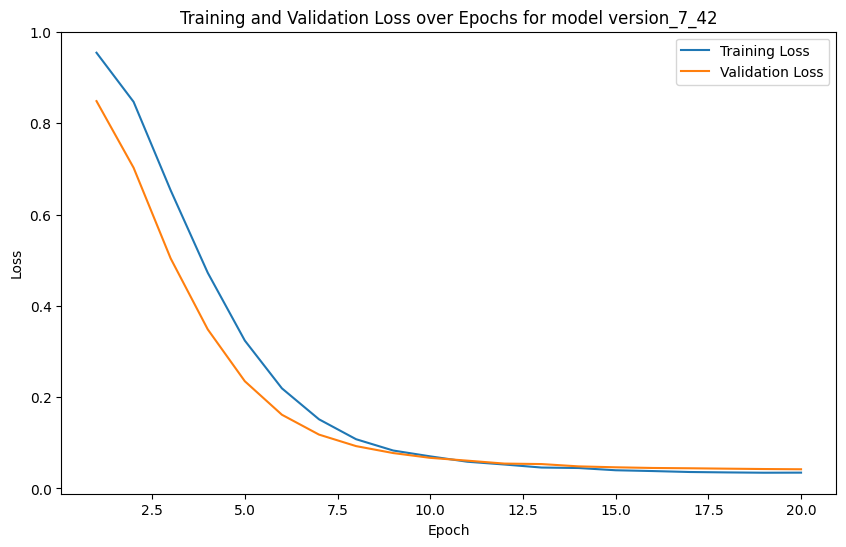

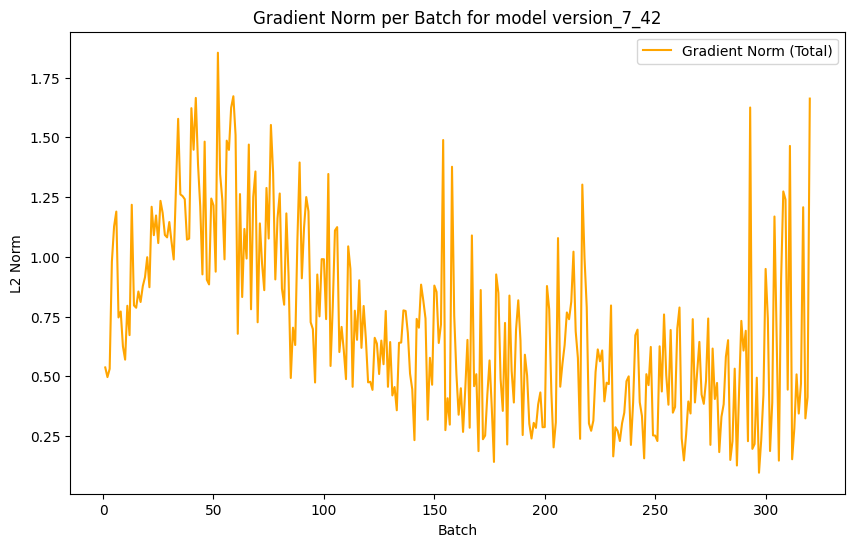

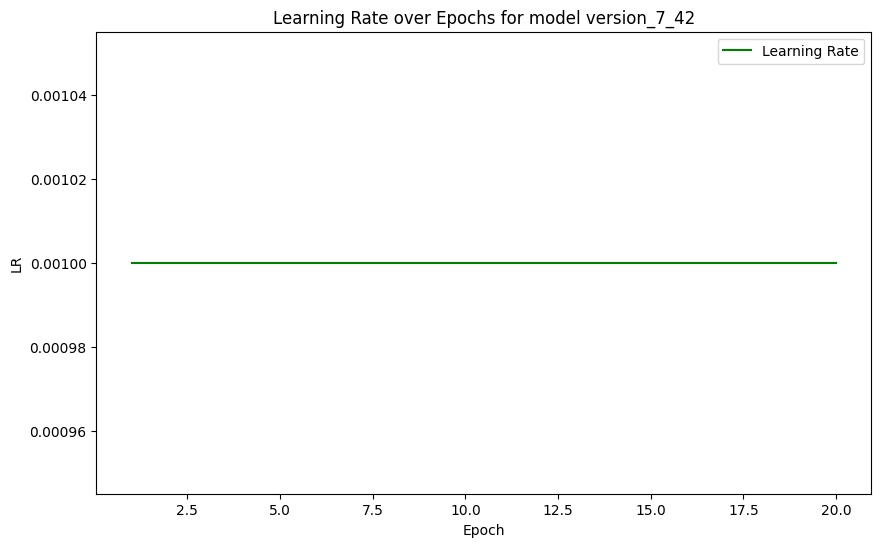

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_7_52 4 2 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.9927, Val Loss=0.8584, Grad Norm=0.7819, LR=0.00010]


New best model saved with val loss: 0.8584


Epoch 2/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.8432, Val Loss=0.7152, Grad Norm=0.8747, LR=0.00010]


New best model saved with val loss: 0.7152


Epoch 3/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.6996, Val Loss=0.5686, Grad Norm=0.6619, LR=0.00010]


New best model saved with val loss: 0.5686


Epoch 4/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.5478, Val Loss=0.4234, Grad Norm=1.1568, LR=0.00010]


New best model saved with val loss: 0.4234


Epoch 5/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.4132, Val Loss=0.3233, Grad Norm=1.3986, LR=0.00010]


New best model saved with val loss: 0.3233


Epoch 6/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.3178, Val Loss=0.2415, Grad Norm=1.4397, LR=0.00010]


New best model saved with val loss: 0.2415


Epoch 7/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.2325, Val Loss=0.1733, Grad Norm=0.8596, LR=0.00010]


New best model saved with val loss: 0.1733


Epoch 8/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.1626, Val Loss=0.1229, Grad Norm=0.6351, LR=0.00010]


New best model saved with val loss: 0.1229


Epoch 9/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.1143, Val Loss=0.0913, Grad Norm=1.2501, LR=0.00010]


New best model saved with val loss: 0.0913


Epoch 10/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0850, Val Loss=0.0725, Grad Norm=1.3767, LR=0.00010]


New best model saved with val loss: 0.0725


Epoch 11/20: 100%|██████████| 32/32 [00:20<00:00,  1.56batch/s, Train Loss=0.0665, Val Loss=0.0625, Grad Norm=0.2743, LR=0.00010]


New best model saved with val loss: 0.0625


Epoch 12/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0553, Val Loss=0.0558, Grad Norm=0.6358, LR=0.00010]


New best model saved with val loss: 0.0558


Epoch 13/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0493, Val Loss=0.0512, Grad Norm=0.6125, LR=0.00010]


New best model saved with val loss: 0.0512


Epoch 14/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0454, Val Loss=0.0492, Grad Norm=0.6783, LR=0.00010]


New best model saved with val loss: 0.0492


Epoch 15/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0416, Val Loss=0.0458, Grad Norm=1.0386, LR=0.00010]


New best model saved with val loss: 0.0458


Epoch 16/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0395, Val Loss=0.0448, Grad Norm=1.0769, LR=0.00010]


New best model saved with val loss: 0.0448


Epoch 17/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.0377, Val Loss=0.0430, Grad Norm=0.4842, LR=0.00010]


New best model saved with val loss: 0.0430


Epoch 18/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.0367, Val Loss=0.0422, Grad Norm=0.5381, LR=0.00010]


New best model saved with val loss: 0.0422


Epoch 19/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0352, Val Loss=0.0411, Grad Norm=0.4974, LR=0.00010]


New best model saved with val loss: 0.0411


Epoch 20/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0338, Val Loss=0.0406, Grad Norm=0.6625, LR=0.00010]


New best model saved with val loss: 0.0406

=== Final Metrics ===
Final Train Loss: 0.0338
Final Val Loss: 0.0406
Generalization Gap: 0.0068
Best Val Epoch: 20
Training Time: 6.61 minutes
Trainable Parameters: 445


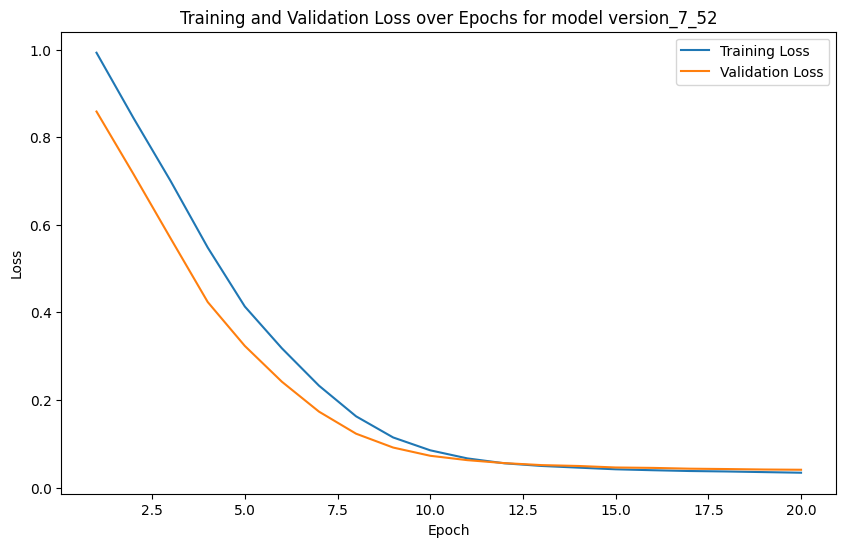

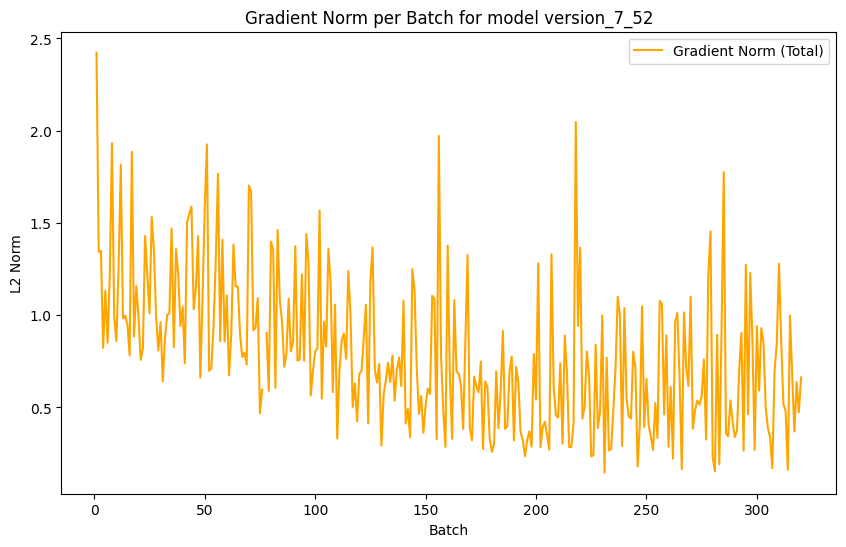

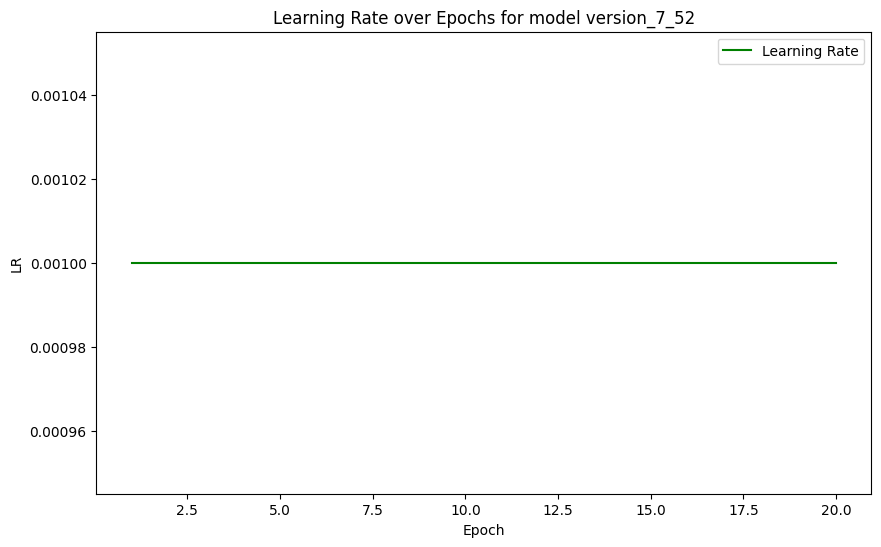

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_7_62 4 2 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:20<00:00,  1.57batch/s, Train Loss=0.8428, Val Loss=0.7004, Grad Norm=1.2376, LR=0.00010]


New best model saved with val loss: 0.7004


Epoch 2/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.6733, Val Loss=0.5178, Grad Norm=1.1972, LR=0.00010]


New best model saved with val loss: 0.5178


Epoch 3/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.4944, Val Loss=0.3640, Grad Norm=1.4665, LR=0.00010]


New best model saved with val loss: 0.3640


Epoch 4/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.3420, Val Loss=0.2400, Grad Norm=0.8926, LR=0.00010]


New best model saved with val loss: 0.2400


Epoch 5/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.2314, Val Loss=0.1711, Grad Norm=0.6155, LR=0.00010]


New best model saved with val loss: 0.1711


Epoch 6/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.1698, Val Loss=0.1332, Grad Norm=0.4187, LR=0.00010]


New best model saved with val loss: 0.1332


Epoch 7/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.1279, Val Loss=0.1065, Grad Norm=1.4570, LR=0.00010]


New best model saved with val loss: 0.1065


Epoch 8/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.1008, Val Loss=0.0921, Grad Norm=0.5700, LR=0.00010]


New best model saved with val loss: 0.0921


Epoch 9/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0847, Val Loss=0.0783, Grad Norm=0.6892, LR=0.00010]


New best model saved with val loss: 0.0783


Epoch 10/20: 100%|██████████| 32/32 [00:19<00:00,  1.61batch/s, Train Loss=0.0706, Val Loss=0.0750, Grad Norm=1.2194, LR=0.00010]


New best model saved with val loss: 0.0750


Epoch 11/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0614, Val Loss=0.0602, Grad Norm=0.4124, LR=0.00010]


New best model saved with val loss: 0.0602


Epoch 12/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0545, Val Loss=0.0540, Grad Norm=0.8319, LR=0.00010]


New best model saved with val loss: 0.0540


Epoch 13/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0484, Val Loss=0.0483, Grad Norm=0.7428, LR=0.00010]


New best model saved with val loss: 0.0483


Epoch 14/20: 100%|██████████| 32/32 [00:19<00:00,  1.60batch/s, Train Loss=0.0444, Val Loss=0.0441, Grad Norm=0.6607, LR=0.00010]


New best model saved with val loss: 0.0441


Epoch 15/20: 100%|██████████| 32/32 [00:19<00:00,  1.62batch/s, Train Loss=0.0403, Val Loss=0.0419, Grad Norm=0.4328, LR=0.00010]


New best model saved with val loss: 0.0419


Epoch 16/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0379, Val Loss=0.0394, Grad Norm=0.8030, LR=0.00010]


New best model saved with val loss: 0.0394


Epoch 17/20: 100%|██████████| 32/32 [00:19<00:00,  1.60batch/s, Train Loss=0.0363, Val Loss=0.0387, Grad Norm=0.2426, LR=0.00010]


New best model saved with val loss: 0.0387


Epoch 18/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0338, Val Loss=0.0377, Grad Norm=0.5047, LR=0.00010]


New best model saved with val loss: 0.0377


Epoch 19/20: 100%|██████████| 32/32 [00:19<00:00,  1.63batch/s, Train Loss=0.0326, Val Loss=0.0372, Grad Norm=0.5563, LR=0.00010]


New best model saved with val loss: 0.0372


Epoch 20/20: 100%|██████████| 32/32 [00:19<00:00,  1.60batch/s, Train Loss=0.0317, Val Loss=0.0370, Grad Norm=1.3726, LR=0.00010]


New best model saved with val loss: 0.0370

=== Final Metrics ===
Final Train Loss: 0.0317
Final Val Loss: 0.0370
Generalization Gap: 0.0053
Best Val Epoch: 20
Training Time: 6.61 minutes
Trainable Parameters: 445


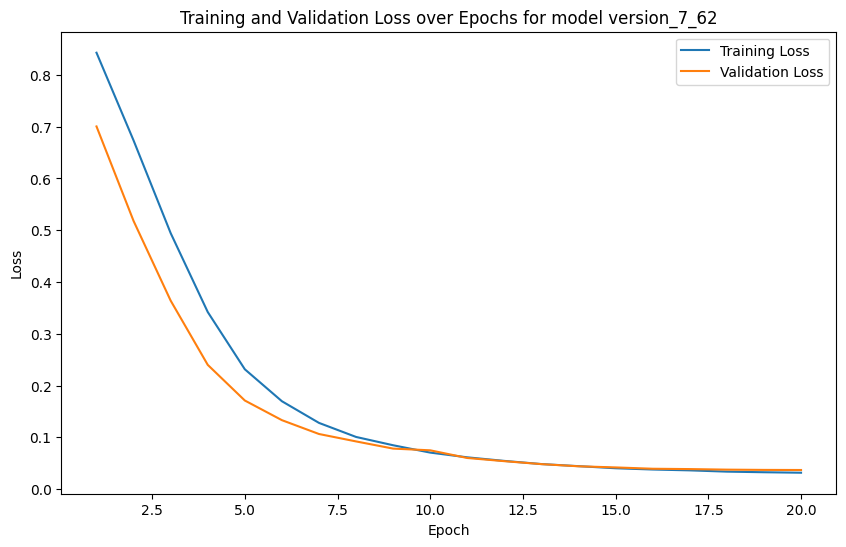

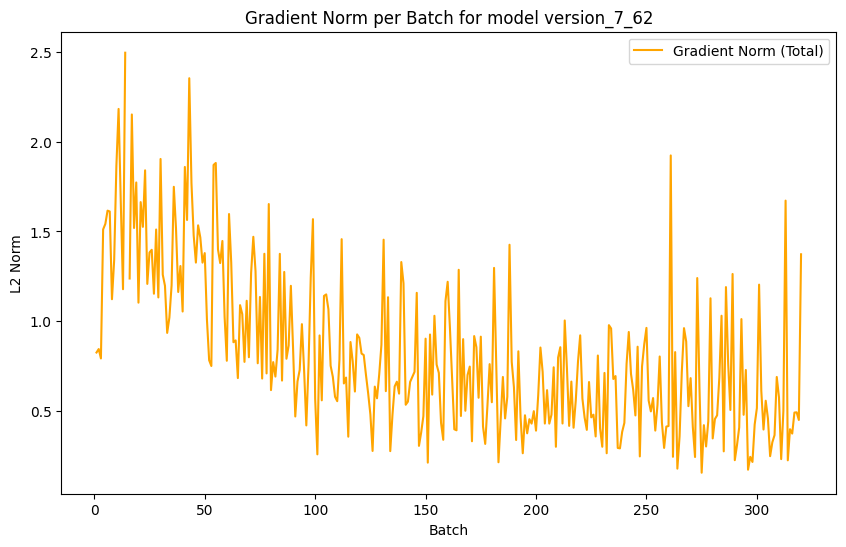

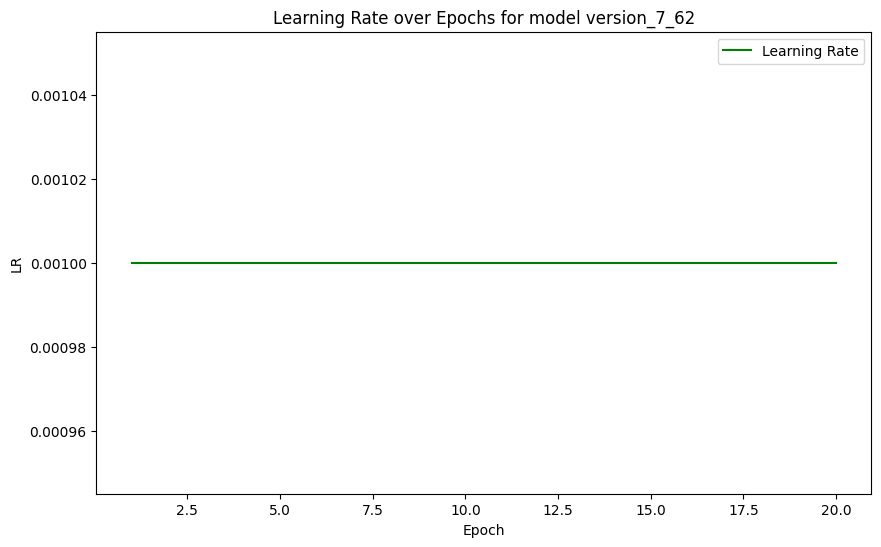

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_8_42 4 3 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=1.0042, Val Loss=0.8903, Grad Norm=0.6500, LR=0.00010]


New best model saved with val loss: 0.8903


Epoch 2/20: 100%|██████████| 32/32 [00:24<00:00,  1.32batch/s, Train Loss=0.9283, Val Loss=0.8350, Grad Norm=0.6015, LR=0.00010]


New best model saved with val loss: 0.8350


Epoch 3/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.8642, Val Loss=0.7631, Grad Norm=1.1149, LR=0.00010]


New best model saved with val loss: 0.7631


Epoch 4/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.7764, Val Loss=0.6642, Grad Norm=0.9811, LR=0.00010]


New best model saved with val loss: 0.6642


Epoch 5/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.6596, Val Loss=0.5398, Grad Norm=1.0329, LR=0.00010]


New best model saved with val loss: 0.5398


Epoch 6/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.5166, Val Loss=0.3944, Grad Norm=0.9662, LR=0.00010]


New best model saved with val loss: 0.3944


Epoch 7/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.3745, Val Loss=0.2765, Grad Norm=0.9473, LR=0.00010]


New best model saved with val loss: 0.2765


Epoch 8/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.2616, Val Loss=0.1861, Grad Norm=0.6642, LR=0.00010]


New best model saved with val loss: 0.1861


Epoch 9/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.1717, Val Loss=0.1221, Grad Norm=0.9615, LR=0.00010]


New best model saved with val loss: 0.1221


Epoch 10/20: 100%|██████████| 32/32 [00:27<00:00,  1.17batch/s, Train Loss=0.1136, Val Loss=0.0853, Grad Norm=0.7418, LR=0.00010]


New best model saved with val loss: 0.0853


Epoch 11/20: 100%|██████████| 32/32 [00:25<00:00,  1.28batch/s, Train Loss=0.0799, Val Loss=0.0658, Grad Norm=0.9759, LR=0.00010]


New best model saved with val loss: 0.0658


Epoch 12/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0603, Val Loss=0.0594, Grad Norm=0.4469, LR=0.00010]


New best model saved with val loss: 0.0594


Epoch 13/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0518, Val Loss=0.0520, Grad Norm=1.1234, LR=0.00010]


New best model saved with val loss: 0.0520


Epoch 14/20: 100%|██████████| 32/32 [00:23<00:00,  1.33batch/s, Train Loss=0.0455, Val Loss=0.0488, Grad Norm=1.5169, LR=0.00010]


New best model saved with val loss: 0.0488


Epoch 15/20: 100%|██████████| 32/32 [00:23<00:00,  1.36batch/s, Train Loss=0.0443, Val Loss=0.0465, Grad Norm=0.4242, LR=0.00010]


New best model saved with val loss: 0.0465


Epoch 17/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0375, Val Loss=0.0444, Grad Norm=0.5008, LR=0.00010]


New best model saved with val loss: 0.0444


Epoch 18/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0362, Val Loss=0.0433, Grad Norm=0.8303, LR=0.00010]


New best model saved with val loss: 0.0433


Epoch 20/20: 100%|██████████| 32/32 [00:24<00:00,  1.33batch/s, Train Loss=0.0341, Val Loss=0.0427, Grad Norm=0.3169, LR=0.00010]


New best model saved with val loss: 0.0427

=== Final Metrics ===
Final Train Loss: 0.0341
Final Val Loss: 0.0427
Generalization Gap: 0.0085
Best Val Epoch: 20
Training Time: 8.03 minutes
Trainable Parameters: 449


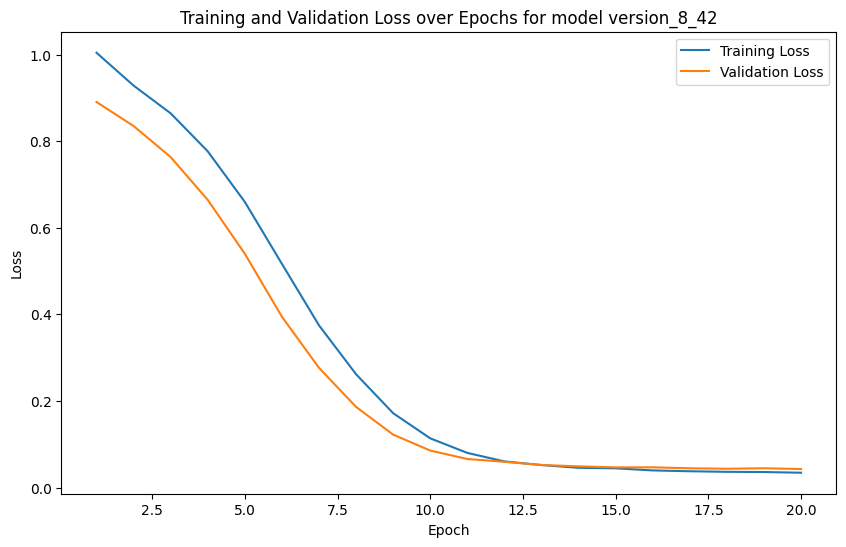

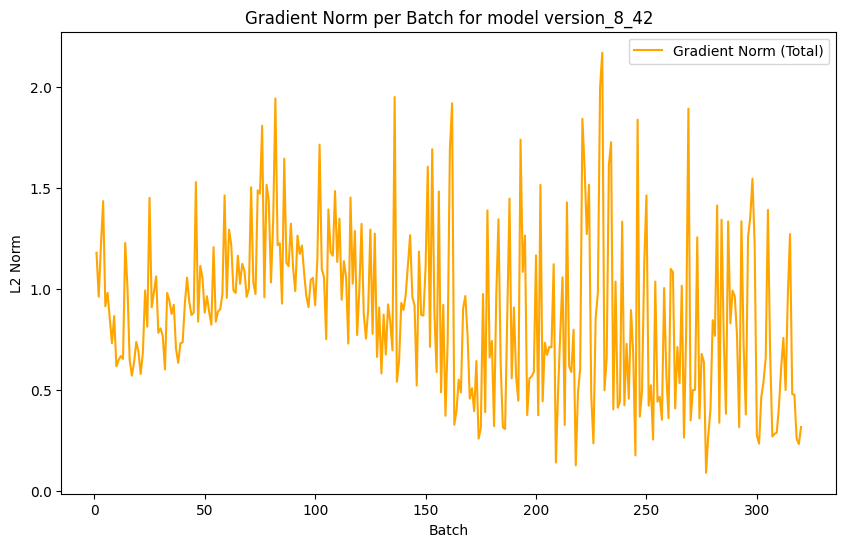

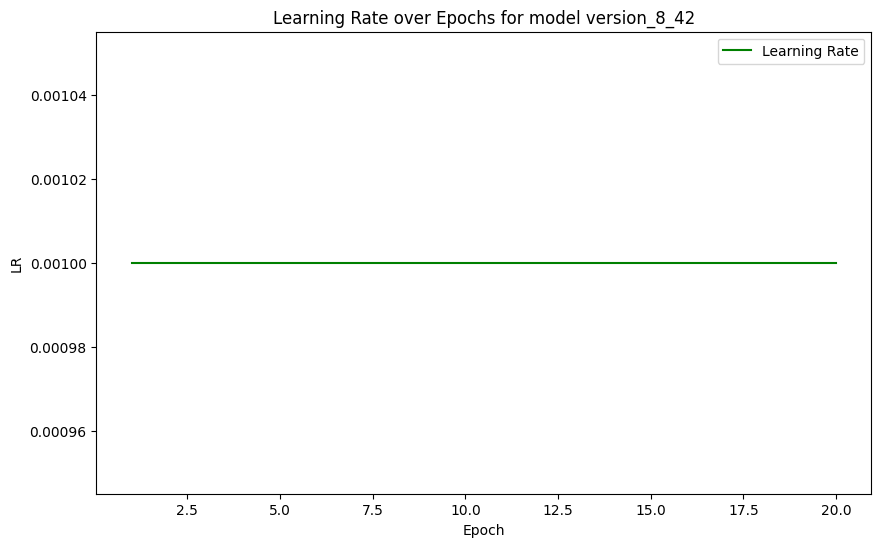

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_8_52 4 3 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=1.0063, Val Loss=0.9263, Grad Norm=0.5179, LR=0.00010]


New best model saved with val loss: 0.9263


Epoch 2/20: 100%|██████████| 32/32 [00:23<00:00,  1.33batch/s, Train Loss=0.9495, Val Loss=0.8576, Grad Norm=0.7666, LR=0.00010]


New best model saved with val loss: 0.8576


Epoch 3/20: 100%|██████████| 32/32 [00:24<00:00,  1.30batch/s, Train Loss=0.8570, Val Loss=0.7242, Grad Norm=1.0950, LR=0.00010]


New best model saved with val loss: 0.7242


Epoch 4/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.6981, Val Loss=0.5337, Grad Norm=1.0297, LR=0.00010]


New best model saved with val loss: 0.5337


Epoch 5/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.4856, Val Loss=0.3256, Grad Norm=1.2262, LR=0.00010]


New best model saved with val loss: 0.3256


Epoch 6/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.2906, Val Loss=0.1959, Grad Norm=1.6838, LR=0.00010]


New best model saved with val loss: 0.1959


Epoch 7/20: 100%|██████████| 32/32 [00:23<00:00,  1.36batch/s, Train Loss=0.1822, Val Loss=0.1243, Grad Norm=0.5775, LR=0.00010]


New best model saved with val loss: 0.1243


Epoch 8/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.1175, Val Loss=0.0886, Grad Norm=0.9646, LR=0.00010]


New best model saved with val loss: 0.0886


Epoch 9/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0796, Val Loss=0.0679, Grad Norm=0.7735, LR=0.00010]


New best model saved with val loss: 0.0679


Epoch 10/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0615, Val Loss=0.0603, Grad Norm=1.0798, LR=0.00010]


New best model saved with val loss: 0.0603


Epoch 11/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0521, Val Loss=0.0541, Grad Norm=0.3481, LR=0.00010]


New best model saved with val loss: 0.0541


Epoch 12/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0473, Val Loss=0.0482, Grad Norm=0.7004, LR=0.00010]


New best model saved with val loss: 0.0482


Epoch 13/20: 100%|██████████| 32/32 [00:24<00:00,  1.32batch/s, Train Loss=0.0426, Val Loss=0.0463, Grad Norm=1.1062, LR=0.00010]


New best model saved with val loss: 0.0463


Epoch 14/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0395, Val Loss=0.0450, Grad Norm=0.5703, LR=0.00010]


New best model saved with val loss: 0.0450


Epoch 15/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0384, Val Loss=0.0437, Grad Norm=0.2207, LR=0.00010]


New best model saved with val loss: 0.0437


Epoch 16/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0363, Val Loss=0.0426, Grad Norm=0.4167, LR=0.00010]


New best model saved with val loss: 0.0426


Epoch 17/20: 100%|██████████| 32/32 [00:24<00:00,  1.31batch/s, Train Loss=0.0351, Val Loss=0.0413, Grad Norm=0.6357, LR=0.00010]


New best model saved with val loss: 0.0413


Epoch 18/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0340, Val Loss=0.0407, Grad Norm=0.2555, LR=0.00010]


New best model saved with val loss: 0.0407


Epoch 19/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0337, Val Loss=0.0400, Grad Norm=0.6747, LR=0.00010]


New best model saved with val loss: 0.0400


Epoch 20/20: 100%|██████████| 32/32 [00:23<00:00,  1.36batch/s, Train Loss=0.0329, Val Loss=0.0457, Grad Norm=1.1080, LR=0.00010]



=== Final Metrics ===
Final Train Loss: 0.0329
Final Val Loss: 0.0457
Generalization Gap: 0.0129
Best Val Epoch: 19
Training Time: 7.96 minutes
Trainable Parameters: 449


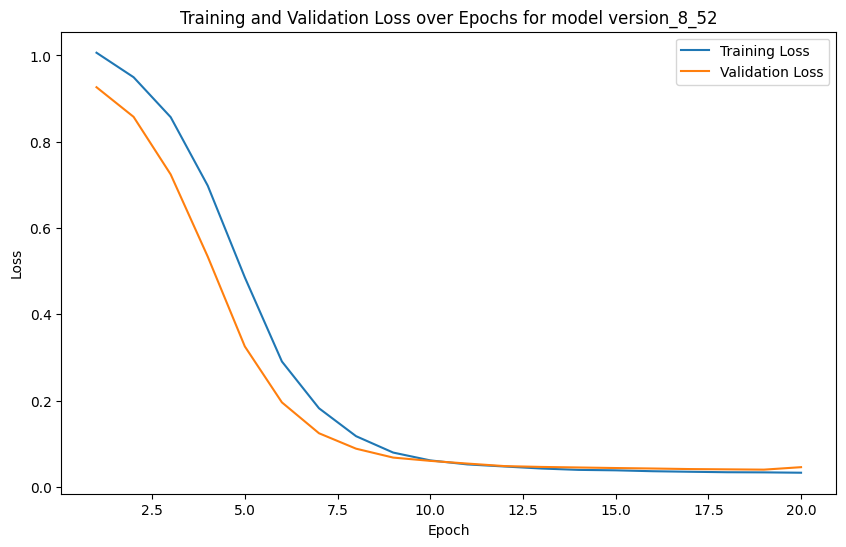

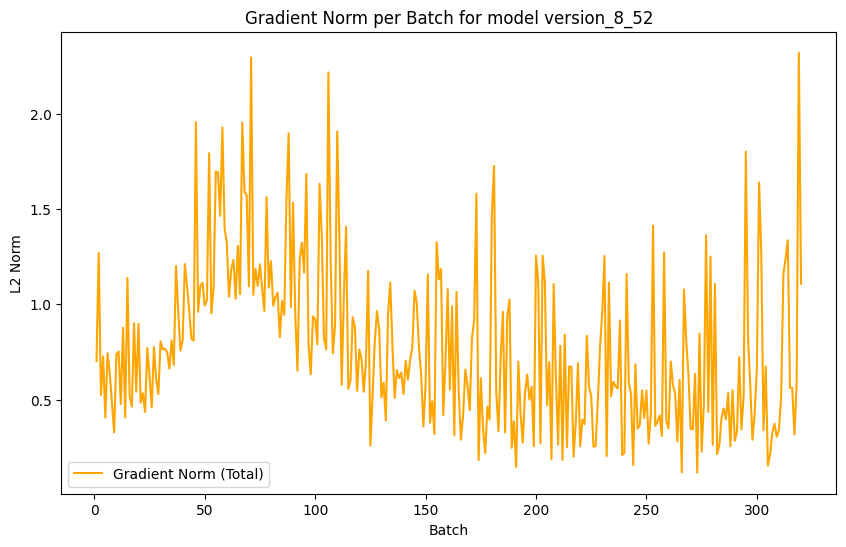

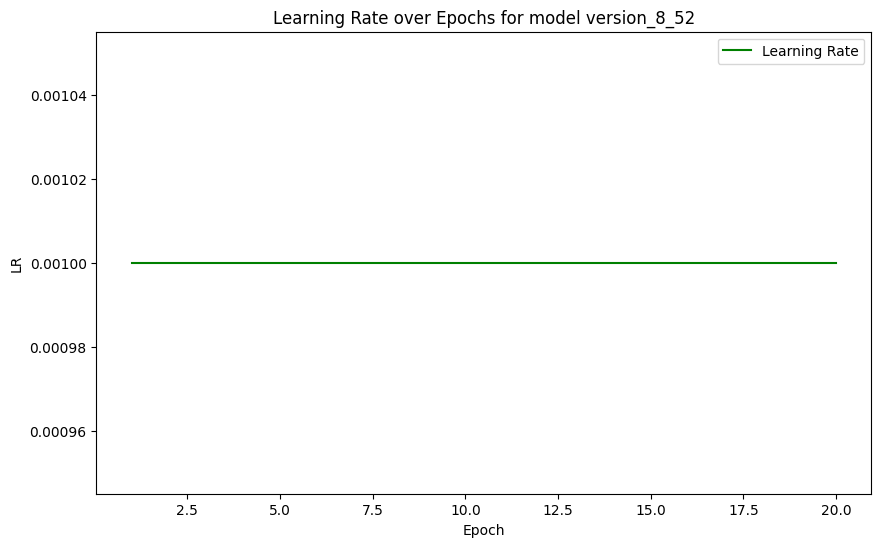

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_8_62 4 3 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.9896, Val Loss=0.8537, Grad Norm=0.8788, LR=0.00010]


New best model saved with val loss: 0.8537


Epoch 2/20: 100%|██████████| 32/32 [00:24<00:00,  1.31batch/s, Train Loss=0.8667, Val Loss=0.7289, Grad Norm=0.7887, LR=0.00010]


New best model saved with val loss: 0.7289


Epoch 3/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.7390, Val Loss=0.6068, Grad Norm=1.0049, LR=0.00010]


New best model saved with val loss: 0.6068


Epoch 4/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.6344, Val Loss=0.5266, Grad Norm=0.5644, LR=0.00010]


New best model saved with val loss: 0.5266


Epoch 5/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.5532, Val Loss=0.4488, Grad Norm=0.9932, LR=0.00010]


New best model saved with val loss: 0.4488


Epoch 6/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.4565, Val Loss=0.3509, Grad Norm=1.6140, LR=0.00010]


New best model saved with val loss: 0.3509


Epoch 7/20: 100%|██████████| 32/32 [00:23<00:00,  1.33batch/s, Train Loss=0.3332, Val Loss=0.2376, Grad Norm=0.9405, LR=0.00010]


New best model saved with val loss: 0.2376


Epoch 8/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.2040, Val Loss=0.1418, Grad Norm=0.5320, LR=0.00010]


New best model saved with val loss: 0.1418


Epoch 9/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.1177, Val Loss=0.0948, Grad Norm=2.0234, LR=0.00010]


New best model saved with val loss: 0.0948


Epoch 10/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0782, Val Loss=0.0817, Grad Norm=0.6288, LR=0.00010]


New best model saved with val loss: 0.0817


Epoch 11/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0670, Val Loss=0.0694, Grad Norm=0.4563, LR=0.00010]


New best model saved with val loss: 0.0694


Epoch 12/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0566, Val Loss=0.0623, Grad Norm=0.4457, LR=0.00010]


New best model saved with val loss: 0.0623


Epoch 13/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0531, Val Loss=0.0618, Grad Norm=0.9900, LR=0.00010]


New best model saved with val loss: 0.0618


Epoch 14/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0480, Val Loss=0.0531, Grad Norm=0.6031, LR=0.00010]


New best model saved with val loss: 0.0531


Epoch 15/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0450, Val Loss=0.0502, Grad Norm=0.5337, LR=0.00010]


New best model saved with val loss: 0.0502


Epoch 16/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0424, Val Loss=0.0479, Grad Norm=0.8273, LR=0.00010]


New best model saved with val loss: 0.0479


Epoch 17/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0396, Val Loss=0.0455, Grad Norm=0.4414, LR=0.00010]


New best model saved with val loss: 0.0455


Epoch 18/20: 100%|██████████| 32/32 [00:23<00:00,  1.34batch/s, Train Loss=0.0384, Val Loss=0.0448, Grad Norm=1.4186, LR=0.00010]


New best model saved with val loss: 0.0448


Epoch 19/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0373, Val Loss=0.0428, Grad Norm=0.9887, LR=0.00010]


New best model saved with val loss: 0.0428


Epoch 20/20: 100%|██████████| 32/32 [00:23<00:00,  1.35batch/s, Train Loss=0.0357, Val Loss=0.0419, Grad Norm=0.2466, LR=0.00010]


New best model saved with val loss: 0.0419

=== Final Metrics ===
Final Train Loss: 0.0357
Final Val Loss: 0.0419
Generalization Gap: 0.0062
Best Val Epoch: 20
Training Time: 7.96 minutes
Trainable Parameters: 449


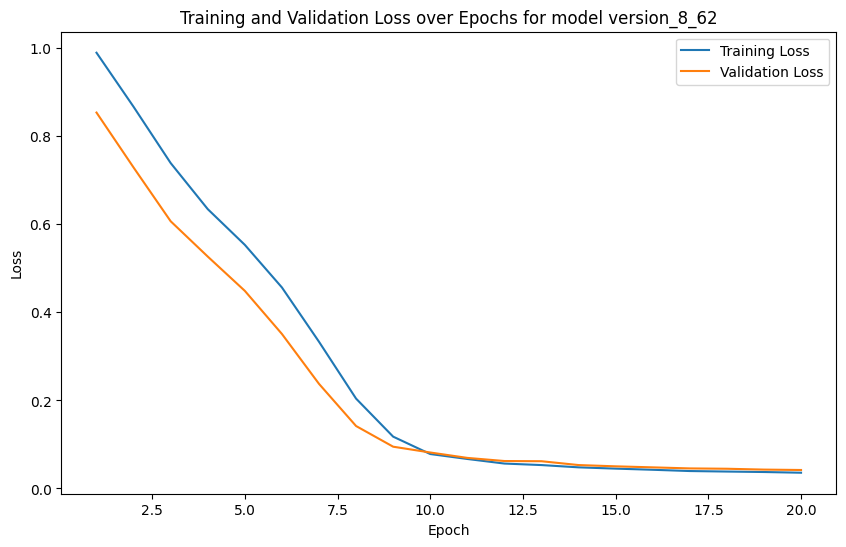

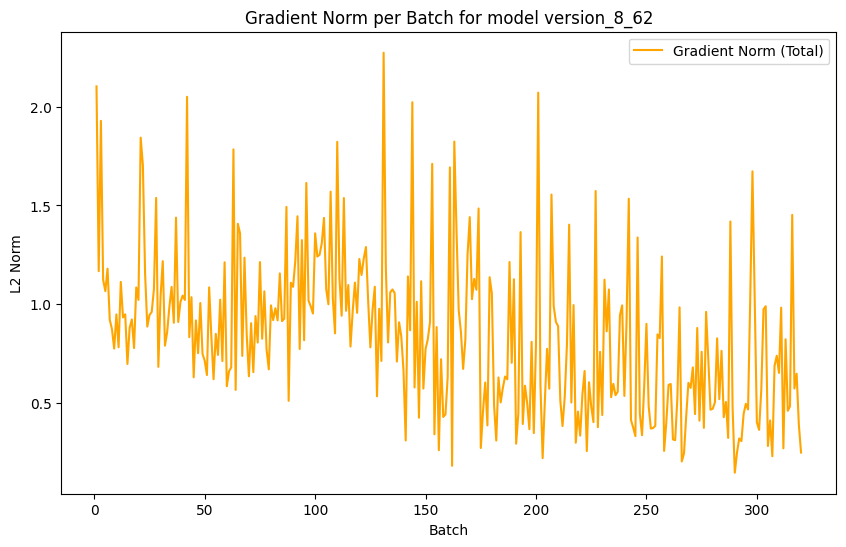

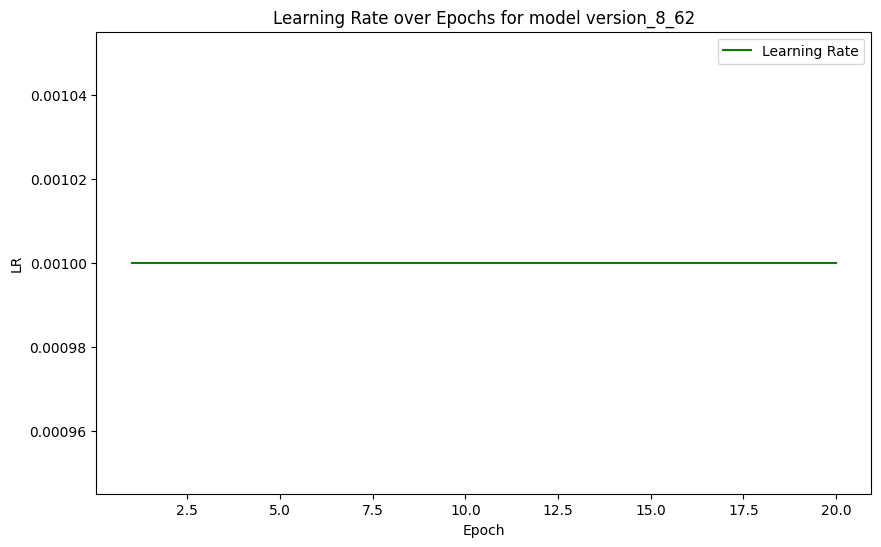

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_9_42 4 4 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.9354, Val Loss=0.8338, Grad Norm=1.2665, LR=0.00010]


New best model saved with val loss: 0.8338


Epoch 2/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.8416, Val Loss=0.7194, Grad Norm=0.9540, LR=0.00010]


New best model saved with val loss: 0.7194


Epoch 3/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.7155, Val Loss=0.5877, Grad Norm=0.7776, LR=0.00010]


New best model saved with val loss: 0.5877


Epoch 4/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.5920, Val Loss=0.4898, Grad Norm=1.3239, LR=0.00010]


New best model saved with val loss: 0.4898


Epoch 5/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.4957, Val Loss=0.3944, Grad Norm=0.7754, LR=0.00010]


New best model saved with val loss: 0.3944


Epoch 6/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.3754, Val Loss=0.2854, Grad Norm=1.4869, LR=0.00010]


New best model saved with val loss: 0.2854


Epoch 7/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.2603, Val Loss=0.1967, Grad Norm=1.1106, LR=0.00010]


New best model saved with val loss: 0.1967


Epoch 8/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.1795, Val Loss=0.1404, Grad Norm=0.9988, LR=0.00010]


New best model saved with val loss: 0.1404


Epoch 9/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.1313, Val Loss=0.1088, Grad Norm=0.2757, LR=0.00010]


New best model saved with val loss: 0.1088


Epoch 10/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0990, Val Loss=0.0870, Grad Norm=0.3036, LR=0.00010]


New best model saved with val loss: 0.0870


Epoch 11/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0827, Val Loss=0.0763, Grad Norm=1.5296, LR=0.00010]


New best model saved with val loss: 0.0763


Epoch 12/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0662, Val Loss=0.0630, Grad Norm=0.5801, LR=0.00010]


New best model saved with val loss: 0.0630


Epoch 13/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0548, Val Loss=0.0545, Grad Norm=1.3917, LR=0.00010]


New best model saved with val loss: 0.0545


Epoch 14/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0473, Val Loss=0.0490, Grad Norm=0.5040, LR=0.00010]


New best model saved with val loss: 0.0490


Epoch 15/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0403, Val Loss=0.0451, Grad Norm=1.2036, LR=0.00010]


New best model saved with val loss: 0.0451


Epoch 16/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0373, Val Loss=0.0426, Grad Norm=0.8170, LR=0.00010]


New best model saved with val loss: 0.0426


Epoch 17/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0347, Val Loss=0.0409, Grad Norm=0.4469, LR=0.00010]


New best model saved with val loss: 0.0409


Epoch 18/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0323, Val Loss=0.0399, Grad Norm=0.3779, LR=0.00010]


New best model saved with val loss: 0.0399


Epoch 19/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0301, Val Loss=0.0396, Grad Norm=1.5876, LR=0.00010]


New best model saved with val loss: 0.0396


Epoch 20/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0297, Val Loss=0.0388, Grad Norm=1.4570, LR=0.00010]


New best model saved with val loss: 0.0388

=== Final Metrics ===
Final Train Loss: 0.0297
Final Val Loss: 0.0388
Generalization Gap: 0.0091
Best Val Epoch: 20
Training Time: 9.35 minutes
Trainable Parameters: 453


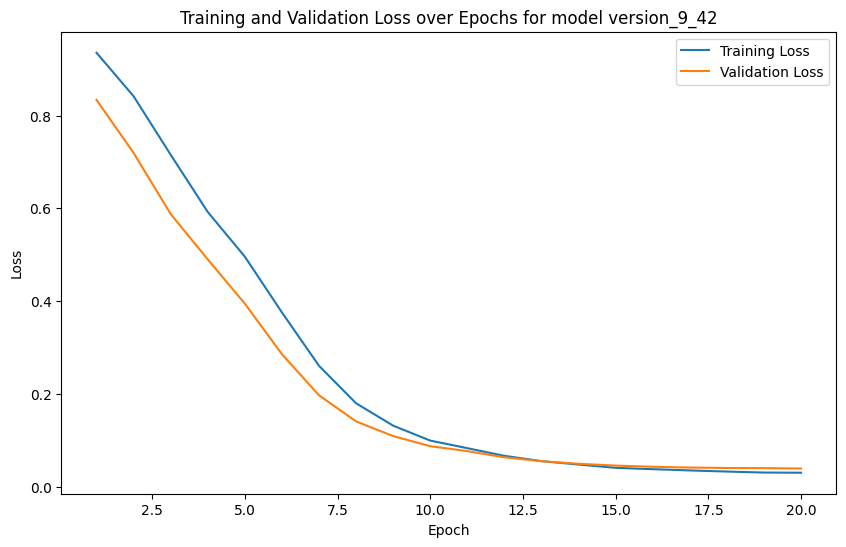

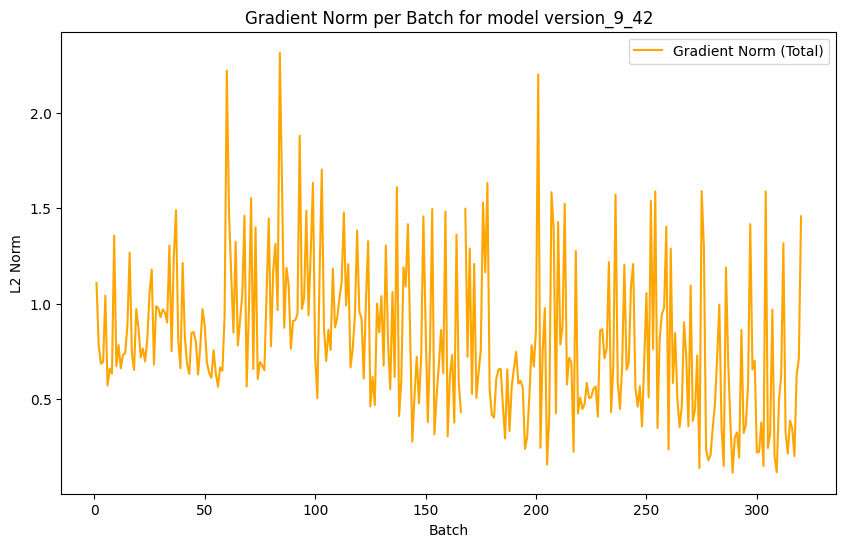

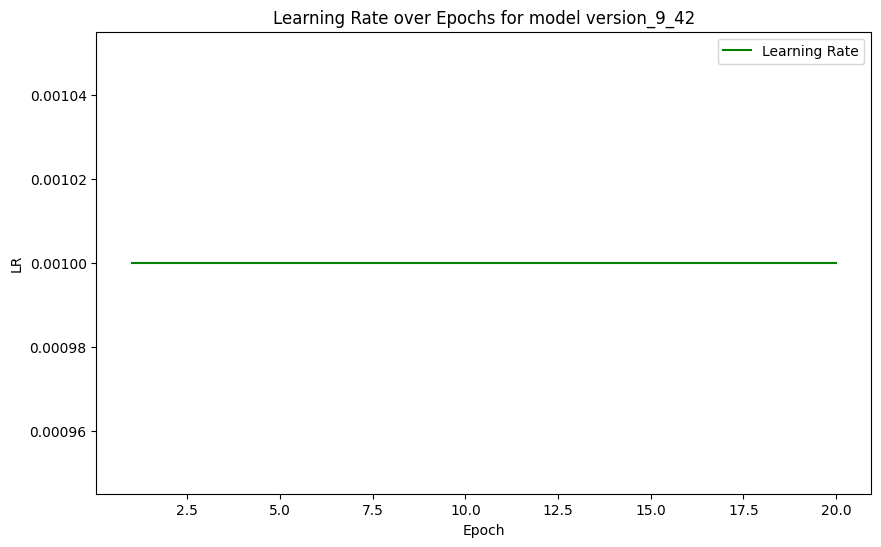

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_9_52 4 4 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.9623, Val Loss=0.8324, Grad Norm=1.2226, LR=0.00010]


New best model saved with val loss: 0.8324


Epoch 2/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.7983, Val Loss=0.6461, Grad Norm=1.3801, LR=0.00010]


New best model saved with val loss: 0.6461


Epoch 3/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.6171, Val Loss=0.4624, Grad Norm=1.1819, LR=0.00010]


New best model saved with val loss: 0.4624


Epoch 4/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.4332, Val Loss=0.3109, Grad Norm=1.0106, LR=0.00010]


New best model saved with val loss: 0.3109


Epoch 5/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.2919, Val Loss=0.2081, Grad Norm=0.6212, LR=0.00010]


New best model saved with val loss: 0.2081


Epoch 6/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.1991, Val Loss=0.1489, Grad Norm=0.6225, LR=0.00010]


New best model saved with val loss: 0.1489


Epoch 7/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.1415, Val Loss=0.1129, Grad Norm=1.1208, LR=0.00010]


New best model saved with val loss: 0.1129


Epoch 8/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.1040, Val Loss=0.0891, Grad Norm=1.3940, LR=0.00010]


New best model saved with val loss: 0.0891


Epoch 9/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.0804, Val Loss=0.0731, Grad Norm=0.8913, LR=0.00010]


New best model saved with val loss: 0.0731


Epoch 10/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.0649, Val Loss=0.0620, Grad Norm=1.1844, LR=0.00010]


New best model saved with val loss: 0.0620


Epoch 11/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0561, Val Loss=0.0579, Grad Norm=1.2194, LR=0.00010]


New best model saved with val loss: 0.0579


Epoch 12/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.0505, Val Loss=0.0529, Grad Norm=0.5343, LR=0.00010]


New best model saved with val loss: 0.0529


Epoch 13/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0465, Val Loss=0.0518, Grad Norm=0.7631, LR=0.00010]


New best model saved with val loss: 0.0518


Epoch 14/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0437, Val Loss=0.0506, Grad Norm=0.7645, LR=0.00010]


New best model saved with val loss: 0.0506


Epoch 15/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0434, Val Loss=0.0501, Grad Norm=1.4703, LR=0.00010]


New best model saved with val loss: 0.0501


Epoch 16/20: 100%|██████████| 32/32 [00:28<00:00,  1.13batch/s, Train Loss=0.0413, Val Loss=0.0478, Grad Norm=0.8912, LR=0.00010]


New best model saved with val loss: 0.0478


Epoch 18/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0377, Val Loss=0.0451, Grad Norm=0.4318, LR=0.00010]


New best model saved with val loss: 0.0451


Epoch 20/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0365, Val Loss=0.0464, Grad Norm=0.4334, LR=0.00010]



=== Final Metrics ===
Final Train Loss: 0.0365
Final Val Loss: 0.0464
Generalization Gap: 0.0099
Best Val Epoch: 18
Training Time: 9.34 minutes
Trainable Parameters: 453


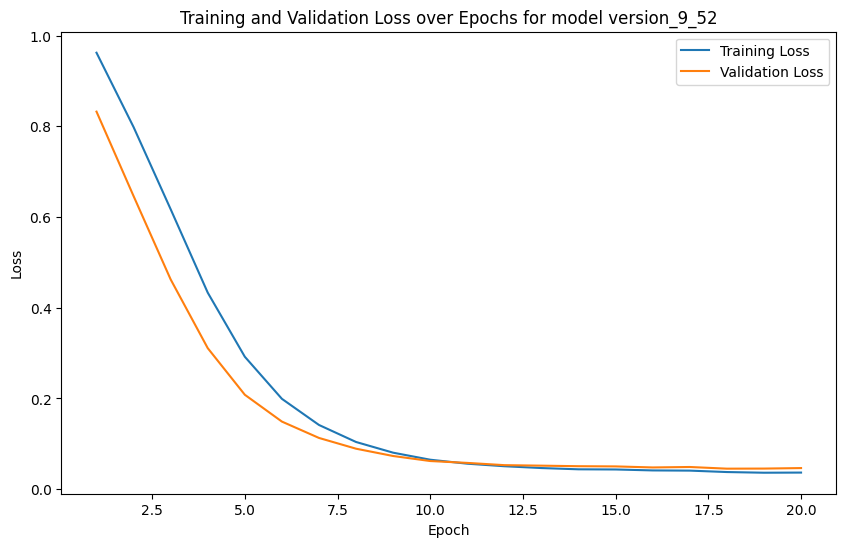

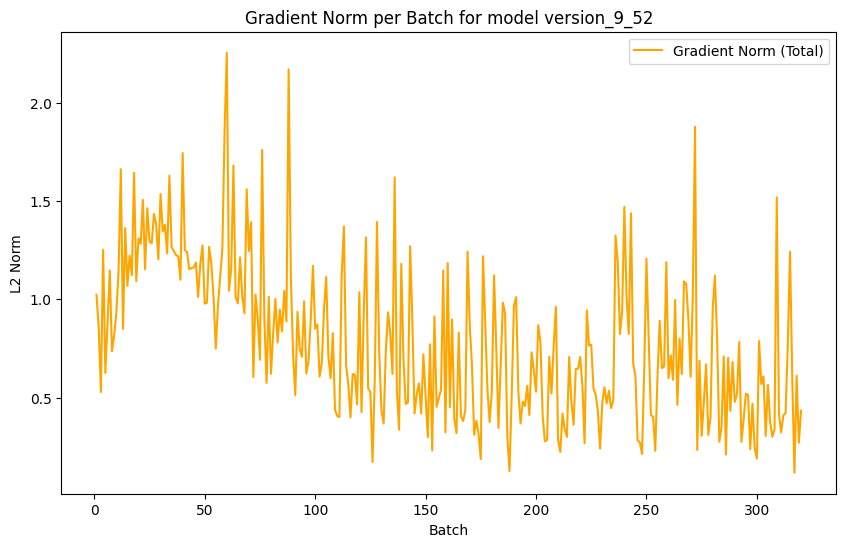

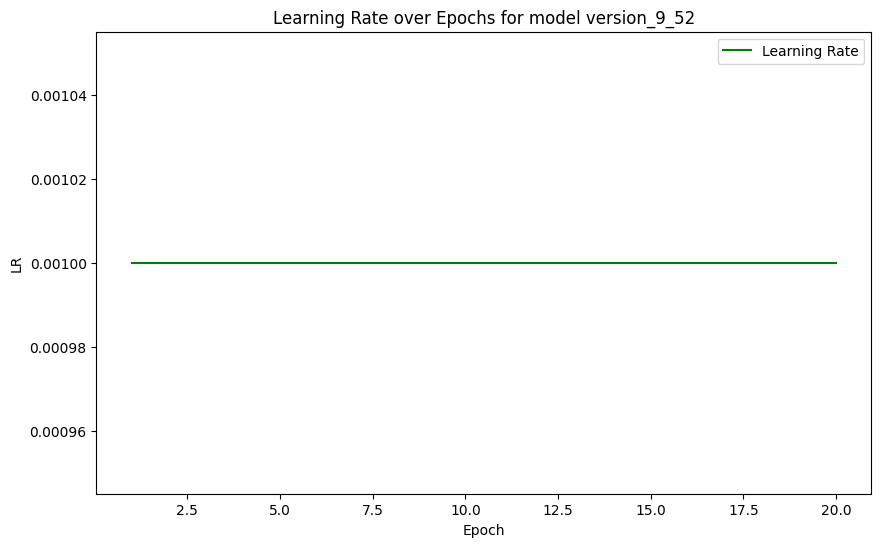

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_9_62 4 4 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=1.0527, Val Loss=0.8922, Grad Norm=0.9243, LR=0.00010]


New best model saved with val loss: 0.8922


Epoch 2/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.8947, Val Loss=0.7721, Grad Norm=0.9181, LR=0.00010]


New best model saved with val loss: 0.7721


Epoch 3/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.7601, Val Loss=0.6272, Grad Norm=1.7087, LR=0.00010]


New best model saved with val loss: 0.6272


Epoch 4/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.6275, Val Loss=0.4997, Grad Norm=1.0014, LR=0.00010]


New best model saved with val loss: 0.4997


Epoch 5/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.4921, Val Loss=0.3822, Grad Norm=0.9051, LR=0.00010]


New best model saved with val loss: 0.3822


Epoch 6/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.3582, Val Loss=0.2691, Grad Norm=4.0344, LR=0.00010]


New best model saved with val loss: 0.2691


Epoch 7/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.2404, Val Loss=0.1709, Grad Norm=0.8357, LR=0.00010]


New best model saved with val loss: 0.1709


Epoch 8/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.1527, Val Loss=0.1287, Grad Norm=1.0866, LR=0.00010]


New best model saved with val loss: 0.1287


Epoch 9/20: 100%|██████████| 32/32 [00:28<00:00,  1.13batch/s, Train Loss=0.1079, Val Loss=0.0995, Grad Norm=1.0721, LR=0.00010]


New best model saved with val loss: 0.0995


Epoch 10/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0831, Val Loss=0.0875, Grad Norm=0.2710, LR=0.00010]


New best model saved with val loss: 0.0875


Epoch 11/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0690, Val Loss=0.0692, Grad Norm=1.2334, LR=0.00010]


New best model saved with val loss: 0.0692


Epoch 12/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0617, Val Loss=0.0667, Grad Norm=2.5790, LR=0.00010]


New best model saved with val loss: 0.0667


Epoch 13/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0530, Val Loss=0.0554, Grad Norm=1.3772, LR=0.00010]


New best model saved with val loss: 0.0554


Epoch 15/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0456, Val Loss=0.0491, Grad Norm=0.7356, LR=0.00010]


New best model saved with val loss: 0.0491


Epoch 16/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0421, Val Loss=0.0471, Grad Norm=0.3794, LR=0.00010]


New best model saved with val loss: 0.0471


Epoch 17/20: 100%|██████████| 32/32 [00:28<00:00,  1.14batch/s, Train Loss=0.0420, Val Loss=0.0459, Grad Norm=0.7590, LR=0.00010]


New best model saved with val loss: 0.0459


Epoch 18/20: 100%|██████████| 32/32 [00:27<00:00,  1.15batch/s, Train Loss=0.0402, Val Loss=0.0451, Grad Norm=1.9300, LR=0.00010]


New best model saved with val loss: 0.0451


Epoch 20/20: 100%|██████████| 32/32 [00:27<00:00,  1.14batch/s, Train Loss=0.0373, Val Loss=0.0443, Grad Norm=1.3283, LR=0.00010]


New best model saved with val loss: 0.0443

=== Final Metrics ===
Final Train Loss: 0.0373
Final Val Loss: 0.0443
Generalization Gap: 0.0070
Best Val Epoch: 20
Training Time: 9.34 minutes
Trainable Parameters: 453


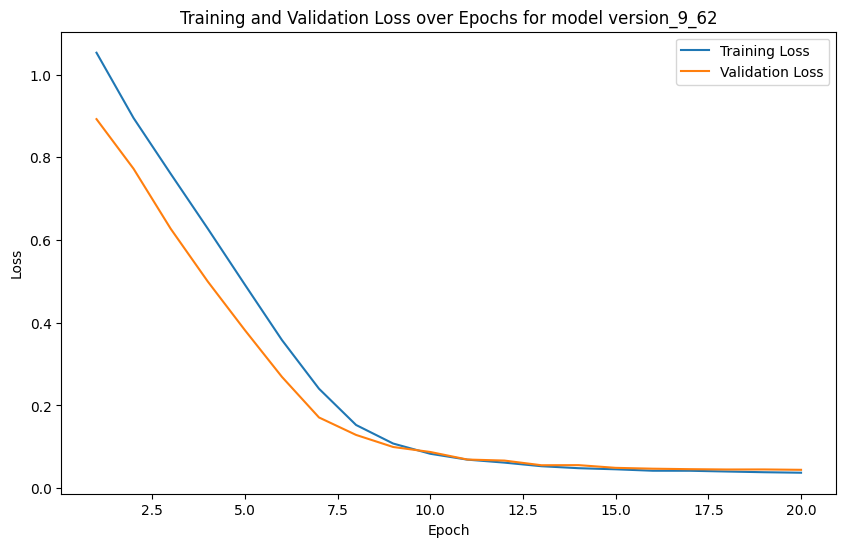

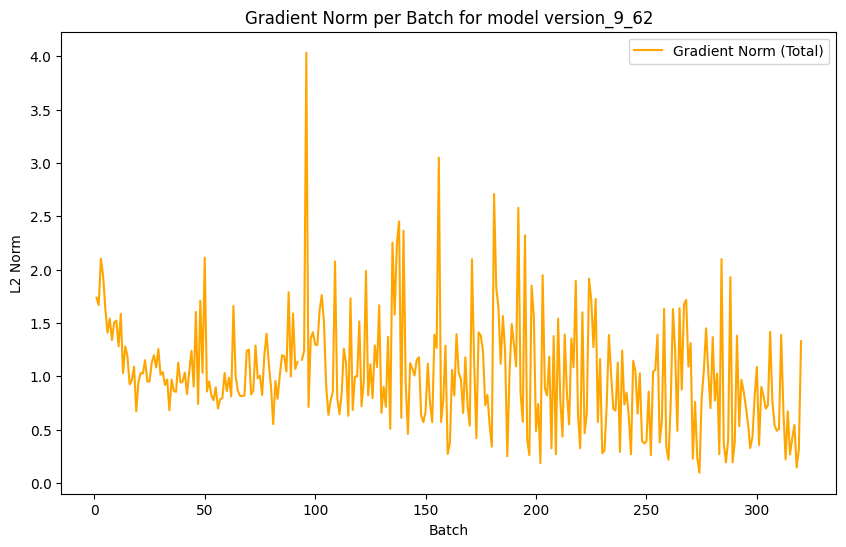

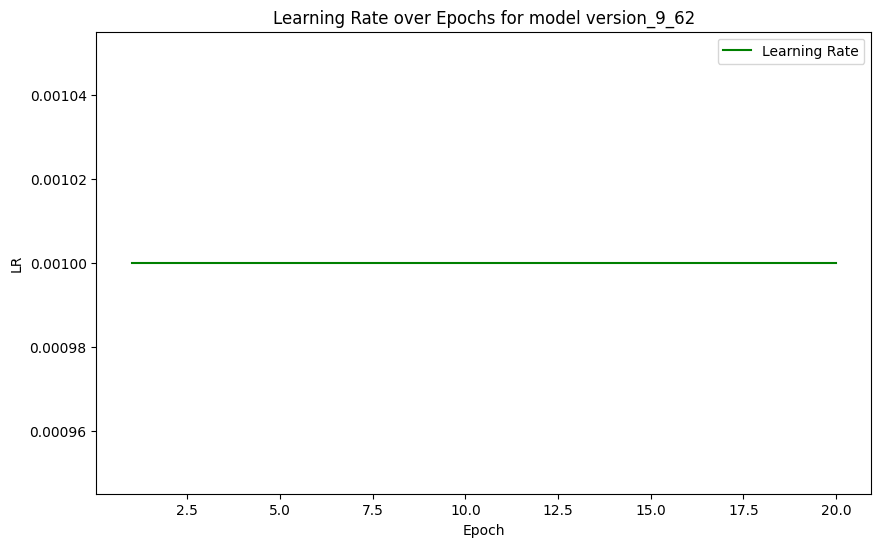

In [ ]:
l = [42,52,62]

# for 2 and 3 qubit 4 layer circuits
# model 5 and 6

c = 4

for num_qubit in range(....):
    for layers in range(....):
        c += 1

        for rs in l:
            # =====================
            # 0. MODEL CONFIGURATION
            # =====================
            # model_name = version_1 for model 1 and 1_1 for model 1 with random seed 1 
            model_name = f"version_{c}_{rs}" 

            # General settings
            USE_GPU = ....
            BATCH_SIZE = ....
            INPUT_DIM = ....
            HIDDEN_DIM = ....
            QUANTUM_OUTPUT_DIM = ....
            POST_HIDDEN_DIM = ....
            FINAL_OUTPUT_DIM = ....
            NUM_SAMPLES = ....
            # Quantum settings
            NUM_QUBITS = num_qubit
            NUM_LAYERS = layers
            RANDOM_SEED = rs  # Set your desired fixed seed


            DIFF_METHOD = "adjoint"


            # =====================
            # 1. Random Seed Configuration
            # =====================

            # Set fixed seed for reproducibility
            torch.manual_seed(RANDOM_SEED)
            torch.cuda.manual_seed_all(RANDOM_SEED)  # if using multiple GPUs

            print(f"Random Seed set to: {RANDOM_SEED}")


            # =====================
            # 0. TRAINING CONFIGURATION
            # =====================

            NUM_EPOCHS = ....
            EARLY_STOP_PATIENCE = ....
            BATCH_SIZE = BATCH_SIZE
            LR_PRE_ENCODER = ....
            LR_QUANTUM = ........
            LR_POST_DECODER =....
            WEIGHT_DECAY = ....
            LR_SCHEDULER_FACTOR = .....
            LR_SCHEDULER_PATIENCE = ....
            SAVE_MODEL_PATH = f"{model_name}.pth"

            # ===========================
            # Random State for Reproducibility
            # ===========================
            RANDOM_STATE = RANDOM_SEED  # Or any other integer of your choice

            # Setting seeds for reproducibility
            torch.manual_seed(RANDOM_STATE)
            np.random.seed(RANDOM_STATE)
            random.seed(RANDOM_STATE)

            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(RANDOM_STATE)  # For CUDA

            print(model_name,NUM_QUBITS,NUM_LAYERS, RANDOM_SEED)
            run()

# for 4 qubit circuits
# model 7,8,9
c = 6

for num_qubit in range(....):
    for layers in range(....):
        c += 1

        for rs in l:
            # =====================
            # 0. MODEL CONFIGURATION
            # =====================
            # model_name = version_1 for model 1 and 1_1 for model 1 with random seed 1 
            model_name = f"version_{c}_{rs}" 

            # General settings
            USE_GPU = True
            BATCH_SIZE = ....
            INPUT_DIM = ....
            HIDDEN_DIM = ....
            QUANTUM_OUTPUT_DIM = ....
            POST_HIDDEN_DIM = ....
            FINAL_OUTPUT_DIM = ....
            NUM_SAMPLES = ....  # Limit dataset to 1000 samples

            # Quantum settings
            NUM_QUBITS = num_qubit
            NUM_LAYERS = layers
            RANDOM_SEED = rs  # Set your desired fixed seed


            DIFF_METHOD = "...."


            # =====================
            # 1. Random Seed Configuration
            # =====================

            # Set fixed seed for reproducibility
            torch.manual_seed(RANDOM_SEED)
            torch.cuda.manual_seed_all(RANDOM_SEED)  # if using multiple GPUs

            print(f"Random Seed set to: {RANDOM_SEED}")


            # =====================
            # 0. TRAINING CONFIGURATION
            # =====================

            NUM_EPOCHS = ....
            EARLY_STOP_PATIENCE = ....
            BATCH_SIZE = BATCH_SIZE
            LR_PRE_ENCODER = 0.....
            LR_QUANTUM = 0.....
            LR_POST_DECODER = 0.....
            WEIGHT_DECAY = 0.....
            LR_SCHEDULER_FACTOR = 0.....
            LR_SCHEDULER_PATIENCE = ....
            SAVE_MODEL_PATH = f"{model_name}.pth"

            # ===========================
            # Random State for Reproducibility
            # ===========================
            RANDOM_STATE = RANDOM_SEED  # Or any other integer of your choice

            # Setting seeds for reproducibility
            torch.manual_seed(RANDOM_STATE)
            np.random.seed(RANDOM_STATE)
            random.seed(RANDOM_STATE)

            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(RANDOM_STATE)  # For CUDA

            print(model_name,NUM_QUBITS,NUM_LAYERS, RANDOM_SEED)
            run()


/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_10_42, QUBIT: 5,LAYER: 2,SEED: 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.9873, Val Loss=0.8709, Grad Norm=0.9921, LR=0.00010]


New best model saved with val loss: 0.8709


Epoch 2/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.8728, Val Loss=0.7470, Grad Norm=1.1663, LR=0.00010]


New best model saved with val loss: 0.7470


Epoch 3/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.7246, Val Loss=0.5698, Grad Norm=0.9458, LR=0.00010]


New best model saved with val loss: 0.5698


Epoch 4/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.5252, Val Loss=0.3699, Grad Norm=1.3403, LR=0.00010]


New best model saved with val loss: 0.3699


Epoch 5/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.3369, Val Loss=0.2269, Grad Norm=1.1844, LR=0.00010]


New best model saved with val loss: 0.2269


Epoch 6/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.2101, Val Loss=0.1426, Grad Norm=1.1618, LR=0.00010]


New best model saved with val loss: 0.1426


Epoch 7/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.1324, Val Loss=0.0943, Grad Norm=0.8979, LR=0.00010]


New best model saved with val loss: 0.0943


Epoch 8/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0857, Val Loss=0.0693, Grad Norm=0.9595, LR=0.00010]


New best model saved with val loss: 0.0693


Epoch 9/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0623, Val Loss=0.0580, Grad Norm=0.5558, LR=0.00010]


New best model saved with val loss: 0.0580


Epoch 10/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0507, Val Loss=0.0529, Grad Norm=0.2823, LR=0.00010]


New best model saved with val loss: 0.0529


Epoch 11/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0446, Val Loss=0.0493, Grad Norm=0.3178, LR=0.00010]


New best model saved with val loss: 0.0493


Epoch 12/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0408, Val Loss=0.0483, Grad Norm=1.0054, LR=0.00010]


New best model saved with val loss: 0.0483


Epoch 13/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0387, Val Loss=0.0472, Grad Norm=0.8756, LR=0.00010]


New best model saved with val loss: 0.0472


Epoch 14/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.0364, Val Loss=0.0441, Grad Norm=0.5085, LR=0.00010]


New best model saved with val loss: 0.0441


Epoch 16/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0334, Val Loss=0.0432, Grad Norm=0.5096, LR=0.00010]


New best model saved with val loss: 0.0432


Epoch 17/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0319, Val Loss=0.0425, Grad Norm=2.2364, LR=0.00010]


New best model saved with val loss: 0.0425


Epoch 18/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0319, Val Loss=0.0424, Grad Norm=0.7680, LR=0.00010]


New best model saved with val loss: 0.0424


Epoch 19/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0312, Val Loss=0.0422, Grad Norm=0.5238, LR=0.00010]


New best model saved with val loss: 0.0422


Epoch 20/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0305, Val Loss=0.0412, Grad Norm=0.7152, LR=0.00010]


New best model saved with val loss: 0.0412

=== Final Metrics ===
Final Train Loss: 0.0305
Final Val Loss: 0.0412
Generalization Gap: 0.0107
Best Val Epoch: 20
Training Time: 8.87 minutes
Trainable Parameters: 496


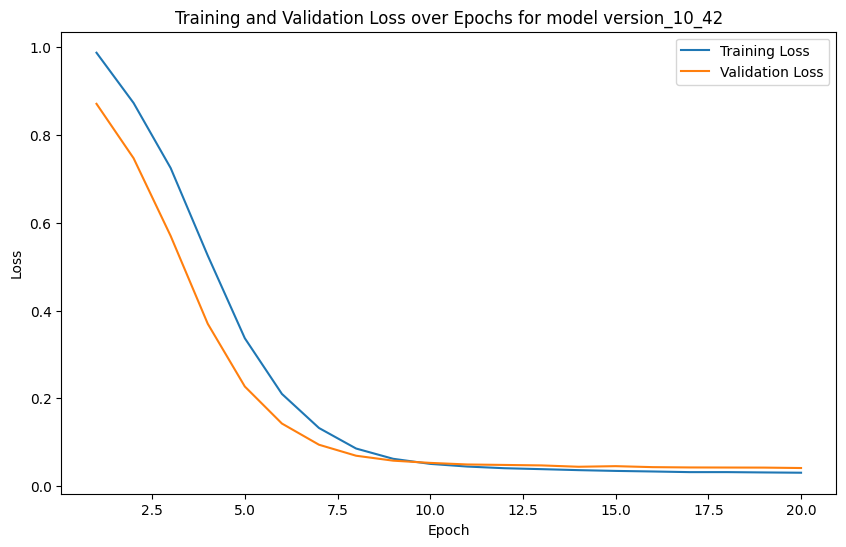

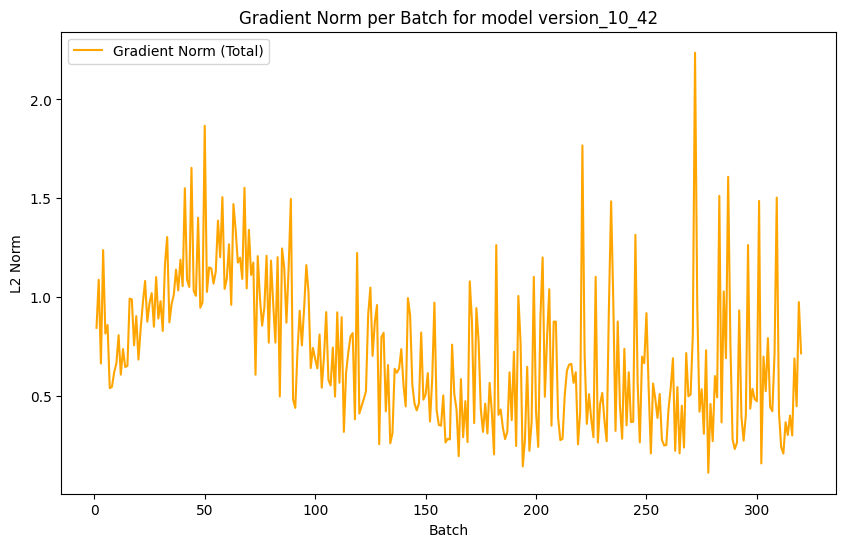

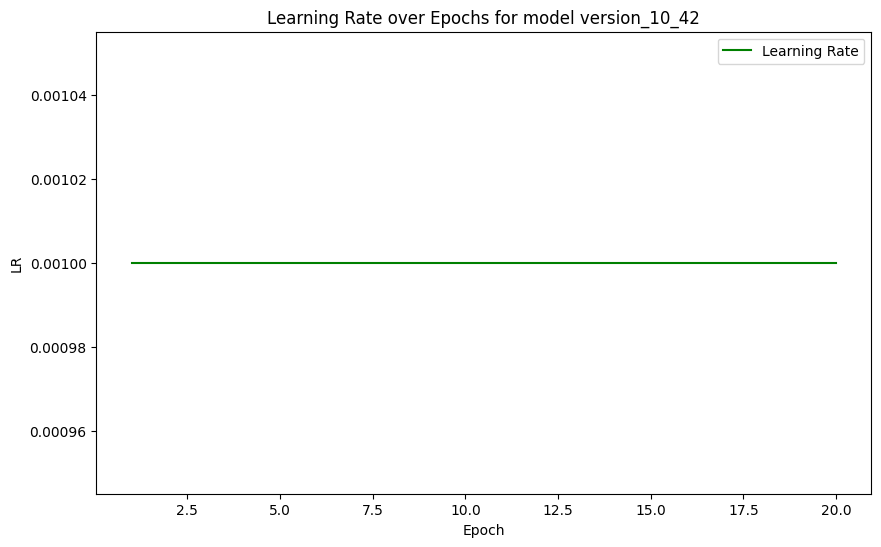

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_10_52, QUBIT: 5,LAYER: 2,SEED: 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.9058, Val Loss=0.7764, Grad Norm=0.9623, LR=0.00010]


New best model saved with val loss: 0.7764


Epoch 2/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.7670, Val Loss=0.6280, Grad Norm=1.9608, LR=0.00010]


New best model saved with val loss: 0.6280


Epoch 3/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.5984, Val Loss=0.4552, Grad Norm=1.6248, LR=0.00010]


New best model saved with val loss: 0.4552


Epoch 4/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.4097, Val Loss=0.2971, Grad Norm=inf, LR=0.00010]


New best model saved with val loss: 0.2971


Epoch 5/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.2618, Val Loss=0.1714, Grad Norm=0.9331, LR=0.00010]


New best model saved with val loss: 0.1714


Epoch 6/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.1585, Val Loss=0.1168, Grad Norm=0.7869, LR=0.00010]


New best model saved with val loss: 0.1168


Epoch 7/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.1098, Val Loss=0.0837, Grad Norm=0.5050, LR=0.00010]


New best model saved with val loss: 0.0837


Epoch 8/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0828, Val Loss=0.0713, Grad Norm=0.7531, LR=0.00010]


New best model saved with val loss: 0.0713


Epoch 9/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0672, Val Loss=0.0619, Grad Norm=0.4976, LR=0.00010]


New best model saved with val loss: 0.0619


Epoch 10/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0579, Val Loss=0.0582, Grad Norm=0.8509, LR=0.00010]


New best model saved with val loss: 0.0582


Epoch 11/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0524, Val Loss=0.0549, Grad Norm=0.6762, LR=0.00010]


New best model saved with val loss: 0.0549


Epoch 12/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0482, Val Loss=0.0528, Grad Norm=1.2611, LR=0.00010]


New best model saved with val loss: 0.0528


Epoch 13/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0467, Val Loss=0.0518, Grad Norm=0.4407, LR=0.00010]


New best model saved with val loss: 0.0518


Epoch 14/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0432, Val Loss=0.0480, Grad Norm=0.3602, LR=0.00010]


New best model saved with val loss: 0.0480


Epoch 15/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0408, Val Loss=0.0460, Grad Norm=0.5388, LR=0.00010]


New best model saved with val loss: 0.0460


Epoch 16/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0390, Val Loss=0.0451, Grad Norm=1.0770, LR=0.00010]


New best model saved with val loss: 0.0451


Epoch 17/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0362, Val Loss=0.0426, Grad Norm=0.8320, LR=0.00010]


New best model saved with val loss: 0.0426


Epoch 18/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0345, Val Loss=0.0416, Grad Norm=1.4360, LR=0.00010]


New best model saved with val loss: 0.0416


Epoch 19/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0344, Val Loss=0.0408, Grad Norm=0.4850, LR=0.00010]


New best model saved with val loss: 0.0408


Epoch 20/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0322, Val Loss=0.0402, Grad Norm=1.3234, LR=0.00010]


New best model saved with val loss: 0.0402

=== Final Metrics ===
Final Train Loss: 0.0322
Final Val Loss: 0.0402
Generalization Gap: 0.0080
Best Val Epoch: 20
Training Time: 8.89 minutes
Trainable Parameters: 496


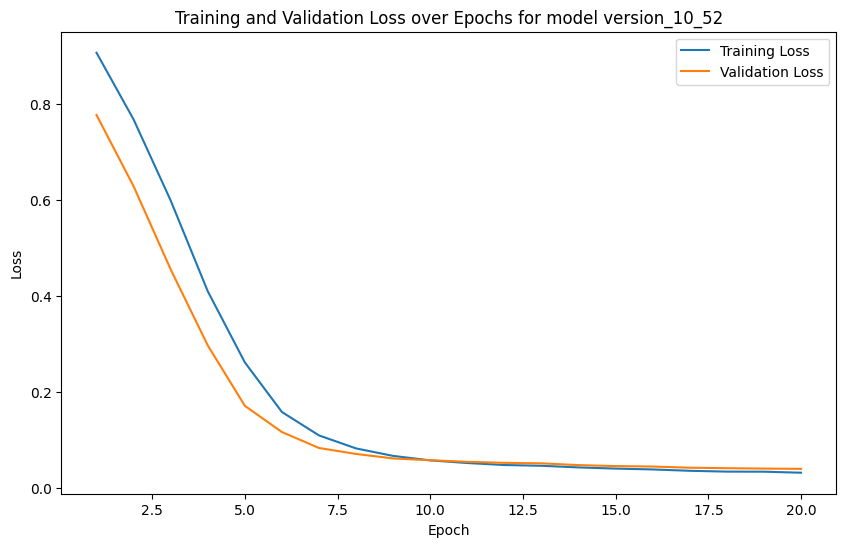

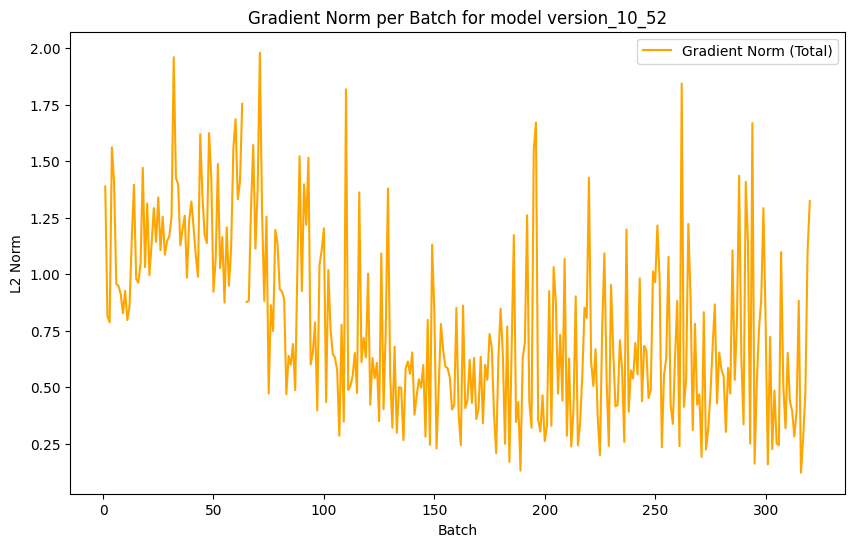

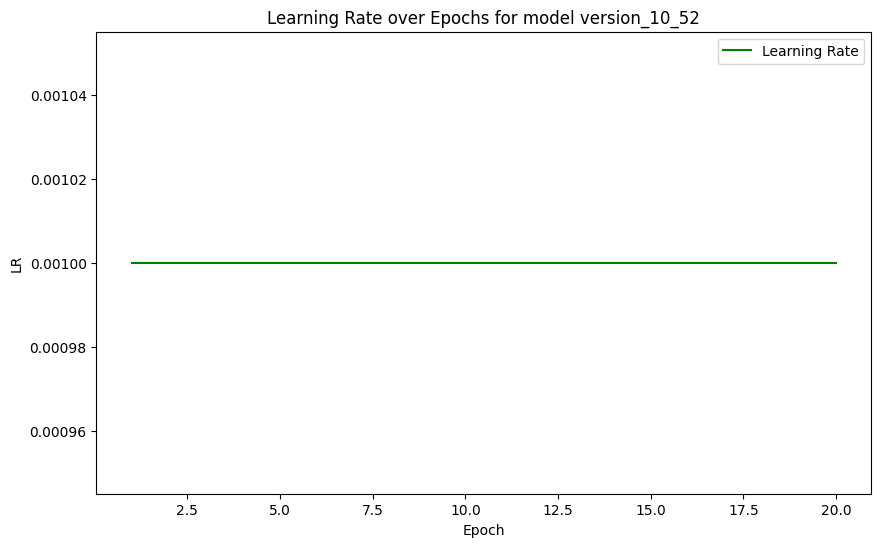

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_10_62, QUBIT: 5,LAYER: 2,SEED: 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.8090, Val Loss=0.6570, Grad Norm=0.8949, LR=0.00010]


New best model saved with val loss: 0.6570


Epoch 2/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.6339, Val Loss=0.4866, Grad Norm=1.2024, LR=0.00010]


New best model saved with val loss: 0.4866


Epoch 3/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.4608, Val Loss=0.3261, Grad Norm=0.9942, LR=0.00010]


New best model saved with val loss: 0.3261


Epoch 4/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.3082, Val Loss=0.2001, Grad Norm=0.6434, LR=0.00010]


New best model saved with val loss: 0.2001


Epoch 5/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.1858, Val Loss=0.1255, Grad Norm=0.9447, LR=0.00010]


New best model saved with val loss: 0.1255


Epoch 6/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.1150, Val Loss=0.0866, Grad Norm=0.4465, LR=0.00010]


New best model saved with val loss: 0.0866


Epoch 7/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.0792, Val Loss=0.0701, Grad Norm=1.3025, LR=0.00010]


New best model saved with val loss: 0.0701


Epoch 8/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0616, Val Loss=0.0617, Grad Norm=0.6672, LR=0.00010]


New best model saved with val loss: 0.0617


Epoch 9/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0525, Val Loss=0.0535, Grad Norm=0.9377, LR=0.00010]


New best model saved with val loss: 0.0535


Epoch 10/20: 100%|██████████| 32/32 [00:26<00:00,  1.20batch/s, Train Loss=0.0465, Val Loss=0.0520, Grad Norm=0.3322, LR=0.00010]


New best model saved with val loss: 0.0520


Epoch 11/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.0428, Val Loss=0.0488, Grad Norm=0.8926, LR=0.00010]


New best model saved with val loss: 0.0488


Epoch 12/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.0393, Val Loss=0.0451, Grad Norm=0.6636, LR=0.00010]


New best model saved with val loss: 0.0451


Epoch 14/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.0360, Val Loss=0.0437, Grad Norm=0.5652, LR=0.00010]


New best model saved with val loss: 0.0437


Epoch 16/20: 100%|██████████| 32/32 [00:26<00:00,  1.21batch/s, Train Loss=0.0341, Val Loss=0.0423, Grad Norm=0.6968, LR=0.00010]


New best model saved with val loss: 0.0423


Epoch 20/20: 100%|██████████| 32/32 [00:26<00:00,  1.19batch/s, Train Loss=0.0330, Val Loss=0.0420, Grad Norm=0.2455, LR=0.00010]


New best model saved with val loss: 0.0420

=== Final Metrics ===
Final Train Loss: 0.0330
Final Val Loss: 0.0420
Generalization Gap: 0.0090
Best Val Epoch: 20
Training Time: 8.91 minutes
Trainable Parameters: 496


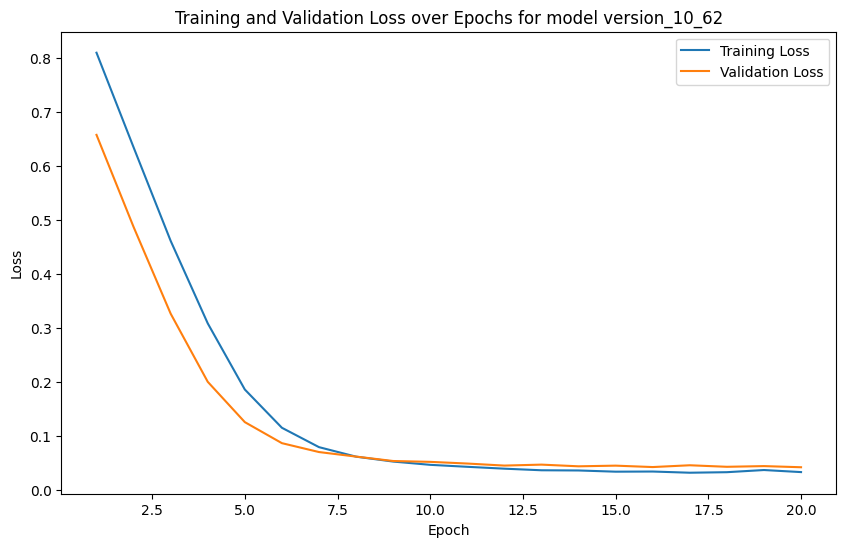

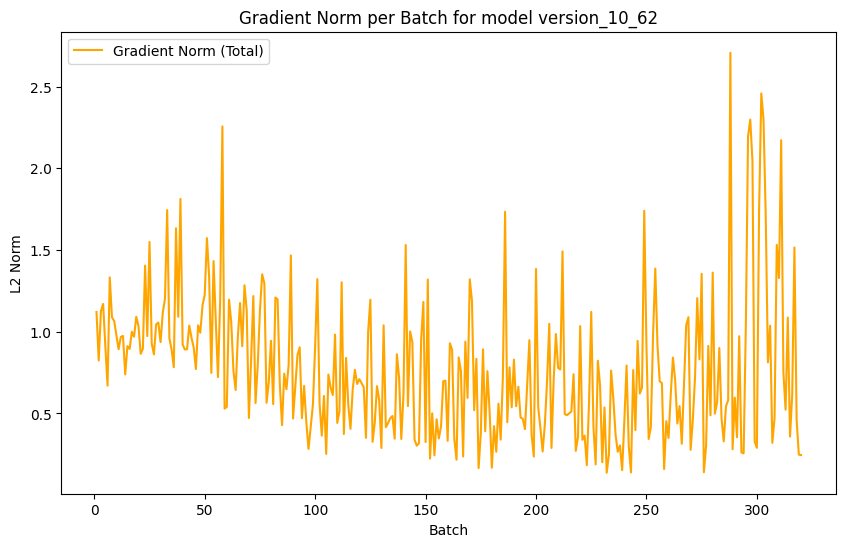

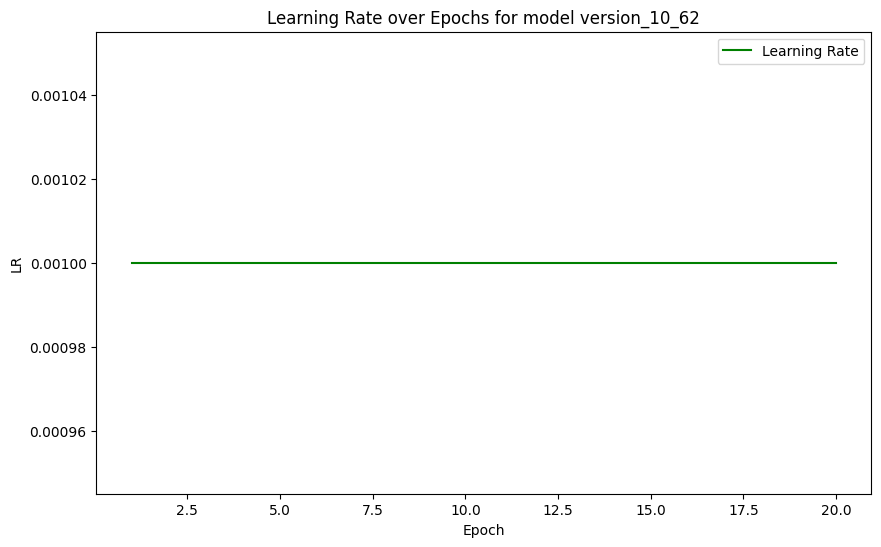

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_11_42, QUBIT: 5,LAYER: 3,SEED: 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:33<00:00,  1.04s/batch, Train Loss=0.9658, Val Loss=0.8470, Grad Norm=0.7430, LR=0.00010]


New best model saved with val loss: 0.8470


Epoch 2/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.8481, Val Loss=0.7210, Grad Norm=1.0356, LR=0.00010]


New best model saved with val loss: 0.7210


Epoch 3/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.7101, Val Loss=0.5726, Grad Norm=0.7644, LR=0.00010]


New best model saved with val loss: 0.5726


Epoch 4/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.5565, Val Loss=0.4184, Grad Norm=2.1516, LR=0.00010]


New best model saved with val loss: 0.4184


Epoch 5/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.3966, Val Loss=0.2775, Grad Norm=0.9417, LR=0.00010]


New best model saved with val loss: 0.2775


Epoch 6/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.2473, Val Loss=0.1594, Grad Norm=1.9078, LR=0.00010]


New best model saved with val loss: 0.1594


Epoch 7/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.1416, Val Loss=0.1096, Grad Norm=0.2962, LR=0.00010]


New best model saved with val loss: 0.1096


Epoch 8/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0914, Val Loss=0.0712, Grad Norm=1.2158, LR=0.00010]


New best model saved with val loss: 0.0712


Epoch 9/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0644, Val Loss=0.0555, Grad Norm=1.3267, LR=0.00010]


New best model saved with val loss: 0.0555


Epoch 10/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0491, Val Loss=0.0489, Grad Norm=0.7136, LR=0.00010]


New best model saved with val loss: 0.0489


Epoch 11/20: 100%|██████████| 32/32 [00:33<00:00,  1.03s/batch, Train Loss=0.0416, Val Loss=0.0469, Grad Norm=2.4991, LR=0.00010]


New best model saved with val loss: 0.0469


Epoch 12/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0392, Val Loss=0.0428, Grad Norm=1.0348, LR=0.00010]


New best model saved with val loss: 0.0428


Epoch 14/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0365, Val Loss=0.0413, Grad Norm=1.5585, LR=0.00010]


New best model saved with val loss: 0.0413


Epoch 17/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0333, Val Loss=0.0404, Grad Norm=1.7721, LR=0.00010]


New best model saved with val loss: 0.0404


Epoch 19/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0309, Val Loss=0.0391, Grad Norm=1.5062, LR=0.00010]


New best model saved with val loss: 0.0391


Epoch 20/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0303, Val Loss=0.0391, Grad Norm=0.2015, LR=0.00010]


New best model saved with val loss: 0.0391

=== Final Metrics ===
Final Train Loss: 0.0303
Final Val Loss: 0.0391
Generalization Gap: 0.0088
Best Val Epoch: 20
Training Time: 10.95 minutes
Trainable Parameters: 501


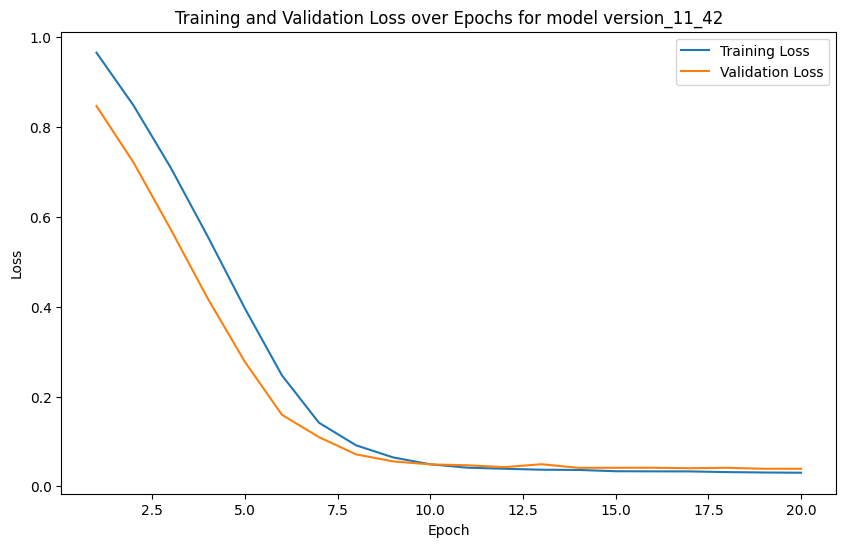

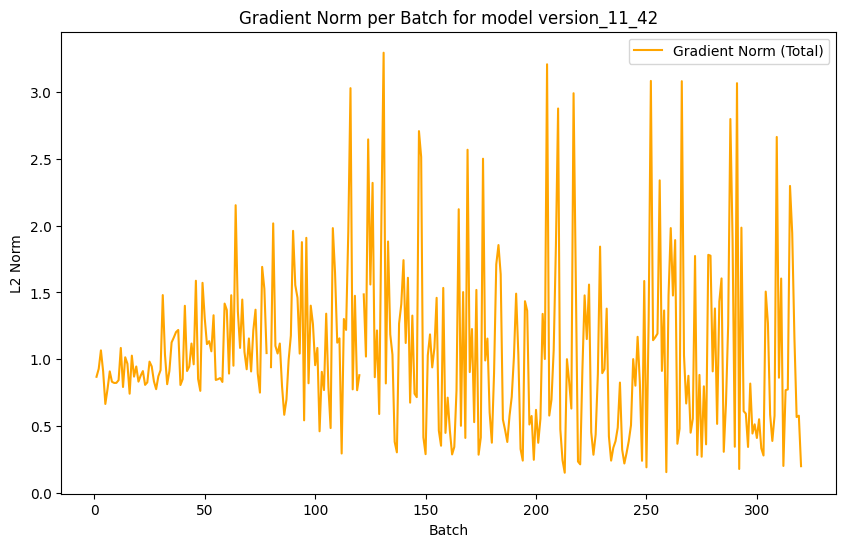

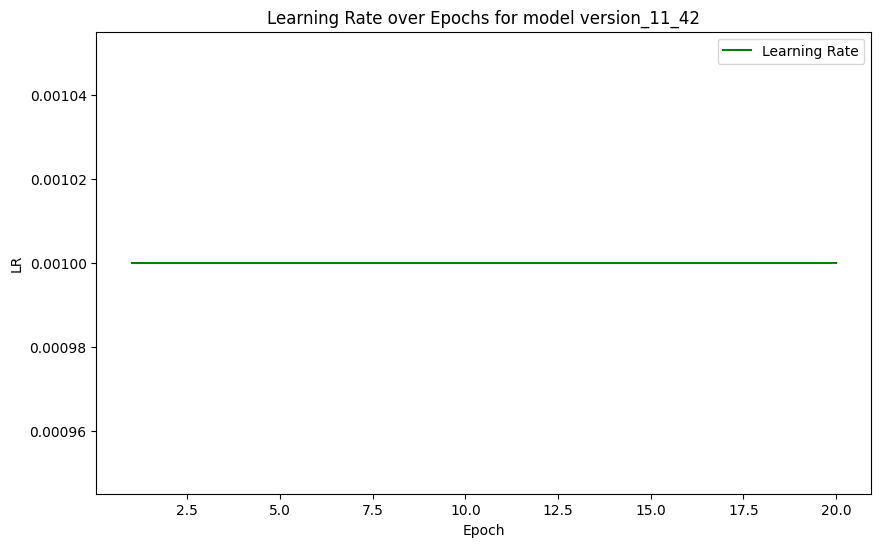

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_11_52, QUBIT: 5,LAYER: 3,SEED: 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.9613, Val Loss=0.8482, Grad Norm=1.8462, LR=0.00010]


New best model saved with val loss: 0.8482


Epoch 2/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.8177, Val Loss=0.6905, Grad Norm=0.6442, LR=0.00010]


New best model saved with val loss: 0.6905


Epoch 3/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.6683, Val Loss=0.5386, Grad Norm=0.7709, LR=0.00010]


New best model saved with val loss: 0.5386


Epoch 4/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.5103, Val Loss=0.3958, Grad Norm=2.3414, LR=0.00010]


New best model saved with val loss: 0.3958


Epoch 5/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.3749, Val Loss=0.2620, Grad Norm=1.1984, LR=0.00010]


New best model saved with val loss: 0.2620


Epoch 6/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.2345, Val Loss=0.1578, Grad Norm=0.6799, LR=0.00010]


New best model saved with val loss: 0.1578


Epoch 7/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.1456, Val Loss=0.0983, Grad Norm=0.6462, LR=0.00010]


New best model saved with val loss: 0.0983


Epoch 8/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0921, Val Loss=0.0759, Grad Norm=1.1550, LR=0.00010]


New best model saved with val loss: 0.0759


Epoch 9/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0705, Val Loss=0.0624, Grad Norm=2.1136, LR=0.00010]


New best model saved with val loss: 0.0624


Epoch 10/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0554, Val Loss=0.0544, Grad Norm=0.4009, LR=0.00010]


New best model saved with val loss: 0.0544


Epoch 11/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0469, Val Loss=0.0502, Grad Norm=0.3804, LR=0.00010]


New best model saved with val loss: 0.0502


Epoch 12/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0439, Val Loss=0.0484, Grad Norm=0.4377, LR=0.00010]


New best model saved with val loss: 0.0484


Epoch 13/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0404, Val Loss=0.0475, Grad Norm=1.9066, LR=0.00010]


New best model saved with val loss: 0.0475


Epoch 14/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0392, Val Loss=0.0456, Grad Norm=0.7913, LR=0.00010]


New best model saved with val loss: 0.0456


Epoch 17/20: 100%|██████████| 32/32 [00:33<00:00,  1.04s/batch, Train Loss=0.0351, Val Loss=0.0441, Grad Norm=1.4533, LR=0.00010]


New best model saved with val loss: 0.0441


Epoch 19/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0337, Val Loss=0.0438, Grad Norm=0.7162, LR=0.00010]


New best model saved with val loss: 0.0438


Epoch 20/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0340, Val Loss=0.0411, Grad Norm=0.3576, LR=0.00010]


New best model saved with val loss: 0.0411

=== Final Metrics ===
Final Train Loss: 0.0340
Final Val Loss: 0.0411
Generalization Gap: 0.0071
Best Val Epoch: 20
Training Time: 10.93 minutes
Trainable Parameters: 501


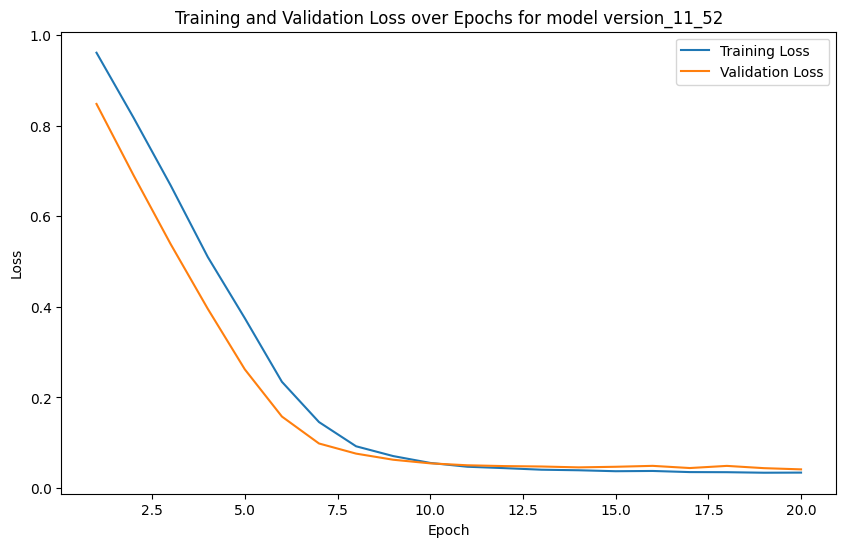

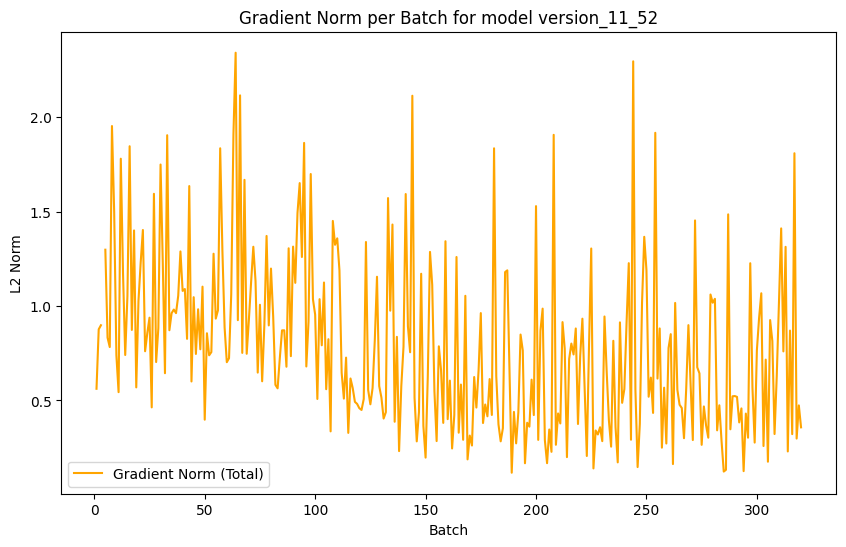

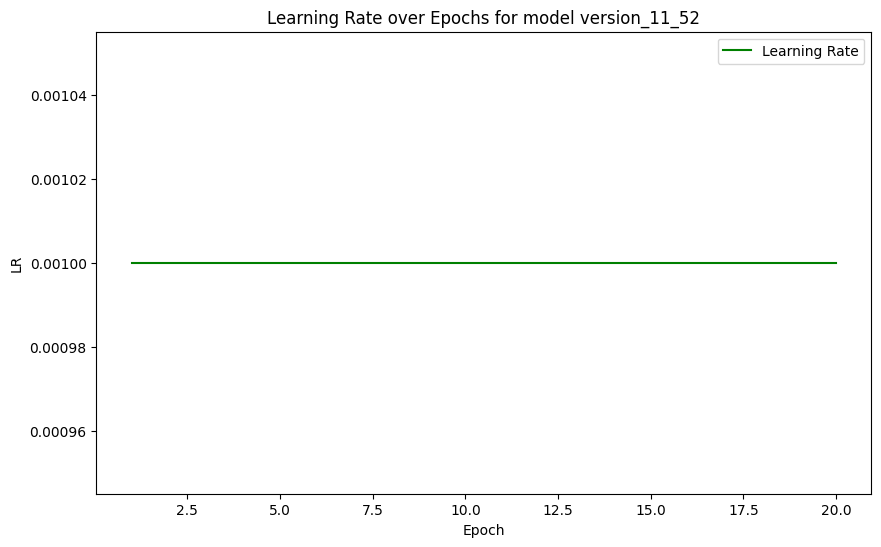

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_11_62, QUBIT: 5,LAYER: 3,SEED: 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:33<00:00,  1.04s/batch, Train Loss=0.9782, Val Loss=0.8445, Grad Norm=0.8757, LR=0.00010]


New best model saved with val loss: 0.8445


Epoch 2/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.8290, Val Loss=0.6964, Grad Norm=1.6231, LR=0.00010]


New best model saved with val loss: 0.6964


Epoch 3/20: 100%|██████████| 32/32 [00:33<00:00,  1.03s/batch, Train Loss=0.6922, Val Loss=0.5869, Grad Norm=1.1007, LR=0.00010]


New best model saved with val loss: 0.5869


Epoch 4/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.6105, Val Loss=0.5086, Grad Norm=0.6286, LR=0.00010]


New best model saved with val loss: 0.5086


Epoch 5/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.5359, Val Loss=0.4348, Grad Norm=0.7182, LR=0.00010]


New best model saved with val loss: 0.4348


Epoch 6/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.4435, Val Loss=0.3321, Grad Norm=1.1559, LR=0.00010]


New best model saved with val loss: 0.3321


Epoch 7/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.3219, Val Loss=0.2185, Grad Norm=0.4757, LR=0.00010]


New best model saved with val loss: 0.2185


Epoch 8/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.1997, Val Loss=0.1324, Grad Norm=0.9203, LR=0.00010]


New best model saved with val loss: 0.1324


Epoch 9/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.1158, Val Loss=0.0991, Grad Norm=0.5070, LR=0.00010]


New best model saved with val loss: 0.0991


Epoch 10/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0834, Val Loss=0.0837, Grad Norm=0.3786, LR=0.00010]


New best model saved with val loss: 0.0837


Epoch 11/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0680, Val Loss=0.0727, Grad Norm=0.7156, LR=0.00010]


New best model saved with val loss: 0.0727


Epoch 12/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0601, Val Loss=0.0639, Grad Norm=1.0477, LR=0.00010]


New best model saved with val loss: 0.0639


Epoch 13/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0550, Val Loss=0.0587, Grad Norm=0.4333, LR=0.00010]


New best model saved with val loss: 0.0587


Epoch 14/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0509, Val Loss=0.0549, Grad Norm=0.4627, LR=0.00010]


New best model saved with val loss: 0.0549


Epoch 15/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0464, Val Loss=0.0503, Grad Norm=0.6342, LR=0.00010]


New best model saved with val loss: 0.0503


Epoch 16/20: 100%|██████████| 32/32 [00:32<00:00,  1.02s/batch, Train Loss=0.0427, Val Loss=0.0490, Grad Norm=0.5686, LR=0.00010]


New best model saved with val loss: 0.0490


Epoch 17/20: 100%|██████████| 32/32 [00:33<00:00,  1.03s/batch, Train Loss=0.0403, Val Loss=0.0458, Grad Norm=0.3259, LR=0.00010]


New best model saved with val loss: 0.0458


Epoch 18/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0379, Val Loss=0.0436, Grad Norm=0.2571, LR=0.00010]


New best model saved with val loss: 0.0436


Epoch 20/20: 100%|██████████| 32/32 [00:32<00:00,  1.03s/batch, Train Loss=0.0349, Val Loss=0.0425, Grad Norm=0.3338, LR=0.00010]


New best model saved with val loss: 0.0425

=== Final Metrics ===
Final Train Loss: 0.0349
Final Val Loss: 0.0425
Generalization Gap: 0.0076
Best Val Epoch: 20
Training Time: 10.94 minutes
Trainable Parameters: 501


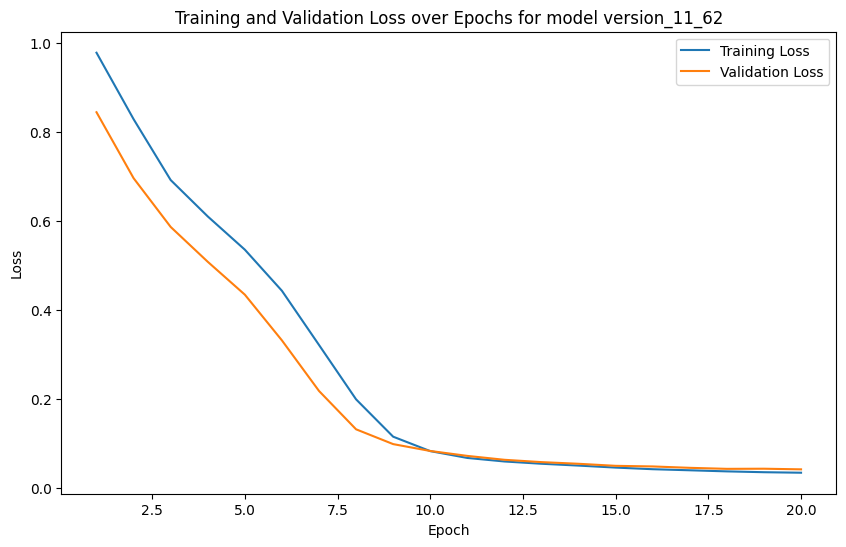

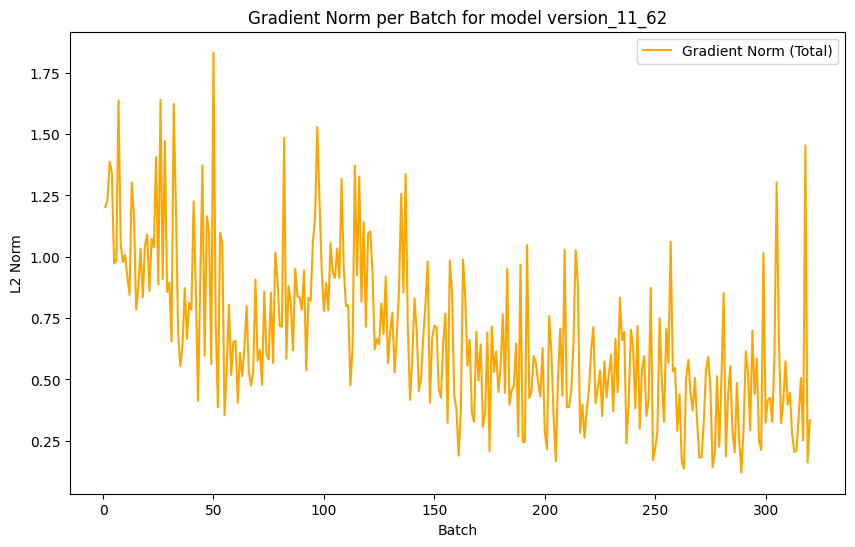

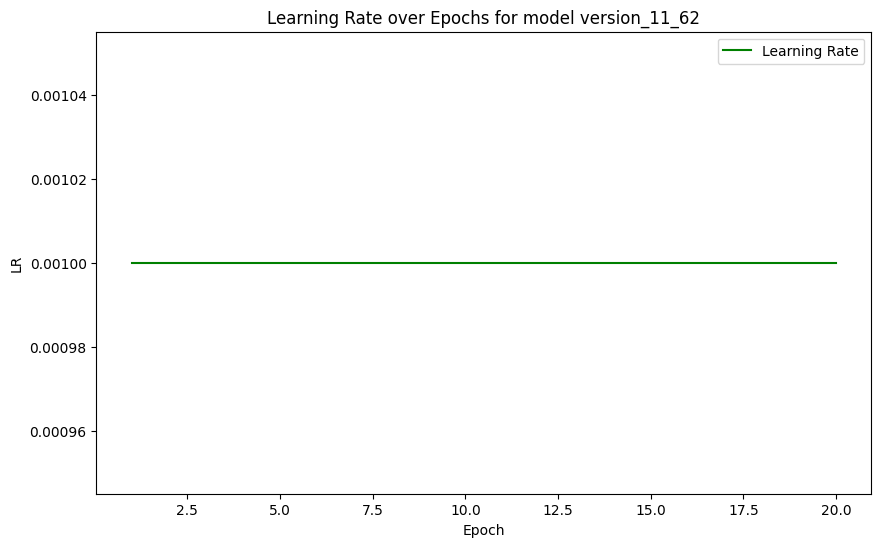

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 42
version_12_42, QUBIT: 5,LAYER: 4,SEED: 42
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.9366, Val Loss=0.8155, Grad Norm=0.9850, LR=0.00010]


New best model saved with val loss: 0.8155


Epoch 2/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.8135, Val Loss=0.6808, Grad Norm=0.8814, LR=0.00010]


New best model saved with val loss: 0.6808


Epoch 3/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.6766, Val Loss=0.5353, Grad Norm=0.7988, LR=0.00010]


New best model saved with val loss: 0.5353


Epoch 4/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.5288, Val Loss=0.3953, Grad Norm=1.0529, LR=0.00010]


New best model saved with val loss: 0.3953


Epoch 5/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.3671, Val Loss=0.2529, Grad Norm=1.3907, LR=0.00010]


New best model saved with val loss: 0.2529


Epoch 6/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.2238, Val Loss=0.1612, Grad Norm=1.7484, LR=0.00010]


New best model saved with val loss: 0.1612


Epoch 7/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.1383, Val Loss=0.1220, Grad Norm=0.4067, LR=0.00010]


New best model saved with val loss: 0.1220


Epoch 8/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.1003, Val Loss=0.1067, Grad Norm=0.8680, LR=0.00010]


New best model saved with val loss: 0.1067


Epoch 9/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0822, Val Loss=0.0898, Grad Norm=1.3597, LR=0.00010]


New best model saved with val loss: 0.0898


Epoch 10/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.0678, Val Loss=0.0737, Grad Norm=0.9395, LR=0.00010]


New best model saved with val loss: 0.0737


Epoch 11/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.0567, Val Loss=0.0620, Grad Norm=0.4034, LR=0.00010]


New best model saved with val loss: 0.0620


Epoch 12/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0487, Val Loss=0.0571, Grad Norm=0.3518, LR=0.00010]


New best model saved with val loss: 0.0571


Epoch 13/20: 100%|██████████| 32/32 [00:39<00:00,  1.23s/batch, Train Loss=0.0449, Val Loss=0.0519, Grad Norm=1.8897, LR=0.00010]


New best model saved with val loss: 0.0519


Epoch 14/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.0402, Val Loss=0.0480, Grad Norm=0.2151, LR=0.00010]


New best model saved with val loss: 0.0480


Epoch 16/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0362, Val Loss=0.0453, Grad Norm=0.9408, LR=0.00010]


New best model saved with val loss: 0.0453


Epoch 17/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0385, Val Loss=0.0439, Grad Norm=1.7227, LR=0.00010]


New best model saved with val loss: 0.0439


Epoch 19/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0327, Val Loss=0.0430, Grad Norm=0.5363, LR=0.00010]


New best model saved with val loss: 0.0430


Epoch 20/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0329, Val Loss=0.0436, Grad Norm=0.5743, LR=0.00010]



=== Final Metrics ===
Final Train Loss: 0.0329
Final Val Loss: 0.0436
Generalization Gap: 0.0108
Best Val Epoch: 19
Training Time: 12.99 minutes
Trainable Parameters: 506


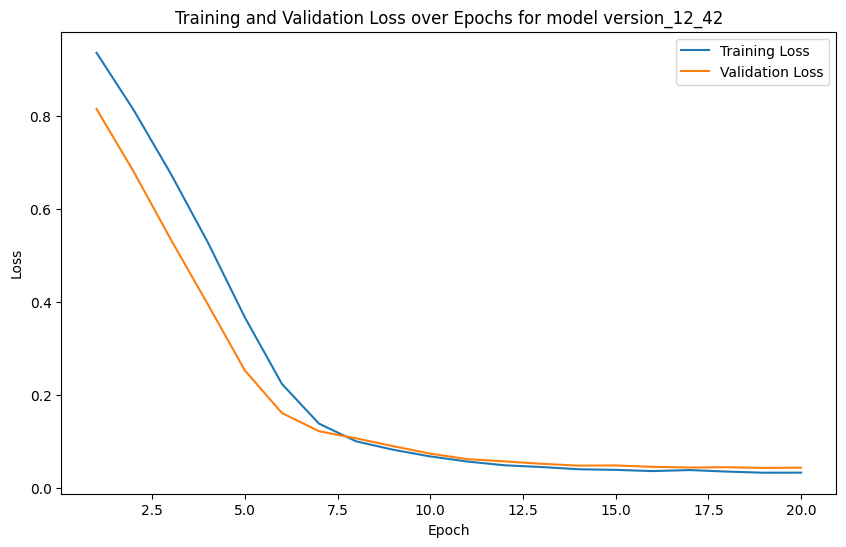

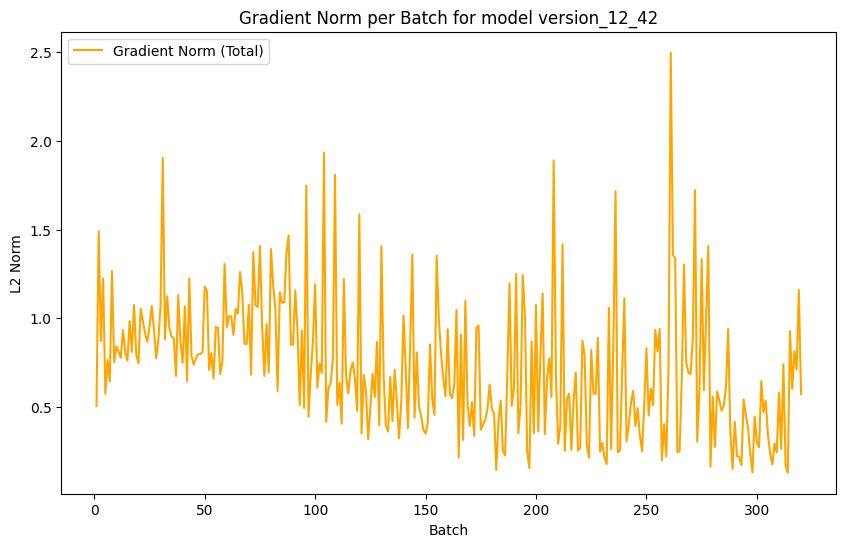

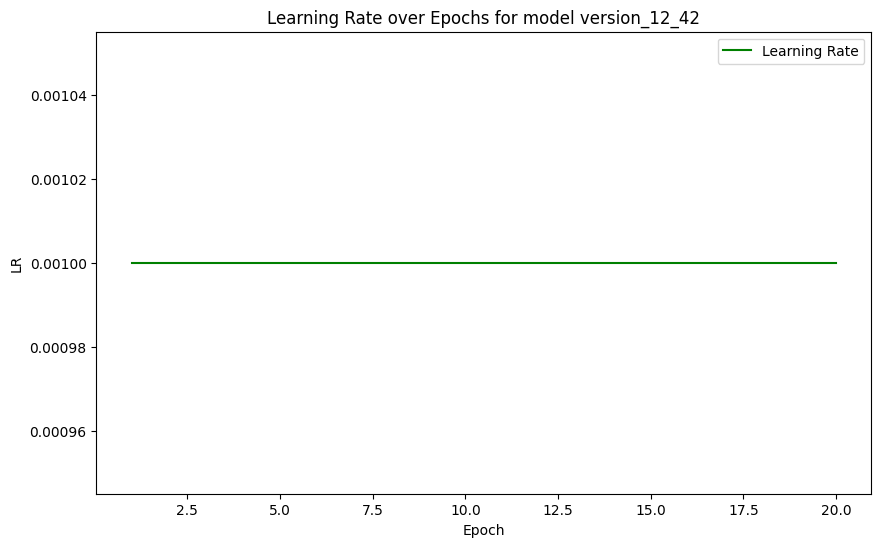

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 52
version_12_52, QUBIT: 5,LAYER: 4,SEED: 52
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.9427, Val Loss=0.8045, Grad Norm=1.1637, LR=0.00010]


New best model saved with val loss: 0.8045


Epoch 2/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.7583, Val Loss=0.6042, Grad Norm=1.3035, LR=0.00010]


New best model saved with val loss: 0.6042


Epoch 3/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.5739, Val Loss=0.4406, Grad Norm=1.1192, LR=0.00010]


New best model saved with val loss: 0.4406


Epoch 4/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.4180, Val Loss=0.3037, Grad Norm=0.9113, LR=0.00010]


New best model saved with val loss: 0.3037


Epoch 5/20: 100%|██████████| 32/32 [00:39<00:00,  1.23s/batch, Train Loss=0.2894, Val Loss=0.2038, Grad Norm=0.8837, LR=0.00010]


New best model saved with val loss: 0.2038


Epoch 6/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.1979, Val Loss=0.1444, Grad Norm=1.2714, LR=0.00010]


New best model saved with val loss: 0.1444


Epoch 7/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.1416, Val Loss=0.1092, Grad Norm=0.3299, LR=0.00010]


New best model saved with val loss: 0.1092


Epoch 8/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.1050, Val Loss=0.0871, Grad Norm=0.7441, LR=0.00010]


New best model saved with val loss: 0.0871


Epoch 9/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0823, Val Loss=0.0718, Grad Norm=0.2420, LR=0.00010]


New best model saved with val loss: 0.0718


Epoch 10/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0655, Val Loss=0.0625, Grad Norm=0.8065, LR=0.00010]


New best model saved with val loss: 0.0625


Epoch 11/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.0575, Val Loss=0.0591, Grad Norm=0.8330, LR=0.00010]


New best model saved with val loss: 0.0591


Epoch 12/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0499, Val Loss=0.0505, Grad Norm=0.5691, LR=0.00010]


New best model saved with val loss: 0.0505


Epoch 13/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0459, Val Loss=0.0491, Grad Norm=0.3467, LR=0.00010]


New best model saved with val loss: 0.0491


Epoch 14/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0422, Val Loss=0.0483, Grad Norm=0.4195, LR=0.00010]


New best model saved with val loss: 0.0483


Epoch 15/20: 100%|██████████| 32/32 [00:38<00:00,  1.22s/batch, Train Loss=0.0410, Val Loss=0.0462, Grad Norm=1.2470, LR=0.00010]


New best model saved with val loss: 0.0462


Epoch 17/20: 100%|██████████| 32/32 [00:39<00:00,  1.23s/batch, Train Loss=0.0386, Val Loss=0.0441, Grad Norm=0.3686, LR=0.00010]


New best model saved with val loss: 0.0441


Epoch 18/20: 100%|██████████| 32/32 [00:40<00:00,  1.26s/batch, Train Loss=0.0364, Val Loss=0.0441, Grad Norm=0.4142, LR=0.00010]


New best model saved with val loss: 0.0441


Epoch 19/20: 100%|██████████| 32/32 [00:39<00:00,  1.24s/batch, Train Loss=0.0356, Val Loss=0.0436, Grad Norm=0.3862, LR=0.00010]


New best model saved with val loss: 0.0436


Epoch 20/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0353, Val Loss=0.0451, Grad Norm=0.6891, LR=0.00010]



=== Final Metrics ===
Final Train Loss: 0.0353
Final Val Loss: 0.0451
Generalization Gap: 0.0098
Best Val Epoch: 19
Training Time: 13.02 minutes
Trainable Parameters: 506


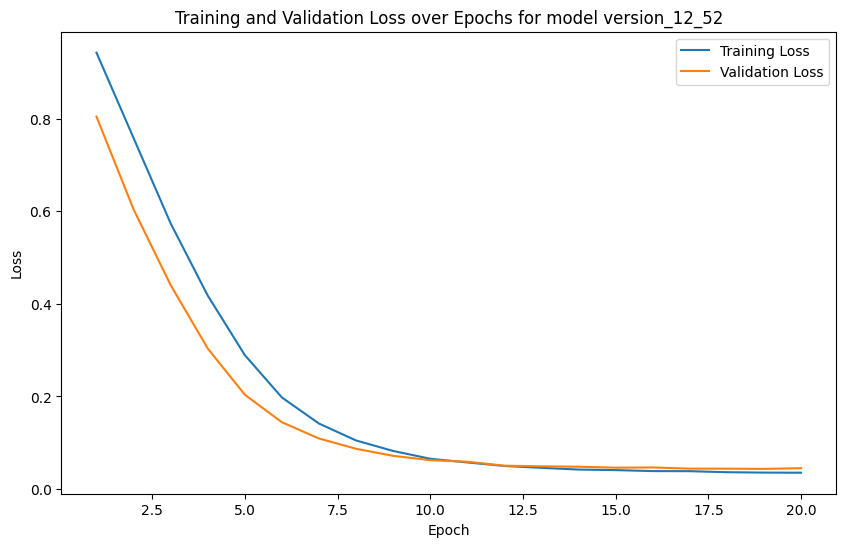

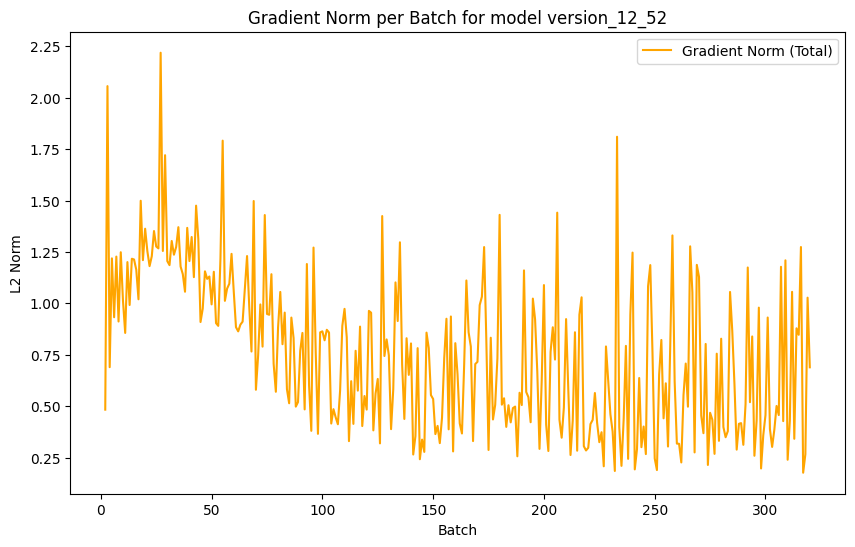

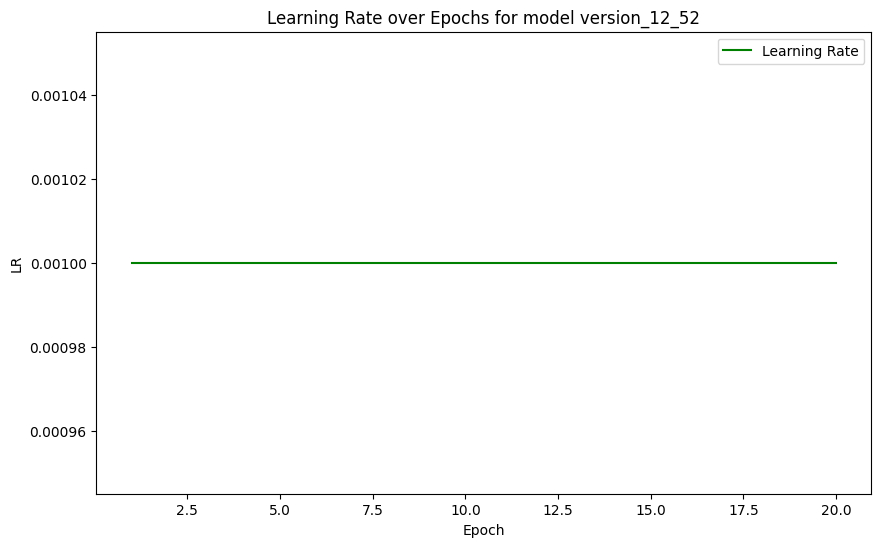

/home/tiwashri/miniconda3/envs/qgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Random Seed set to: 62
version_12_62, QUBIT: 5,LAYER: 4,SEED: 62
Using device: cuda
PyTorch CUDA version: 12.4
PennyLane device configured: lightning.gpu on GPU


Epoch 1/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=1.0058, Val Loss=0.8421, Grad Norm=1.5107, LR=0.00010]


New best model saved with val loss: 0.8421


Epoch 2/20: 100%|██████████| 32/32 [00:40<00:00,  1.26s/batch, Train Loss=0.8123, Val Loss=0.6608, Grad Norm=1.1762, LR=0.00010]


New best model saved with val loss: 0.6608


Epoch 3/20: 100%|██████████| 32/32 [00:40<00:00,  1.27s/batch, Train Loss=0.6348, Val Loss=0.4885, Grad Norm=0.9756, LR=0.00010]


New best model saved with val loss: 0.4885


Epoch 4/20: 100%|██████████| 32/32 [00:39<00:00,  1.23s/batch, Train Loss=0.4496, Val Loss=0.3168, Grad Norm=1.4227, LR=0.00010]


New best model saved with val loss: 0.3168


Epoch 5/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.2797, Val Loss=0.1912, Grad Norm=1.4978, LR=0.00010]


New best model saved with val loss: 0.1912


Epoch 6/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.1774, Val Loss=0.1287, Grad Norm=1.7167, LR=0.00010]


New best model saved with val loss: 0.1287


Epoch 7/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.1211, Val Loss=0.0969, Grad Norm=0.8938, LR=0.00010]


New best model saved with val loss: 0.0969


Epoch 8/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0898, Val Loss=0.0833, Grad Norm=0.8705, LR=0.00010]


New best model saved with val loss: 0.0833


Epoch 9/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0688, Val Loss=0.0674, Grad Norm=1.1875, LR=0.00010]


New best model saved with val loss: 0.0674


Epoch 10/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0560, Val Loss=0.0565, Grad Norm=0.7034, LR=0.00010]


New best model saved with val loss: 0.0565


Epoch 11/20: 100%|██████████| 32/32 [00:39<00:00,  1.23s/batch, Train Loss=0.0484, Val Loss=0.0509, Grad Norm=0.5521, LR=0.00010]


New best model saved with val loss: 0.0509


Epoch 12/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0450, Val Loss=0.0469, Grad Norm=0.5841, LR=0.00010]


New best model saved with val loss: 0.0469


Epoch 13/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0406, Val Loss=0.0446, Grad Norm=0.5663, LR=0.00010]


New best model saved with val loss: 0.0446


Epoch 14/20: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, Train Loss=0.0387, Val Loss=0.0430, Grad Norm=0.4882, LR=0.00010]


New best model saved with val loss: 0.0430


Epoch 17/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0353, Val Loss=0.0416, Grad Norm=0.1138, LR=0.00010]


New best model saved with val loss: 0.0416


Epoch 18/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0344, Val Loss=0.0411, Grad Norm=0.6195, LR=0.00010]


New best model saved with val loss: 0.0411


Epoch 20/20: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, Train Loss=0.0349, Val Loss=0.0411, Grad Norm=0.5407, LR=0.00010]


New best model saved with val loss: 0.0411

=== Final Metrics ===
Final Train Loss: 0.0349
Final Val Loss: 0.0411
Generalization Gap: 0.0062
Best Val Epoch: 20
Training Time: 13.07 minutes
Trainable Parameters: 506


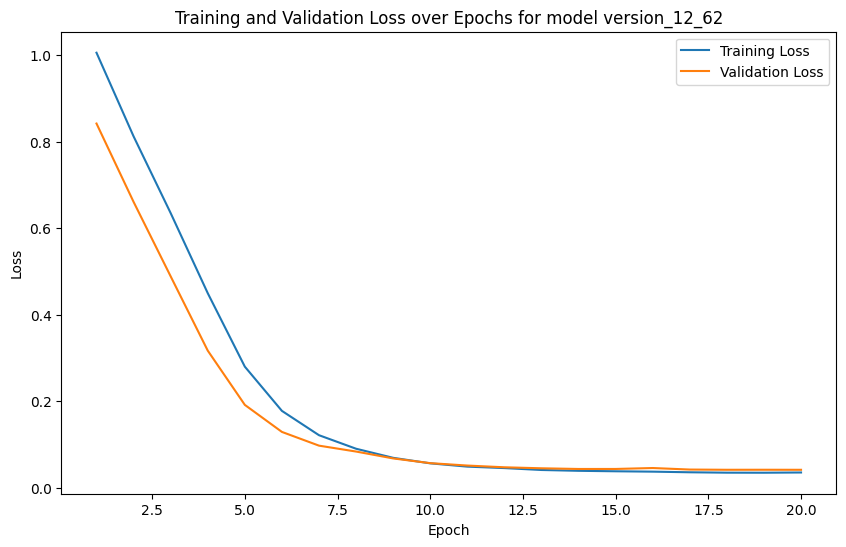

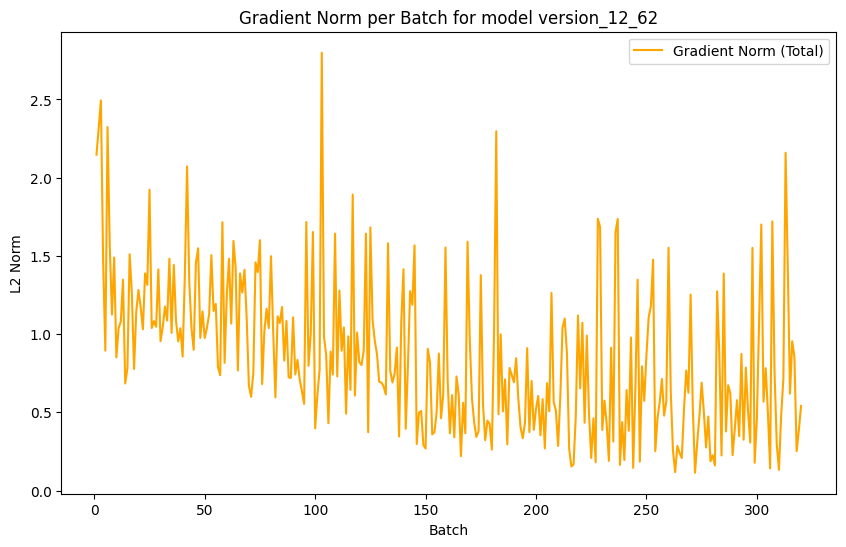

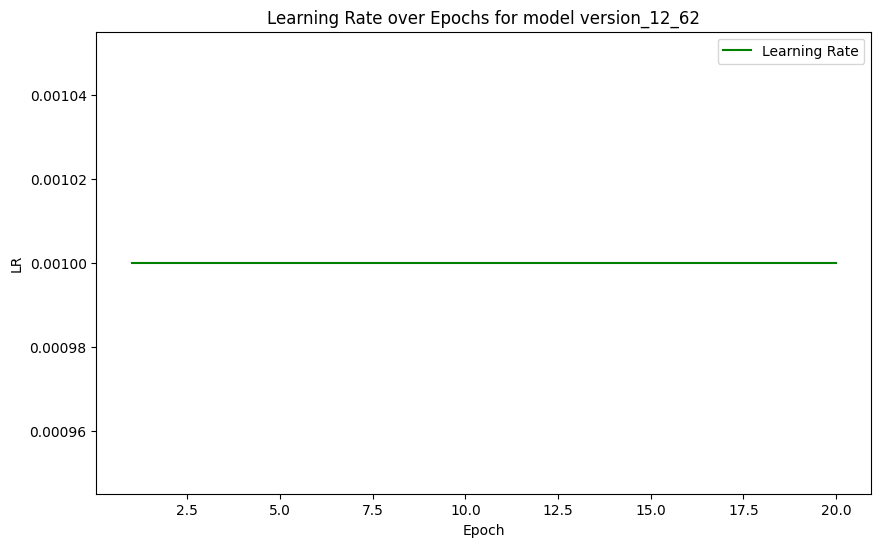

In [ ]:
# for 5 qubits circuits
# model 10,11,12

c = 9

for num_qubit in range(....):
    for layers in range(....):
        c += 1

        for rs in l:
            # =====================
            # 0. MODEL CONFIGURATION
            # =====================
            # model_name = version_1 for model 1 and 1_1 for model 1 with random seed 1 
            model_name = f"version_{c}_{rs}" 

            # General settings
            USE_GPU = True
            BATCH_SIZE = ....
            INPUT_DIM = ....
            HIDDEN_DIM = ....
            QUANTUM_OUTPUT_DIM = ....
            POST_HIDDEN_DIM = ....
            FINAL_OUTPUT_DIM = ....
            NUM_SAMPLES = ....  # Limit dataset to 1000 samples

            # Quantum settings
            NUM_QUBITS = num_qubit
            NUM_LAYERS = layers
            RANDOM_SEED = rs  # Set your desired fixed seed


            DIFF_METHOD = "...."


            # =====================
            # 1. Random Seed Configuration
            # =====================

            # Set fixed seed for reproducibility
            torch.manual_seed(RANDOM_SEED)
            torch.cuda.manual_seed_all(RANDOM_SEED)  # if using multiple GPUs

            print(f"Random Seed set to: {RANDOM_SEED}")


            # =====================
            # 0. TRAINING CONFIGURATION
            # =====================

            NUM_EPOCHS = ....
            EARLY_STOP_PATIENCE = ....
            BATCH_SIZE = BATCH_SIZE
            LR_PRE_ENCODER = 0.....
            LR_QUANTUM = 0.....
            LR_POST_DECODER = 0.....
            WEIGHT_DECAY = 0.....
            LR_SCHEDULER_FACTOR = 0.....
            LR_SCHEDULER_PATIENCE = ....
            SAVE_MODEL_PATH = f"{model_name}.pth"

            # ===========================
            # Random State for Reproducibility
            # ===========================
            RANDOM_STATE = RANDOM_SEED  # Or any other integer of your choice

            # Setting seeds for reproducibility
            torch.manual_seed(RANDOM_STATE)
            np.random.seed(RANDOM_STATE)
            random.seed(RANDOM_STATE)

            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(RANDOM_STATE)  # For CUDA

            print(F"{model_name}, QUBIT: {NUM_QUBITS},LAYER: {NUM_LAYERS},SEED: {RANDOM_SEED}")
            run()
